<a href="https://colab.research.google.com/github/EmanueleCosenza/Polyphemus/blob/main/midi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/home/cosenza/thesis/Polyphemus


In [2]:
!git branch

* main
  sparse


Libraries installation

In [3]:
#!tar -C data -xvzf data/lmd_matched.tar.gz

In [4]:
# Install the required music libraries
#!pip3 install muspy
#!pip3 install pypianoroll

In [5]:
# Install torch_geometric
#!v=$(python3 -c "import torch; print(torch.__version__)"); \
#pip3 install torch-scatter -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-sparse -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-geometric

Reproducibility

In [6]:
import numpy as np
import torch
import random
import os

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42
set_seed(seed)

In [7]:
import os
import muspy
from itertools import product
import pypianoroll as pproll
import time
from tqdm.auto import tqdm


class MIDIPreprocessor():
    
    def __init__():
        pass

    def preprocess_dataset(self, dir, early_exit=None):
        pass
    
    def preprocess_file(self, f):
        pass


# Todo: to config file (or separate files)
MAX_SIMU_NOTES = 16 # 14 + SOS and EOS

PITCH_SOS = 128
PITCH_EOS = 129
PITCH_PAD = 130
DUR_PAD_IND = 2
MAX_DUR = 511 # equivalent to 16 bars (with RESOLUTION=32)

RESOLUTION = 32
NUM_BARS = 1


def preprocess_file(filepath, dest_dir, num_samples):

    saved_samples = 0

    print("Preprocessing file " + filepath)

    # Load the file both as a pypianoroll song and a muspy song
    # (Need to load both since muspy.to_pypianoroll() is expensive)
    try:
        pproll_song = pproll.read(filepath, resolution=RESOLUTION)
        muspy_song = muspy.read(filepath)
    except Exception as e:
        print("Song skipped (Invalid song format)")
        return 0
    
    # Only accept songs that have a time signature of 4/4 and no time changes
    for t in muspy_song.time_signatures:
        if t.numerator != 4 or t.denominator != 4:
            print("Song skipped ({}/{} time signature)".
                            format(t.numerator, t.denominator))
            return 0

    # Gather tracks of pypianoroll song based on MIDI program number
    drum_tracks = []
    bass_tracks = []
    guitar_tracks = []
    strings_tracks = []

    for track in pproll_song.tracks:
        if track.is_drum:
            track.name = 'Drums'
            drum_tracks.append(track)
        elif 0 <= track.program <= 31:
            track.name = 'Guitar'
            guitar_tracks.append(track)
        elif 32 <= track.program <= 39:
            track.name = 'Bass'
            bass_tracks.append(track)
        else:
            # Tracks with program > 39 are all considered as strings tracks
            # and will be merged into a single track later on
            strings_tracks.append(track)

    # Filter song if it does not contain drum, guitar, bass or strings tracks
    if not drum_tracks or not guitar_tracks \
       or not bass_tracks or not strings_tracks:
        print("Song skipped (does not contain drum or "
                "guitar or bass or strings tracks)")
        return 0
    
    # Merge strings tracks into a single pypianoroll track
    strings = pproll.Multitrack(tracks=strings_tracks)
    strings_track = pproll.Track(pianoroll=strings.blend(mode='max'),
                                 program=48, name='Strings')

    combinations = list(product(drum_tracks, bass_tracks, guitar_tracks))

    # Single instruments can have multiple tracks.
    # Consider all possible combinations of drum, bass, and guitar tracks
    for i, combination in enumerate(combinations):

        print("Processing combination", i+1, "of", len(combinations))
        
        # Process combination (called 'subsong' from now on)
        drum_track, bass_track, guitar_track = combination
        tracks = [drum_track, bass_track, guitar_track, strings_track]
        
        pproll_subsong = pproll.Multitrack(
            tracks=tracks,
            tempo=pproll_song.tempo,
            resolution=RESOLUTION
        )
        muspy_subsong = muspy.from_pypianoroll(pproll_subsong)
        
        tracks_notes = [track.notes for track in muspy_subsong.tracks]
        
        # Obtain length of subsong (maximum of each track's length)
        length = 0
        for notes in tracks_notes:
            track_length = max(note.end for note in notes) if notes else 0
            length = max(length, track_length)
        length += 1

        # Add timesteps until length is a multiple of RESOLUTION
        length = length if length%(RESOLUTION) == 0 \
                                else length + (RESOLUTION-(length%(RESOLUTION)))


        tracks_tensors = []
        tracks_activations = []

        dur_bin_length = int(np.ceil(np.log2(MAX_DUR)))

        # Todo: adapt to velocity
        for notes in tracks_notes:

            # Initialize encoder-ready track tensor
            # track_tensor: (length x max_simu_notes x 2 (or 3 if velocity))
            # The last dimension contains pitches and durations (and velocities)
            # int16 is enough for small to medium duration values
            track_tensor = np.zeros((length, MAX_SIMU_NOTES, 2), np.int16)

            track_tensor[:, :, 0] = PITCH_PAD
            track_tensor[:, 0, 0] = PITCH_SOS

            # Keeps track of how many notes have been stored in each timestep
            # (int8 imposes that MAX_SIMU_NOTES < 256)
            notes_counter = np.ones(length, dtype=np.int8)

            # Todo: np.put_along_axis?
            for note in notes:
                # Insert note in the lowest position available in the timestep
                
                t = note.time

                if notes_counter[t] >= MAX_SIMU_NOTES-1:
                    # Skip note if there is no more space
                    continue

                track_tensor[t, notes_counter[t], 0] = note.pitch
                track_tensor[t, notes_counter[t], 1] = note.duration
                notes_counter[t] += 1
            
            # Add end of sequence token
            track_tensor[np.arange(0, length), notes_counter, 0] = PITCH_EOS

            # Get track activations, a boolean tensor indicating whether notes
            # are being played in a timestep (sustain does not count)
            # (needed for graph rep.)
            activations = np.array(notes_counter-1, dtype=bool)

            tracks_tensors.append(track_tensor)
            tracks_activations.append(activations)
        
        # (#tracks x length x max_simu_notes x 2 (or 3))
        subsong_tensor = np.stack(tracks_tensors, axis=0)

        # (#tracks x length)
        subsong_activations = np.stack(tracks_activations, axis=0)


        # Slide window over 'subsong_tensor' and 'subsong_activations' along the
        # time axis (2nd dimension) with the stride of a bar
        # Todo: np.lib.stride_tricks.as_strided(song_proll)
        for i in range(0, length-NUM_BARS*RESOLUTION+1, RESOLUTION):
            
            # Get the sequence and its activations
            seq_tensor = subsong_tensor[:, i:i+NUM_BARS*RESOLUTION, :]
            seq_acts = subsong_activations[:, i:i+NUM_BARS*RESOLUTION]

            if NUM_BARS > 1:
                # Skip sequence if it contains more than one bar of consecutive
                # silence in at least one track
                bars = seq_acts.reshape(seq_acts.shape[0], NUM_BARS, -1)
                bars_acts = np.any(bars, axis=2)

                if 1 in np.diff(np.where(bars_acts == 0)[1]):
                    continue
            else:
                # In the case of just 1 bar, skip it if all tracks are silenced
                bar_acts = np.any(seq_acts, axis=1)
                if not np.any(bar_acts):
                    continue
                

            # Randomly transpose the pitches of the sequence (-5 to 6 semitones)
            shift = np.random.choice(np.arange(-5, 7), 1)
            cond = (seq_tensor[:, :, :, 0] != PITCH_PAD) &                     \
                   (seq_tensor[:, :, :, 0] != PITCH_SOS) &                     \
                   (seq_tensor[:, :, :, 0] != PITCH_EOS)
            seq_tensor[cond, 0] += shift

            # Save sample (seq_tensor and seq_acts) to file
            curr_sample = str(num_samples + saved_samples)
            sample_filepath = os.path.join(dest_dir, curr_sample)
            np.savez(sample_filepath, seq_tensor=seq_tensor, seq_acts=seq_acts)

            saved_samples += 1


    print("File preprocessing finished. Saved samples:", saved_samples)
    print()

    return saved_samples




# Total number of files: 116189
# Number of unique files: 45129
def preprocess_dataset(dataset_dir, dest_dir, num_files=45129, early_exit=None):

    files_dict = {}
    seen = 0
    tot_samples = 0
    not_filtered = 0
    finished = False
    
    print("Starting preprocessing")
    
    progress_bar = tqdm(range(early_exit)) if early_exit is not None else tqdm(range(num_files))
    start = time.time()

    # Visit recursively the directories inside the dataset directory
    for dirpath, dirs, files in os.walk(dataset_dir):

        # Sort alphabetically the found directories
        # (to help guess the remaining time) 
        dirs.sort()
        
        print("Current path:", dirpath)
        print()

        for f in files:
            
            seen += 1

            if f in files_dict:
                # Skip already seen file
                files_dict[f] += 1
                continue

            # File never seen before, add to dictionary of files
            # (from filename to # of occurrences)
            files_dict[f] = 1

            # Preprocess file
            filepath = os.path.join(dirpath, f)
            n_saved = preprocess_file(filepath, dest_dir, tot_samples)

            tot_samples += n_saved
            if n_saved > 0:
                not_filtered += 1
            
            progress_bar.update(1)
            
            # Todo: also print # of processed (not filtered) files
            #       and # of produced sequences (samples)
            print("Total number of seen files:", seen)
            print("Number of unique files:", len(files_dict))
            print("Total number of non filtered songs:", not_filtered)
            print("Total number of saved samples:", tot_samples)
            print()

            # Exit when a maximum number of files has been processed (if set)
            if early_exit != None and len(files_dict) >= early_exit:
                finished = True
                break

        if finished:
            break
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Preprocessing completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
              .format(int(hours),int(minutes),seconds))


In [8]:
!rm -rf data/preprocessed/
!mkdir data/preprocessed

In [9]:
dataset_dir = 'data/lmd_matched'
dest_dir = 'data/preprocessed'

Check preprocessed data:

In [10]:
preprocess_dataset(dataset_dir, dest_dir, early_exit=1)

Starting preprocessing


  0%|          | 0/1 [00:00<?, ?it/s]

Current path: data/lmd_matched

Current path: data/lmd_matched/A

Current path: data/lmd_matched/A/A

Current path: data/lmd_matched/A/A/A

Current path: data/lmd_matched/A/A/A/TRAAAGR128F425B14B

Preprocessing file data/lmd_matched/A/A/A/TRAAAGR128F425B14B/1d9d16a9da90c090809c153754823c2b.mid
Processing combination 1 of 7
Processing combination 2 of 7
Processing combination 3 of 7
Processing combination 4 of 7
Processing combination 5 of 7
Processing combination 6 of 7
Processing combination 7 of 7
File preprocessing finished. Saved samples: 3031

Total number of seen files: 1
Number of unique files: 1
Total number of non filtered songs: 1
Total number of saved samples: 3031

Preprocessing completed in (h:m:s): 00:00:02.99


In [11]:
filepath = os.path.join(dest_dir, "5.npz")
data = np.load(filepath)

In [12]:
print(data["seq_tensor"].shape)
print(data["seq_acts"].shape)

(4, 32, 16, 2)
(4, 32)


In [13]:
data["seq_tensor"][0, 0]

array([[128,   0],
       [129,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0]], dtype=int16)

# Model

In [14]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.data import Data
import itertools


def unpackbits(x, num_bits):

    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")

    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])

    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])


def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


class MIDIDataset(Dataset):

    def __init__(self, dir):
        self.dir = dir

    def __len__(self):
        _, _, files = next(os.walk(self.dir))
        return len(files)

    
    def __get_track_edges(self, acts, edge_type_ind=0):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()

        labels = np.arange(acts.shape[0]*acts.shape[1])
        labels = labels.reshape(acts.shape[0], acts.shape[1]).transpose()

        track_edges = []

        for track in range(a_t.shape[1]):
            tr_inds = list(inds[inds[:,1] == track])
            e_inds = [(tr_inds[i],
                    tr_inds[i+1]) for i in range(len(tr_inds)-1)]
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, e[1][0]-e[0][0]) for e in e_inds]
            track_edges.extend(edges)

        return np.array(track_edges, dtype='long')

    
    def __get_onset_edges(self, acts, edge_type_ind=1):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        labels = np.arange(acts.shape[0]*acts.shape[1])
        labels = labels.reshape(acts.shape[0], acts.shape[1]).transpose()

        onset_edges = []

        for i in ts_inds:
            ts_acts_inds = list(inds[inds[:,0] == i])
            if len(ts_acts_inds) < 2:
                continue
            e_inds = list(itertools.combinations(ts_acts_inds, 2))
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, 0) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            onset_edges.extend(edges)
            onset_edges.extend(inv_edges)

        return np.array(onset_edges, dtype='long')


    def __get_next_edges(self, acts, edge_type_ind=2):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        labels = np.arange(acts.shape[0]*acts.shape[1])
        labels = labels.reshape(acts.shape[0], acts.shape[1]).transpose()

        next_edges = []

        for i in range(len(ts_inds)-1):

            ind_s = ts_inds[i]
            ind_e = ts_inds[i+1]
            s = inds[inds[:,0] == ind_s]
            e = inds[inds[:,0] == ind_e]

            e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
            edges = [(labels[tuple(e[0])],labels[tuple(e[1])], edge_type_ind, ind_e-ind_s) for e in e_inds]

            next_edges.extend(edges)

        return np.array(next_edges, dtype='long')


    def __getitem__(self, idx):

        # Load tensors
        sample_path = os.path.join(self.dir, str(idx) + ".npz")
        data = np.load(sample_path)

        seq_tensor = data["seq_tensor"]
        seq_acts = data["seq_acts"]
        
        # Construct src_key_padding_mask (PAD = 130)
        src_mask = torch.from_numpy((seq_tensor[..., 0] == 130))

        # From decimals to one-hot (pitch)
        pitches = seq_tensor[:, :, :, 0]
        onehot = np.zeros((pitches.shape[0]*pitches.shape[1]*pitches.shape[2],
                            131), dtype=float)
        onehot[np.arange(0, onehot.shape[0]), pitches.reshape(-1)] = 1.
        onehot = onehot.reshape(-1, pitches.shape[1], seq_tensor.shape[2], 131)

        # From decimals to binary (pitch)
        durs = seq_tensor[:, :, :, 1]
        bin_durs = unpackbits(durs, 9)[:, :, :, ::-1]

        # Concatenate pitches and durations
        new_seq_tensor = np.concatenate((onehot[:, :, :, :], bin_durs),
                             axis=-1)
        
        # Construct graph from boolean activations
        track_edges = self.__get_track_edges(seq_acts)
        onset_edges = self.__get_onset_edges(seq_acts)
        next_edges = self.__get_next_edges(seq_acts)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        no_edges = (len(track_edges) == 0 and 
                    len(onset_edges) == 0 and len(next_edges) == 0)
        if not no_edges:
            edge_list = np.concatenate([x for x in edges
                                          if x.size > 0])
            edge_list = torch.from_numpy(edge_list)
        
        # Adapt tensor to torch_geometric's Data
        # Todo: re-check no edges case
        edge_index = (torch.LongTensor([[], []]) if no_edges else
                               edge_list[:, :2].t().contiguous())
        edge_attr = (torch.Tensor([[0, 0]]) if no_edges else
                                       edge_list[:, 2:])
        
        n = seq_acts.shape[0]*seq_acts.shape[1]
        graph = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=n)
        
        # Todo: start with torch at mount
        return torch.Tensor(new_seq_tensor), torch.Tensor(seq_acts), graph, src_mask


In [15]:
import torch
from torch import nn, Tensor
from torch_geometric.nn.conv import GCNConv
import torch.nn.functional as F
import math
import torch.optim as optim


# Todo: check and think about max_len
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 256):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *                     \
                             (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class GCN(nn.Module):
    
    def __init__(self, features_dims=[256, 256, 256], num_relations=3,
                    dropout=0.1):
        super().__init__()
        
        self.layers = torch.nn.ModuleList()
        self.dropout = dropout
        
        for i in range(len(features_dims)-1):
            self.layers.append(GCNConv(features_dims[i], features_dims[i+1]))
            

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for layer in self.layers:
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = layer(x, edge_index)
            x = F.relu(x)

        return x


class Encoder(nn.Module):

    # 140 = 128+3+9
    def __init__(self, d_token=140, d_transf=256, nhead_transf=4, 
                 num_layers_transf=2, dropout=0.1):
        super().__init__()

        # Todo: one separate encoder for drums (or encode as a binary feature)
        # Transformer Encoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        transf_layer = nn.TransformerEncoderLayer(
            d_model=d_transf,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            transf_layer,
            num_layers=num_layers_transf
        )

        # Graph encoder
        self.graph_encoder = GCN(dropout=dropout)

        # (LSTM)
        
        # Linear layers that compute the final mu and log_var
        # Todo: as parameters
        self.linear_mu = nn.Linear(256, 256)
        self.linear_log_var = nn.Linear(256, 256)

    def forward(self, x_seq, x_acts, x_graph, src_mask):

        # Collapse track (and optionally batch) dimension
        #print("Init input:", x_seq.size())
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        #print("Reshaped input:", x_seq.size())
        #print("Reshaped src_mask:", src_mask.size())

        # Compute embeddings
        embs = self.embedding(x_seq)
        #print("Embs:", embs.size())

        # batch_first = False
        embs = embs.permute(1, 0, 2)
        #print("Seq len first input:", embs.size())

        pos_encs = self.pos_encoder(embs)
        #print("Pos encodings:", pos_encs.size())

        transformer_encs = self.transformer_encoder(pos_encs, 
                                                    src_key_padding_mask=src_mask)
        #print("Transf encodings:", transformer_encs.size())

        pooled_encs = torch.mean(transformer_encs, 0)
        #print("Pooled encodings:", pooled_encs.size())

        # Compute node encodings
        x_graph.x = pooled_encs
        node_encs = self.graph_encoder(x_graph)
        #print("Node encodings:", node_encs.size())
        
        # Compute final graph latent vector(s)
        # (taking into account the batch size)
        num_nodes = x_graph[0].num_nodes
        batch_sz = node_encs.size(0) // num_nodes
        node_encs = node_encs.view(batch_sz, num_nodes, -1)
        encoding = torch.mean(node_encs, 1)

        # Compute mu and log(std^2)
        mu = self.linear_mu(encoding)
        log_var = self.linear_log_var(encoding)
        
        return mu, log_var


class Decoder(nn.Module):

    def __init__(self, d_z=256, n_tracks=4, resolution=32, d_token=140, d_model=256,
                 d_transf=256, nhead_transf=4, num_layers_transf=2, dropout=0.1):
        super().__init__()

        # (LSTM)

        # Boolean activations decoder (CNN/MLP)
        #self.acts_decoder = nn.Linear(d_z, n_tracks*resolution)
        self.acts_decoder = nn.Sequential(
            nn.Linear(d_z, d_z),
            nn.ReLU(),
            nn.Linear(d_z, n_tracks*resolution)
        )
        
        # GNN
        self.graph_decoder = GCN(dropout=dropout)
        
        # Transformer Decoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transf_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers_transf
        )
        
        # Last linear layer
        self.lin = nn.Linear(d_model, 140)


    def forward(self, z, x_seq, x_acts, x_graph, src_mask, tgt_mask):

        # Compute activations from z
        acts_out = self.acts_decoder(z)
        acts_out = acts_out.view(x_acts.size())
        #print("Acts out:", acts_out.size())

        # Initialize node features with z and propagate with GNN
        node_features = torch.repeat_interleave(
                            z, x_acts.size(-1)*x_acts.size(-2), axis=0)
        #print("Node features:", node_features.size())

        # Todo: use also edge info
        x_graph.x = node_features
        node_decs = self.graph_decoder(x_graph)
        #print("Node decodings:", node_decs.size())
        
        node_decs = node_decs.repeat(16, 1, 1)
        #print("Tiled node decodings:", node_decs.size())

        # Decode features with transformer decoder
        # forward(tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        # Todo: same embeddings as encoder?
        seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        embs = self.embedding(seq)
        embs = embs.permute(1, 0, 2)
        pos_encs = self.pos_encoder(embs)

        seq_out = self.transf_decoder(pos_encs, node_decs,
                                      tgt_key_padding_mask=src_mask,
                                      tgt_mask=tgt_mask)
        #print("Seq out:", seq_out.size())
        
        seq_out = self.lin(seq_out)
        #print("Seq out after lin:", seq_out.size())
        
        # Softmax on first 131 values (pitch), sigmoid on last 9 (dur)
        #seq_out[:, :, :131] = F.log_softmax(seq_out[:, :, :131], dim=-1)
        #seq_out[:, :, 131:] = torch.sigmoid(seq_out[:, :, 131:])
        seq_out = seq_out.permute(1, 0, 2)
        seq_out = seq_out.view(x_seq.size())
        #print("Seq out after reshape", seq_out.size())
        

        return seq_out, acts_out


class VAE(nn.Module):

    def __init__(self, dropout=0.1):
        super().__init__()

        self.encoder = Encoder(dropout=dropout)
        self.decoder = Decoder(dropout=dropout)
    
    def forward(self, x_seq, x_acts, x_graph, src_mask, tgt_mask):
        
        src_mask = src_mask.view(-1, src_mask.size(-1))
        
        mu, log_var = self.encoder(x_seq, x_acts, x_graph, src_mask)
        #print("Mu:", mu.size())
        #print("log_var:", log_var.size())
        
        # Reparameterization trick
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn_like(sigma)
        #print("eps:", eps.size())
        z = mu + eps*sigma
        
        tgt = x_seq[..., :-1, :]
        src_mask = src_mask[:, :-1]
        
        out = self.decoder(z, tgt, x_acts, x_graph, src_mask, tgt_mask)
        
        return out, mu, log_var


Trainer

In [16]:
import torch.optim as optim
import matplotlib.pyplot as plt
import uuid
import copy
import time
from statistics import mean
from collections import defaultdict


class VAETrainer():
    
    def __init__(self, model, models_path, optimizer, init_lr,
                 name=None, lr_scheduler=None, device=torch.device("cuda"), 
                 print_every=1, save_every=1):
        
        self.model = model
        self.models_path = models_path
        self.optimizer = optimizer
        self.init_lr = init_lr
        self.name = name if name is not None else str(uuid.uuid4())
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.print_every = print_every
        self.save_every = save_every
        
        self.model_path = os.path.join(self.models_path, self.name)
        
        # Criteria with ignored padding
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_unreduced = nn.BCEWithLogitsLoss(reduction='none')
        self.ce = nn.CrossEntropyLoss(ignore_index=130)
        
        # Training stats
        self.losses = defaultdict(list)
        self.accuracies = defaultdict(list)
        self.lrs = []
        self.times = []
        
    
    def train(self, trainloader, validloader=None, epochs=1,
              early_exit=None):
        
        n_batches = len(trainloader)

        beta = 0 # Todo: _update_params()
        
        self.model.train()
        
        print("Starting training.\n")
        
        start = time.time()
        self.times.append(start)
        
        tot_batches = 0
        
        for epoch in range(epochs):
            
            self.cur_epoch = epoch
            progress_bar = tqdm(range(n_batches))
            
            for batch_idx, inputs in enumerate(trainloader):
                
                self.cur_batch_idx = batch_idx
                
                # Zero out the gradients
                self.optimizer.zero_grad()
                
                # Get the inputs
                x_seq, x_acts, x_graph, src_mask = inputs
                x_seq = x_seq.float().to(self.device)
                x_acts = x_acts.to(self.device)
                x_graph = x_graph.to(self.device)
                src_mask = src_mask.to(self.device)
                tgt_mask = generate_square_subsequent_mask(x_seq.size(-2)-1).to(self.device)
                inputs = (x_seq, x_acts, x_graph)

                # Forward pass, get the reconstructions
                outputs, mu, log_var = self.model(x_seq, x_acts, x_graph, src_mask, tgt_mask)
                
                # Compute the backprop loss and other required losses
                tot_loss, losses = self._compute_losses(inputs, outputs, mu,
                                                         log_var, beta)
                
                # Backprop and update lr
                tot_loss.backward()
                self.optimizer.step()
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()
                    
                # Update the stats
                self._append_losses(losses)
                
                last_lr = (self.lr_scheduler.get_last_lr()[0] 
                               if self.lr_scheduler is not None else self.init_lr)
                self.lrs.append(last_lr)
                
                accs = self._compute_accuracies(inputs, outputs)
                self._append_accuracies(accs)
                
                now = time.time()
                self.times.append(now)
                
                # Print stats
                if (tot_batches + 1) % self.print_every == 0:
                    print("Training on batch {}/{} of epoch {}/{} complete."
                          .format(batch_idx+1, n_batches, epoch+1, epochs))
                    self._print_stats()
                    #print("Tot_loss: {:.4f} acts_loss: {:.4f} "
                          #.format(running_loss/self.print_every, acts_loss), end='')
                    #print("pitches_loss: {:.4f} dur_loss: {:.4f} kld_loss: {:.4f}"
                          #.format(pitches_loss, dur_loss, kld_loss))
                    print("\n----------------------------------------\n")
                    
                # When appropriate, save model and stats on disk
                if self.save_every > 0 and (tot_batches + 1) % self.save_every == 0:
                    print("\nSaving model to disk...\n")
                    self._save_model()
                
                progress_bar.update(1)
                
                # Stop prematurely if early_exit is set and reached
                if early_exit is not None and (tot_batches + 1) > early_exit:
                    break
                    
                tot_batches += 1
            

        end = time.time()
        # Todo: self.__print_time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Training completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours),int(minutes),seconds))
        
        print("Saving model to disk...")
        self._save_model()
        
        print("Model saved.")
        
    
    def _compute_losses(self, inputs, outputs, mu, log_var, beta):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        x_seq = x_seq[..., 1:, :]
        
        # Mask padding
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        mask = (pitches_true != 130).unsqueeze(-1)
        
        # Compute the losses
        acts_loss = 10 * self.bce(acts_rec.view(-1), x_acts.view(-1).float())
        pitches_loss = self.ce(seq_rec.reshape(-1, seq_rec.size(-1))[:, :131],
                          x_seq.reshape(-1, x_seq.size(-1))[:, :131].argmax(dim=1))
        #dur_loss = self.bce(seq_rec[..., 131:].reshape(-1), 
                       #x_seq[..., 131:].reshape(-1))
        dur_loss = self.bce_unreduced(seq_rec[..., 131:],
                            x_seq[..., 131:])
        dur_loss = mask * dur_loss
        dur_loss = torch.sum(dur_loss) / torch.sum(mask)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        rec_loss = pitches_loss + dur_loss + acts_loss
        tot_loss = rec_loss + beta*kld_loss
        
        losses = {
            'tot': tot_loss.item(),
            'pitches': pitches_loss.item(),
            'dur': dur_loss.item(),
            'acts': acts_loss.item(),
            'rec': rec_loss.item(),
            'kld': kld_loss.item(),
            'beta*kld': beta*kld_loss.item()
        }
        
        return tot_loss, losses

    
    def _append_losses(self, losses):
        
        for k, loss in losses.items():
            self.losses[k].append(loss)
            
            
    def _compute_accuracies(self, inputs, outputs):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        x_seq = x_seq[..., 1:, :]
        
        notes_acc = self._note_accuracy(seq_rec, x_seq)
        pitches_acc = self._pitches_accuracy(seq_rec, x_seq)
        dur_acc = self._dur_accuracy(seq_rec, x_seq)
        acts_acc = self._acts_accuracy(acts_rec, x_acts)
        
        accs = {
            'notes': notes_acc.item(),
            'pitches': pitches_acc.item(),
            'dur': dur_acc.item(),
            'acts': acts_acc.item()
        }
        
        return accs
        
        
    def _append_accuracies(self, accs):
        
        for k, acc in accs.items():
            self.accuracies[k].append(acc)
    
    
    def _acts_accuracy(self, acts_rec, x_acts):
        
        acts_rec = torch.sigmoid(acts_rec)
        acts_rec[acts_rec < 0.5] = 0
        acts_rec[acts_rec >= 0.5] = 1
        
        return torch.sum(acts_rec == x_acts) / x_acts.numel()
    
    
    def _pitches_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        preds_pitches = (pitches_rec == pitches_true)
        
        # Pad mask
        mask = (pitches_true != 130)
        preds_pitches = torch.logical_and(preds_pitches, mask)
        
        return torch.sum(preds_pitches) / torch.sum(mask)
    
    
    def _dur_accuracy(self, seq_rec, x_seq):
        
        dur_rec = torch.sigmoid(seq_rec[..., 131:])
        dur_rec[dur_rec < 0.5] = 0
        dur_rec[dur_rec >= 0.5] = 1
        
        preds_dur = torch.all(dur_rec == x_seq[..., 131:], dim=-1)
        
        # Pad mask
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        mask = (pitches_true != 130)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(preds_dur) / torch.sum(mask)
    
    
    def _note_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        preds_pitches = (pitches_rec == pitches_true)
        
        # Pad mask
        mask = (pitches_true != 130)
        preds_pitches = torch.logical_and(preds_pitches, mask)

        dur_rec = torch.sigmoid(seq_rec[..., 131:])
        dur_rec[dur_rec < 0.5] = 0
        dur_rec[dur_rec >= 0.5] = 1
        
        preds_dur = torch.all(dur_rec == x_seq[..., 131:], dim=-1)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(torch.logical_and(preds_pitches, preds_dur)) / torch.sum(mask)
    
    
    def _save_model(self):
        torch.save({
            'epoch': self.cur_epoch,
            'batch': self.cur_batch_idx,
            'save_every': self.save_every,
            'lrs': self.lrs,
            'losses': self.losses,
            'accuracies': self.accuracies,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, self.model_path)
        
        
    def _print_stats(self):
        
        hours, rem = divmod(self.times[-1]-self.times[0], 3600)
        minutes, seconds = divmod(rem, 60)
        print("Elapsed time from start (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours), int(minutes), seconds))
        
        avg_lr = mean(self.lrs[-self.print_every:])
        
        # Take mean of the last non-printed batches for each stat
        
        avg_losses = {}
        for k, l in self.losses.items():
            avg_losses[k] = mean(l[-self.print_every:])
        
        avg_accs = {}
        for k, l in self.accuracies.items():
            avg_accs[k] = mean(l[-self.print_every:])
        
        print("Losses:")
        print(avg_losses)
        print("Accuracies:")
        print(avg_accs)
        
        
        


Training

In [17]:
models_path = "models/"
os.makedirs(models_path, exist_ok=True)

In [18]:
ds_dir = "data/preprocessed"
dataset = MIDIDataset(ds_dir)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
len(dataset)
dataset[0]

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
       

In [19]:
import torch
torch.cuda.set_device(3)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print("Device:", device)
print("Current device idx:", torch.cuda.current_device())

Device: cuda
Current device idx: 3


In [20]:
!rm models/vae

In [21]:
from prettytable import PrettyTable


def print_params(model):
    
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    
    for name, parameter in model.named_parameters():
        
        if not parameter.requires_grad:
            continue
            
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
        
    print(table)
    print(f"Total Trainable Params: {total_params}")
    
    return total_params


class LinearLR(optim.lr_scheduler._LRScheduler):
    
    def __init__(self, optimizer, eps, start=0, last_epoch=-1, verbose=False):
        super(ExponentialLR, self).__init__(optimizer, last_epoch, verbose)
        
        self.eps = eps
        self.start = start
        self._schedulers = schedulers
        self._milestones = milestones
        self.last_epoch = last_epoch + 1
        

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        if self.last_epoch == 0:
            return [self.start for group in self.optimizer.param_groups]
        
        return [group['lr'] + self.eps
                for group in self.optimizer.param_groups]

    def _get_closed_form_lr(self):
        return [base_lr * self.gamma ** self.last_epoch
                for base_lr in self.base_lrs]


class SequentialLR(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, schedulers, milestones, last_epoch=-1, verbose=False):
        for scheduler_idx in range(1, len(schedulers)):
            if (schedulers[scheduler_idx].optimizer != schedulers[0].optimizer):
                raise ValueError(
                    "Sequential Schedulers expects all schedulers to belong to the same optimizer, but "
                    "got schedulers at index {} and {} to be different".format(0, scheduler_idx)
                )
        if (len(milestones) != len(schedulers) - 1):
            raise ValueError(
                "Sequential Schedulers expects number of schedulers provided to be one more "
                "than the number of milestone points, but got number of schedulers {} and the "
                "number of milestones to be equal to {}".format(len(schedulers), len(milestones))
            )
        self._schedulers = schedulers
        self._milestones = milestones
        self.last_epoch = last_epoch + 1

    def step(self):
        self.last_epoch += 1
        idx = bisect_right(self._milestones, self.last_epoch)
        if idx > 0 and self._milestones[idx - 1] == self.last_epoch:
            self._schedulers[idx].step(0)
        else:
            self._schedulers[idx].step()

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.

        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        The wrapped scheduler states will also be saved.
        """
        state_dict = {key: value for key, value in self.__dict__.items() if key not in ('optimizer', '_schedulers')}
        state_dict['_schedulers'] = [None] * len(self._schedulers)

        for idx, s in enumerate(self._schedulers):
            state_dict['_schedulers'][idx] = s.state_dict()

        return state_dict

    def load_state_dict(self, state_dict):
        """Loads the schedulers state.

        Args:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        _schedulers = state_dict.pop('_schedulers')
        self.__dict__.update(state_dict)
        # Restore state_dict keys in order to prevent side effects
        # https://github.com/pytorch/pytorch/issues/32756
        state_dict['_schedulers'] = _schedulers

        for idx, s in enumerate(_schedulers):
            self._schedulers[idx].load_state_dict(s)
        

In [22]:
print("Creating the model and moving it to the specified device...")

vae = VAE().to(device)
print_params(vae)
print()

init_lr = 5e-6
gamma = 0.999
optimizer = optim.Adam(vae.parameters(), lr=init_lr)
#scheduler1 = optim.lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=2)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)
exp_lr = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

print('--------------------------------------------------\n')

trainer = VAETrainer(
    vae,
    models_path,
    optimizer,
    init_lr,
    name='vae',
    lr_scheduler=exp_lr,
    save_every=100, 
    device=device
)

Creating the model and moving it to the specified device...
+----------------------------------------------------------------+------------+
|                            Modules                             | Parameters |
+----------------------------------------------------------------+------------+
|                    encoder.embedding.weight                    |   35840    |
|                     encoder.embedding.bias                     |    256     |
| encoder.transformer_encoder.layers.0.self_attn.in_proj_weight  |   196608   |
|  encoder.transformer_encoder.layers.0.self_attn.in_proj_bias   |    768     |
| encoder.transformer_encoder.layers.0.self_attn.out_proj.weight |   65536    |
|  encoder.transformer_encoder.layers.0.self_attn.out_proj.bias  |    256     |
|      encoder.transformer_encoder.layers.0.linear1.weight       |   524288   |
|       encoder.transformer_encoder.layers.0.linear1.bias        |    2048    |
|      encoder.transformer_encoder.layers.0.linear2.weight  

In [ ]:
trainer.train(loader, epochs=100)

Starting training.



  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:01.07
Losses:
{'tot': 18.23641586303711, 'pitches': 4.578147888183594, 'dur': 6.542874813079834, 'acts': 7.115392208099365, 'rec': 18.23641586303711, 'kld': 352.819091796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.007865168154239655, 'dur': 0.0, 'acts': 0.461669921875}

----------------------------------------

Training on batch 2/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:01.60
Losses:
{'tot': 18.070404052734375, 'pitches': 4.510310173034668, 'dur': 6.419480323791504, 'acts': 7.140613555908203, 'rec': 18.070404052734375, 'kld': 351.0546569824219, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.009019165299832821, 'dur': 0.00022547914704773575, 'acts': 0.456298828125}

----------------------------------------

Training on batch 3/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:02.14
Losses:
{'tot': 17.956218719482422, 'pitches': 4.

Training on batch 20/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:11.72
Losses:
{'tot': 16.21092414855957, 'pitches': 3.922656774520874, 'dur': 5.1982035636901855, 'acts': 7.09006404876709, 'rec': 16.21092414855957, 'kld': 382.08428955078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.010351034812629223, 'pitches': 0.2776777744293213, 'dur': 0.04252925142645836, 'acts': 0.473876953125}

----------------------------------------

Training on batch 21/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:12.29
Losses:
{'tot': 15.997754096984863, 'pitches': 3.83085560798645, 'dur': 5.117702484130859, 'acts': 7.049196243286133, 'rec': 15.997754096984863, 'kld': 385.40899658203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.012869722209870815, 'pitches': 0.3680289089679718, 'dur': 0.04086701199412346, 'acts': 0.479736328125}

----------------------------------------

Training on batch 22/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:12.89
L

Training on batch 39/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:22.65
Losses:
{'tot': 14.48525619506836, 'pitches': 3.2253708839416504, 'dur': 4.238940238952637, 'acts': 7.0209455490112305, 'rec': 14.48525619506836, 'kld': 498.24261474609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.37108489871025085, 'pitches': 0.8860644698143005, 'dur': 0.39151158928871155, 'acts': 0.503662109375}

----------------------------------------

Training on batch 40/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:23.25
Losses:
{'tot': 14.436548233032227, 'pitches': 3.2108795642852783, 'dur': 4.191290378570557, 'acts': 7.034377574920654, 'rec': 14.436548233032227, 'kld': 506.80731201171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3881371319293976, 'pitches': 0.8901668787002563, 'dur': 0.4059540033340454, 'acts': 0.483154296875}

----------------------------------------

Training on batch 41/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:23.86
L

Training on batch 58/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:33.63
Losses:
{'tot': 13.231001853942871, 'pitches': 2.6331560611724854, 'dur': 3.5843489170074463, 'acts': 7.0134968757629395, 'rec': 13.231001853942871, 'kld': 690.2612915039062, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.7397778034210205, 'pitches': 0.9100000262260437, 'dur': 0.7400000095367432, 'acts': 0.499267578125}

----------------------------------------

Training on batch 59/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:34.21
Losses:
{'tot': 13.125970840454102, 'pitches': 2.552584409713745, 'dur': 3.6034889221191406, 'acts': 6.969897747039795, 'rec': 13.125970840454102, 'kld': 703.4007568359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.726516842842102, 'pitches': 0.920449435710907, 'dur': 0.726516842842102, 'acts': 0.50537109375}

----------------------------------------

Training on batch 60/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:34.78
Losses

Training on batch 77/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:45.11
Losses:
{'tot': 12.119873046875, 'pitches': 2.0497231483459473, 'dur': 3.1548357009887695, 'acts': 6.915314197540283, 'rec': 12.119873046875, 'kld': 938.7760009765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.8671297430992126, 'pitches': 0.9177682995796204, 'dur': 0.8671297430992126, 'acts': 0.5283203125}

----------------------------------------

Training on batch 78/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:45.66
Losses:
{'tot': 12.056879043579102, 'pitches': 2.030649185180664, 'dur': 3.117842197418213, 'acts': 6.908387660980225, 'rec': 12.056879043579102, 'kld': 954.49072265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.8741321563720703, 'pitches': 0.9173572063446045, 'dur': 0.8741321563720703, 'acts': 0.5302734375}

----------------------------------------

Training on batch 79/95 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:46.20
Losses:
{'tot': 

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:55.59
Losses:
{'tot': 11.212928771972656, 'pitches': 1.5861917734146118, 'dur': 2.7987616062164307, 'acts': 6.827974796295166, 'rec': 11.212928771972656, 'kld': 1227.4364013671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9212491512298584, 'pitches': 0.9269065260887146, 'dur': 0.9212491512298584, 'acts': 0.54541015625}

----------------------------------------

Training on batch 2/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:56.14
Losses:
{'tot': 11.238218307495117, 'pitches': 1.61233651638031, 'dur': 2.7691869735717773, 'acts': 6.85669469833374, 'rec': 11.238218307495117, 'kld': 1238.4212646484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9157682061195374, 'pitches': 0.9200359582901001, 'dur': 0.9157682061195374, 'acts': 0.533935546875}

----------------------------------------

Training on batch 3/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:56.68
Losses:

Training on batch 20/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:06.01
Losses:
{'tot': 10.581169128417969, 'pitches': 1.353264570236206, 'dur': 2.472745895385742, 'acts': 6.755158424377441, 'rec': 10.581169128417969, 'kld': 1558.241943359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9182757139205933, 'pitches': 0.9196228384971619, 'dur': 0.9182757139205933, 'acts': 0.572998046875}

----------------------------------------

Training on batch 21/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:06.54
Losses:
{'tot': 10.556562423706055, 'pitches': 1.3583059310913086, 'dur': 2.4737792015075684, 'acts': 6.724477767944336, 'rec': 10.556562423706055, 'kld': 1567.758544921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9176760911941528, 'pitches': 0.9187976717948914, 'dur': 0.9176760911941528, 'acts': 0.57958984375}

----------------------------------------

Training on batch 22/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:07.07
Losse

Training on batch 39/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:16.25
Losses:
{'tot': 10.108648300170898, 'pitches': 1.1840986013412476, 'dur': 2.240595817565918, 'acts': 6.683954238891602, 'rec': 10.108648300170898, 'kld': 1908.2105712890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9229208827018738, 'pitches': 0.9231462478637695, 'dur': 0.9229208827018738, 'acts': 0.58447265625}

----------------------------------------

Training on batch 40/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:16.78
Losses:
{'tot': 10.117292404174805, 'pitches': 1.1884746551513672, 'dur': 2.244495391845703, 'acts': 6.684322357177734, 'rec': 10.117292404174805, 'kld': 1932.030029296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9194163680076599, 'pitches': 0.9194163680076599, 'dur': 0.9194163680076599, 'acts': 0.59326171875}

----------------------------------------

Training on batch 41/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:17.32
Losse

Training on batch 58/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:26.22
Losses:
{'tot': 9.74673843383789, 'pitches': 1.1093857288360596, 'dur': 2.0662450790405273, 'acts': 6.571107387542725, 'rec': 9.74673843383789, 'kld': 2284.223876953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9165361523628235, 'pitches': 0.9165361523628235, 'dur': 0.9165361523628235, 'acts': 0.611083984375}

----------------------------------------

Training on batch 59/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:26.74
Losses:
{'tot': 9.795982360839844, 'pitches': 1.112525224685669, 'dur': 2.103198528289795, 'acts': 6.580258369445801, 'rec': 9.795982360839844, 'kld': 2303.32958984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9128593802452087, 'pitches': 0.9128593802452087, 'dur': 0.9128593802452087, 'acts': 0.61328125}

----------------------------------------

Training on batch 60/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:27.26
Losses:
{'tot':

Training on batch 77/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:36.27
Losses:
{'tot': 9.337381362915039, 'pitches': 0.9825039505958557, 'dur': 1.8986091613769531, 'acts': 6.456267833709717, 'rec': 9.337381362915039, 'kld': 2678.03564453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9254405498504639, 'pitches': 0.9254405498504639, 'dur': 0.9254405498504639, 'acts': 0.64892578125}

----------------------------------------

Training on batch 78/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:36.80
Losses:
{'tot': 9.401999473571777, 'pitches': 1.005802869796753, 'dur': 1.923519492149353, 'acts': 6.472677230834961, 'rec': 9.401999473571777, 'kld': 2696.50048828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9214848279953003, 'pitches': 0.9214848279953003, 'dur': 0.9214848279953003, 'acts': 0.638427734375}

----------------------------------------

Training on batch 79/95 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:37.32
Losses:
{'t

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:46.07
Losses:
{'tot': 9.043301582336426, 'pitches': 0.9197208285331726, 'dur': 1.7701574563980103, 'acts': 6.353423118591309, 'rec': 9.043301582336426, 'kld': 3081.873291015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.927116334438324, 'pitches': 0.927116334438324, 'dur': 0.927116334438324, 'acts': 0.666015625}

----------------------------------------

Training on batch 2/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:46.58
Losses:
{'tot': 9.149653434753418, 'pitches': 0.9733731150627136, 'dur': 1.8221535682678223, 'acts': 6.354126453399658, 'rec': 9.149653434753418, 'kld': 3099.677001953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.66162109375}

----------------------------------------

Training on batch 3/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:47.12
Losses:
{'tot': 

Training on batch 20/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:56.44
Losses:
{'tot': 8.925237655639648, 'pitches': 0.972170889377594, 'dur': 1.7162754535675049, 'acts': 6.236791610717773, 'rec': 8.925237655639648, 'kld': 3525.76025390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9106269478797913, 'pitches': 0.9106269478797913, 'dur': 0.9106269478797913, 'acts': 0.68408203125}

----------------------------------------

Training on batch 21/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:56.97
Losses:
{'tot': 8.847893714904785, 'pitches': 0.9430398344993591, 'dur': 1.7087154388427734, 'acts': 6.196138381958008, 'rec': 8.847893714904785, 'kld': 3540.1806640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9155118465423584, 'pitches': 0.9155118465423584, 'dur': 0.9155118465423584, 'acts': 0.692626953125}

----------------------------------------

Training on batch 22/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:57.48
Losses:
{'t

Training on batch 39/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:02:06.34
Losses:
{'tot': 8.756448745727539, 'pitches': 0.9528393149375916, 'dur': 1.6384782791137695, 'acts': 6.165131568908691, 'rec': 8.756448745727539, 'kld': 3998.1162109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9098178744316101, 'pitches': 0.9098178744316101, 'dur': 0.9098178744316101, 'acts': 0.695556640625}

----------------------------------------

Training on batch 40/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:02:06.86
Losses:
{'tot': 8.60597038269043, 'pitches': 0.8836564421653748, 'dur': 1.607946753501892, 'acts': 6.114367485046387, 'rec': 8.60597038269043, 'kld': 4002.6083984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9233543872833252, 'pitches': 0.9233543872833252, 'dur': 0.9233543872833252, 'acts': 0.697265625}

----------------------------------------

Training on batch 41/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:02:07.36
Losses:
{'tot': 

Training on batch 58/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:02:16.13
Losses:
{'tot': 8.34410285949707, 'pitches': 0.8556407690048218, 'dur': 1.5591988563537598, 'acts': 5.929262638092041, 'rec': 8.34410285949707, 'kld': 4466.509765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9239792227745056, 'pitches': 0.9239792227745056, 'dur': 0.9239792227745056, 'acts': 0.73681640625}

----------------------------------------

Training on batch 59/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:02:16.64
Losses:
{'tot': 8.360200881958008, 'pitches': 0.8550760746002197, 'dur': 1.5438302755355835, 'acts': 5.961294651031494, 'rec': 8.360200881958008, 'kld': 4497.11181640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9235625863075256, 'pitches': 0.9235625863075256, 'dur': 0.9235625863075256, 'acts': 0.722412109375}

----------------------------------------

Training on batch 60/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:02:17.16
Losses:
{'tot

Training on batch 77/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:02:25.98
Losses:
{'tot': 8.210524559020996, 'pitches': 0.892196536064148, 'dur': 1.5088013410568237, 'acts': 5.8095269203186035, 'rec': 8.210524559020996, 'kld': 5013.19140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9153072834014893, 'pitches': 0.9153072834014893, 'dur': 0.9153072834014893, 'acts': 0.741455078125}

----------------------------------------

Training on batch 78/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:02:26.49
Losses:
{'tot': 8.213876724243164, 'pitches': 0.879125714302063, 'dur': 1.512881875038147, 'acts': 5.821869373321533, 'rec': 8.213876724243164, 'kld': 5040.73486328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9171518087387085, 'pitches': 0.9171518087387085, 'dur': 0.9171518087387085, 'acts': 0.7470703125}

----------------------------------------

Training on batch 79/95 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:02:27.00
Losses:
{'tot':

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:02:35.67
Losses:
{'tot': 7.946969985961914, 'pitches': 0.8374958634376526, 'dur': 1.4516392946243286, 'acts': 5.657835006713867, 'rec': 7.946969985961914, 'kld': 5595.43896484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.921070396900177, 'pitches': 0.921070396900177, 'dur': 0.921070396900177, 'acts': 0.771240234375}

----------------------------------------

Training on batch 2/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:02:36.20
Losses:
{'tot': 8.046781539916992, 'pitches': 0.8585997223854065, 'dur': 1.4976806640625, 'acts': 5.6905012130737305, 'rec': 8.046781539916992, 'kld': 5606.10693359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9165361523628235, 'pitches': 0.9165361523628235, 'dur': 0.9165361523628235, 'acts': 0.765625}

----------------------------------------

Training on batch 3/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:02:36.74
Losses:
{'tot': 8.0209

Training on batch 20/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:02:45.95
Losses:
{'tot': 7.841278553009033, 'pitches': 0.8419572114944458, 'dur': 1.4391530752182007, 'acts': 5.560168266296387, 'rec': 7.841278553009033, 'kld': 6205.21875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9177682995796204, 'pitches': 0.9177682995796204, 'dur': 0.9177682995796204, 'acts': 0.773193359375}

----------------------------------------

Training on batch 21/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:02:46.49
Losses:
{'tot': 7.764856815338135, 'pitches': 0.8614022731781006, 'dur': 1.4239858388900757, 'acts': 5.479468822479248, 'rec': 7.764856815338135, 'kld': 6235.40185546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9148983955383301, 'pitches': 0.9148983955383301, 'dur': 0.9148983955383301, 'acts': 0.79296875}

----------------------------------------

Training on batch 22/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:02:47.01
Losses:
{'tot': 7.

Training on batch 39/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:02:56.05
Losses:
{'tot': 7.552648544311523, 'pitches': 0.8168465495109558, 'dur': 1.3747950792312622, 'acts': 5.361006736755371, 'rec': 7.552648544311523, 'kld': 6876.126953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9212775826454163, 'pitches': 0.9212775826454163, 'dur': 0.9212775826454163, 'acts': 0.801513671875}

----------------------------------------

Training on batch 40/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:02:56.57
Losses:
{'tot': 7.588611125946045, 'pitches': 0.838044285774231, 'dur': 1.3945101499557495, 'acts': 5.3560566902160645, 'rec': 7.588611125946045, 'kld': 6908.8974609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9169464707374573, 'pitches': 0.9169464707374573, 'dur': 0.9169464707374573, 'acts': 0.798095703125}

----------------------------------------

Training on batch 41/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:02:57.07
Losses:
{'t

Training on batch 58/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:03:05.86
Losses:
{'tot': 7.3474602699279785, 'pitches': 0.7935184240341187, 'dur': 1.3598920106887817, 'acts': 5.194049835205078, 'rec': 7.3474602699279785, 'kld': 7523.40185546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9233543872833252, 'pitches': 0.9233543872833252, 'dur': 0.9233543872833252, 'acts': 0.810791015625}

----------------------------------------

Training on batch 59/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:03:06.36
Losses:
{'tot': 7.351108551025391, 'pitches': 0.8087129592895508, 'dur': 1.3575456142425537, 'acts': 5.184850215911865, 'rec': 7.351108551025391, 'kld': 7529.91259765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9216921925544739, 'pitches': 0.9216921925544739, 'dur': 0.9216921925544739, 'acts': 0.815673828125}

----------------------------------------

Training on batch 60/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:03:06.89
Losses

Training on batch 77/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:03:15.65
Losses:
{'tot': 7.162120342254639, 'pitches': 0.7804655432701111, 'dur': 1.3304862976074219, 'acts': 5.051168441772461, 'rec': 7.162120342254639, 'kld': 8198.48046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9246049523353577, 'pitches': 0.9246049523353577, 'dur': 0.9246049523353577, 'acts': 0.82666015625}

----------------------------------------

Training on batch 78/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:03:16.16
Losses:
{'tot': 7.1922502517700195, 'pitches': 0.8421605229377747, 'dur': 1.3396183252334595, 'acts': 5.010471343994141, 'rec': 7.1922502517700195, 'kld': 8246.544921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9142857193946838, 'pitches': 0.9142857193946838, 'dur': 0.9142857193946838, 'acts': 0.83740234375}

----------------------------------------

Training on batch 79/95 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:03:16.68
Losses:
{'tot

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:03:25.37
Losses:
{'tot': 6.909537315368652, 'pitches': 0.7497786283493042, 'dur': 1.2835357189178467, 'acts': 4.876223087310791, 'rec': 6.909537315368652, 'kld': 8950.49609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9287981986999512, 'pitches': 0.9287981986999512, 'dur': 0.9287981986999512, 'acts': 0.8427734375}

----------------------------------------

Training on batch 2/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:03:25.89
Losses:
{'tot': 6.974437713623047, 'pitches': 0.8152568936347961, 'dur': 1.3097202777862549, 'acts': 4.849460601806641, 'rec': 6.974437713623047, 'kld': 8956.232421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9171518087387085, 'pitches': 0.9171518087387085, 'dur': 0.9171518087387085, 'acts': 0.84521484375}

----------------------------------------

Training on batch 3/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:03:26.41
Losses:
{'tot': 6.9

Training on batch 20/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:03:35.33
Losses:
{'tot': 6.77219295501709, 'pitches': 0.7659165263175964, 'dur': 1.2812455892562866, 'acts': 4.725030899047852, 'rec': 6.77219295501709, 'kld': 9686.48046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9246049523353577, 'pitches': 0.9246049523353577, 'dur': 0.9246049523353577, 'acts': 0.85693359375}

----------------------------------------


Saving model to disk...

Training on batch 21/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:03:36.17
Losses:
{'tot': 6.8377299308776855, 'pitches': 0.8235392570495605, 'dur': 1.3099700212478638, 'acts': 4.704220771789551, 'rec': 6.8377299308776855, 'kld': 9739.365234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9142857193946838, 'pitches': 0.9142857193946838, 'dur': 0.9142857193946838, 'acts': 0.85693359375}

----------------------------------------

Training on batch 22/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 0

Training on batch 39/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:03:45.78
Losses:
{'tot': 6.4803361892700195, 'pitches': 0.7510526776313782, 'dur': 1.2449311017990112, 'acts': 4.4843525886535645, 'rec': 6.4803361892700195, 'kld': 10457.884765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9264872074127197, 'pitches': 0.9264872074127197, 'dur': 0.9264872074127197, 'acts': 0.865966796875}

----------------------------------------

Training on batch 40/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:03:46.28
Losses:
{'tot': 6.595551490783691, 'pitches': 0.8039900064468384, 'dur': 1.2862569093704224, 'acts': 4.505304336547852, 'rec': 6.595551490783691, 'kld': 10500.6455078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.91756272315979, 'pitches': 0.91756272315979, 'dur': 0.91756272315979, 'acts': 0.87060546875}

----------------------------------------

Training on batch 41/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:03:46.82
Losses:
{'tot

Training on batch 58/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:03:55.72
Losses:
{'tot': 6.418840408325195, 'pitches': 0.8062899708747864, 'dur': 1.2640851736068726, 'acts': 4.3484649658203125, 'rec': 6.418840408325195, 'kld': 11231.75390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9153072834014893, 'pitches': 0.9153072834014893, 'dur': 0.9153072834014893, 'acts': 0.880859375}

----------------------------------------

Training on batch 59/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:03:56.23
Losses:
{'tot': 6.366447925567627, 'pitches': 0.8171090483665466, 'dur': 1.2548809051513672, 'acts': 4.294457912445068, 'rec': 6.366447925567627, 'kld': 11266.25, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9144898653030396, 'pitches': 0.9144898653030396, 'dur': 0.9144898653030396, 'acts': 0.8857421875}

----------------------------------------

Training on batch 60/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:03:56.74
Losses:
{'tot': 6.3856

Training on batch 77/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:04:05.65
Losses:
{'tot': 6.170481204986572, 'pitches': 0.7680315971374512, 'dur': 1.2249751091003418, 'acts': 4.177474498748779, 'rec': 6.170481204986572, 'kld': 12051.1708984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9218996167182922, 'pitches': 0.9218996167182922, 'dur': 0.9218996167182922, 'acts': 0.891357421875}

----------------------------------------

Training on batch 78/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:04:06.18
Losses:
{'tot': 6.233652114868164, 'pitches': 0.7788578271865845, 'dur': 1.2302978038787842, 'acts': 4.224496364593506, 'rec': 6.233652114868164, 'kld': 12069.353515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.921070396900177, 'pitches': 0.921070396900177, 'dur': 0.921070396900177, 'acts': 0.885986328125}

----------------------------------------

Training on batch 79/95 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:04:06.70
Losses:
{'to

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:15.40
Losses:
{'tot': 5.95938777923584, 'pitches': 0.762831449508667, 'dur': 1.2114439010620117, 'acts': 3.9851126670837402, 'rec': 5.95938777923584, 'kld': 12893.9296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.921070396900177, 'pitches': 0.921070396900177, 'dur': 0.921070396900177, 'acts': 0.900634765625}

----------------------------------------

Training on batch 2/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:15.92
Losses:
{'tot': 6.085385322570801, 'pitches': 0.7542087435722351, 'dur': 1.219103455543518, 'acts': 4.112072944641113, 'rec': 6.085385322570801, 'kld': 12930.009765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9235625863075256, 'pitches': 0.9235625863075256, 'dur': 0.9235625863075256, 'acts': 0.885498046875}

----------------------------------------

Training on batch 3/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:16.45
Losses:
{'tot': 5.920

Training on batch 20/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:25.35
Losses:
{'tot': 5.867467880249023, 'pitches': 0.7683139443397522, 'dur': 1.2104909420013428, 'acts': 3.8886632919311523, 'rec': 5.867467880249023, 'kld': 13695.345703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9200359582901001, 'pitches': 0.9200359582901001, 'dur': 0.9200359582901001, 'acts': 0.902587890625}

----------------------------------------

Training on batch 21/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:25.86
Losses:
{'tot': 5.938901424407959, 'pitches': 0.7720785140991211, 'dur': 1.2378875017166138, 'acts': 3.9289355278015137, 'rec': 5.938901424407959, 'kld': 13770.3984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9194163680076599, 'pitches': 0.9194163680076599, 'dur': 0.9194163680076599, 'acts': 0.89794921875}

----------------------------------------

Training on batch 22/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:26.39
Losses:
{'t

Training on batch 39/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:35.45
Losses:
{'tot': 5.693498134613037, 'pitches': 0.7362915277481079, 'dur': 1.181232213973999, 'acts': 3.7759745121002197, 'rec': 5.693498134613037, 'kld': 14520.001953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9254405498504639, 'pitches': 0.9254405498504639, 'dur': 0.9254405498504639, 'acts': 0.9091796875}

----------------------------------------

Training on batch 40/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:35.96
Losses:
{'tot': 5.750219821929932, 'pitches': 0.7817589044570923, 'dur': 1.1948825120925903, 'acts': 3.773578405380249, 'rec': 5.750219821929932, 'kld': 14602.0576171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9171518087387085, 'pitches': 0.9171518087387085, 'dur': 0.9171518087387085, 'acts': 0.91015625}

----------------------------------------

Training on batch 41/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:36.46
Losses:
{'tot':

Training on batch 58/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:45.25
Losses:
{'tot': 5.548303604125977, 'pitches': 0.7822374701499939, 'dur': 1.1888428926467896, 'acts': 3.577223300933838, 'rec': 5.548303604125977, 'kld': 15397.9609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9173572063446045, 'pitches': 0.9173572063446045, 'dur': 0.9173572063446045, 'acts': 0.918701171875}

----------------------------------------

Training on batch 59/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:45.77
Losses:
{'tot': 5.513676643371582, 'pitches': 0.7861683964729309, 'dur': 1.180790662765503, 'acts': 3.546717405319214, 'rec': 5.513676643371582, 'kld': 15448.5078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9167412519454956, 'pitches': 0.9167412519454956, 'dur': 0.9167412519454956, 'acts': 0.92041015625}

----------------------------------------

Training on batch 60/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:46.29
Losses:
{'tot': 

Training on batch 77/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:55.19
Losses:
{'tot': 5.456820487976074, 'pitches': 0.7302766442298889, 'dur': 1.1704281568527222, 'acts': 3.5561156272888184, 'rec': 5.456820487976074, 'kld': 16190.4453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9248137474060059, 'pitches': 0.9248137474060059, 'dur': 0.9248137474060059, 'acts': 0.916748046875}

----------------------------------------

Training on batch 78/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:55.71
Losses:
{'tot': 5.443613052368164, 'pitches': 0.7875685095787048, 'dur': 1.186122179031372, 'acts': 3.4699225425720215, 'rec': 5.443613052368164, 'kld': 16313.1591796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9157165288925171, 'pitches': 0.9157165288925171, 'dur': 0.9157165288925171, 'acts': 0.92333984375}

----------------------------------------

Training on batch 79/95 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:04:56.24
Losses:
{'t

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:05.00
Losses:
{'tot': 5.2360124588012695, 'pitches': 0.7411605715751648, 'dur': 1.1526069641113281, 'acts': 3.342245101928711, 'rec': 5.2360124588012695, 'kld': 17006.3828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9229382872581482, 'pitches': 0.9229382872581482, 'dur': 0.9229382872581482, 'acts': 0.93115234375}

----------------------------------------

Training on batch 2/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:05.53
Losses:
{'tot': 5.3055830001831055, 'pitches': 0.7533911466598511, 'dur': 1.160239815711975, 'acts': 3.3919522762298584, 'rec': 5.3055830001831055, 'kld': 17094.123046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9200359582901001, 'pitches': 0.9200359582901001, 'dur': 0.9200359582901001, 'acts': 0.92578125}

----------------------------------------

Training on batch 3/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:06.06
Losses:
{'tot': 

Training on batch 20/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:14.90
Losses:
{'tot': 5.1306610107421875, 'pitches': 0.7452161908149719, 'dur': 1.139380693435669, 'acts': 3.2460641860961914, 'rec': 5.1306610107421875, 'kld': 17982.0703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9216921925544739, 'pitches': 0.9216921925544739, 'dur': 0.9216921925544739, 'acts': 0.924560546875}

----------------------------------------

Training on batch 21/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:15.41
Losses:
{'tot': 5.236273288726807, 'pitches': 0.7835145592689514, 'dur': 1.1684783697128296, 'acts': 3.284280300140381, 'rec': 5.236273288726807, 'kld': 17946.84765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9155118465423584, 'pitches': 0.9155118465423584, 'dur': 0.9155118465423584, 'acts': 0.923828125}

----------------------------------------

Training on batch 22/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:15.93
Losses:
{'tot'

Training on batch 39/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:25.05
Losses:
{'tot': 5.061316013336182, 'pitches': 0.7523376941680908, 'dur': 1.148983359336853, 'acts': 3.1599948406219482, 'rec': 5.061316013336182, 'kld': 18780.177734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9194163680076599, 'pitches': 0.9194163680076599, 'dur': 0.9194163680076599, 'acts': 0.933837890625}

----------------------------------------

Training on batch 40/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:25.57
Losses:
{'tot': 5.079439163208008, 'pitches': 0.7917672395706177, 'dur': 1.158849835395813, 'acts': 3.128821849822998, 'rec': 5.079439163208008, 'kld': 18799.65625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9140816926956177, 'pitches': 0.9140816926956177, 'dur': 0.9140816926956177, 'acts': 0.9306640625}

----------------------------------------

Training on batch 41/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:26.10
Losses:
{'tot': 5

Training on batch 58/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:34.91
Losses:
{'tot': 4.918591022491455, 'pitches': 0.7808892726898193, 'dur': 1.1381635665893555, 'acts': 2.9995381832122803, 'rec': 4.918591022491455, 'kld': 19662.0625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9157165288925171, 'pitches': 0.9157165288925171, 'dur': 0.9157165288925171, 'acts': 0.933349609375}

----------------------------------------

Training on batch 59/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:35.45
Losses:
{'tot': 4.860788345336914, 'pitches': 0.7273802161216736, 'dur': 1.1147739887237549, 'acts': 3.01863431930542, 'rec': 4.860788345336914, 'kld': 19691.69140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9239792227745056, 'pitches': 0.9239792227745056, 'dur': 0.9239792227745056, 'acts': 0.930908203125}

----------------------------------------

Training on batch 60/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:35.97
Losses:
{'tot': 

Training on batch 77/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:44.81
Losses:
{'tot': 4.801196575164795, 'pitches': 0.697403609752655, 'dur': 1.1190009117126465, 'acts': 2.9847919940948486, 'rec': 4.801196575164795, 'kld': 20412.232421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9285876154899597, 'pitches': 0.9285876154899597, 'dur': 0.9285876154899597, 'acts': 0.9345703125}

----------------------------------------

Training on batch 78/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:45.33
Losses:
{'tot': 4.8097825050354, 'pitches': 0.729835033416748, 'dur': 1.1343460083007812, 'acts': 2.945601463317871, 'rec': 4.8097825050354, 'kld': 20498.625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9229382872581482, 'pitches': 0.9229382872581482, 'dur': 0.9229382872581482, 'acts': 0.93359375}

----------------------------------------

Training on batch 79/95 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:05:45.85
Losses:
{'tot': 4.918989181

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:05:54.56
Losses:
{'tot': 4.70013952255249, 'pitches': 0.7703285813331604, 'dur': 1.1375983953475952, 'acts': 2.79221248626709, 'rec': 4.70013952255249, 'kld': 21365.03125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9155118465423584, 'pitches': 0.9155118465423584, 'dur': 0.9155118465423584, 'acts': 0.94091796875}

----------------------------------------

Training on batch 2/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:05:55.07
Losses:
{'tot': 4.612775802612305, 'pitches': 0.7064250111579895, 'dur': 1.1095556020736694, 'acts': 2.796794891357422, 'rec': 4.612775802612305, 'kld': 21336.234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.927116334438324, 'pitches': 0.927116334438324, 'dur': 0.927116334438324, 'acts': 0.9404296875}

----------------------------------------

Training on batch 3/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:05:55.59
Losses:
{'tot': 4.68434000015

Training on batch 20/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:06:04.53
Losses:
{'tot': 4.697741508483887, 'pitches': 0.8001930713653564, 'dur': 1.1431050300598145, 'acts': 2.7544431686401367, 'rec': 4.697741508483887, 'kld': 22148.32421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.911437451839447, 'pitches': 0.911437451839447, 'dur': 0.911437451839447, 'acts': 0.941162109375}

----------------------------------------

Training on batch 21/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:06:05.05
Losses:
{'tot': 4.598033428192139, 'pitches': 0.7532632350921631, 'dur': 1.1229251623153687, 'acts': 2.7218449115753174, 'rec': 4.598033428192139, 'kld': 22252.03515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9181798100471497, 'pitches': 0.9181798100471497, 'dur': 0.9181798100471497, 'acts': 0.9453125}

----------------------------------------

Training on batch 22/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:06:05.56
Losses:
{'tot': 4.

Training on batch 39/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:06:14.75
Losses:
{'tot': 4.569132328033447, 'pitches': 0.7622023224830627, 'dur': 1.1488924026489258, 'acts': 2.6580376625061035, 'rec': 4.569132328033447, 'kld': 22970.46875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.94580078125}

----------------------------------------

Training on batch 40/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:06:15.27
Losses:
{'tot': 4.448637962341309, 'pitches': 0.712212085723877, 'dur': 1.1002622842788696, 'acts': 2.6361637115478516, 'rec': 4.448637962341309, 'kld': 23025.353515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.924396276473999, 'pitches': 0.924396276473999, 'dur': 0.924396276473999, 'acts': 0.946533203125}

----------------------------------------

Training on batch 41/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:06:15.81
Losses:
{'tot': 4

Training on batch 58/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:06:24.76
Losses:
{'tot': 4.356443405151367, 'pitches': 0.706342875957489, 'dur': 1.0778239965438843, 'acts': 2.5722768306732178, 'rec': 4.356443405151367, 'kld': 23855.984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9254405498504639, 'pitches': 0.9254405498504639, 'dur': 0.9254405498504639, 'acts': 0.94287109375}

----------------------------------------

Training on batch 59/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:06:25.29
Losses:
{'tot': 4.370333671569824, 'pitches': 0.7423098683357239, 'dur': 1.1103274822235107, 'acts': 2.5176966190338135, 'rec': 4.370333671569824, 'kld': 23877.2890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9185916185379028, 'pitches': 0.9185916185379028, 'dur': 0.9185916185379028, 'acts': 0.95166015625}

----------------------------------------

Training on batch 60/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:06:25.84
Losses:
{'tot': 

Training on batch 77/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:06:34.72
Losses:
{'tot': 4.340877532958984, 'pitches': 0.740910530090332, 'dur': 1.1079602241516113, 'acts': 2.492006778717041, 'rec': 4.340877532958984, 'kld': 24752.3515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9200359582901001, 'pitches': 0.9200359582901001, 'dur': 0.9200359582901001, 'acts': 0.947998046875}

----------------------------------------

Training on batch 78/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:06:35.25
Losses:
{'tot': 4.326663017272949, 'pitches': 0.7394664287567139, 'dur': 1.1020379066467285, 'acts': 2.485158681869507, 'rec': 4.326663017272949, 'kld': 24794.6484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9190037846565247, 'pitches': 0.9190037846565247, 'dur': 0.9190037846565247, 'acts': 0.948974609375}

----------------------------------------

Training on batch 79/95 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:06:35.77
Losses:
{'tot':

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:06:44.60
Losses:
{'tot': 4.1515703201293945, 'pitches': 0.6748417019844055, 'dur': 1.075260043144226, 'acts': 2.401468515396118, 'rec': 4.1515703201293945, 'kld': 25502.310546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9290088415145874, 'pitches': 0.9290088415145874, 'dur': 0.9290088415145874, 'acts': 0.951904296875}

----------------------------------------

Training on batch 2/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:06:45.12
Losses:
{'tot': 4.262847900390625, 'pitches': 0.6983984112739563, 'dur': 1.0731849670410156, 'acts': 2.491264820098877, 'rec': 4.262847900390625, 'kld': 25532.65625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9260683059692383, 'pitches': 0.9260683059692383, 'dur': 0.9260683059692383, 'acts': 0.942626953125}

----------------------------------------

Training on batch 3/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:06:45.64
Losses:
{'tot': 

Training on batch 20/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:06:54.60
Losses:
{'tot': 4.2076921463012695, 'pitches': 0.7591325044631958, 'dur': 1.0952109098434448, 'acts': 2.353348970413208, 'rec': 4.2076921463012695, 'kld': 26352.919921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9155118465423584, 'pitches': 0.9155118465423584, 'dur': 0.9155118465423584, 'acts': 0.949951171875}

----------------------------------------

Training on batch 21/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:06:55.12
Losses:
{'tot': 4.265752792358398, 'pitches': 0.744990348815918, 'dur': 1.10888671875, 'acts': 2.4118757247924805, 'rec': 4.265752792358398, 'kld': 26330.03515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9183856248855591, 'pitches': 0.9183856248855591, 'dur': 0.9183856248855591, 'acts': 0.949951171875}

----------------------------------------

Training on batch 22/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:06:55.66
Losses:
{'tot'

Training on batch 39/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:07:04.67
Losses:
{'tot': 4.053153991699219, 'pitches': 0.6915776133537292, 'dur': 1.0662798881530762, 'acts': 2.2952966690063477, 'rec': 4.053153991699219, 'kld': 27075.88671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9266968369483948, 'pitches': 0.9266968369483948, 'dur': 0.9266968369483948, 'acts': 0.948486328125}

----------------------------------------

Training on batch 40/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:07:05.21
Losses:
{'tot': 4.086704254150391, 'pitches': 0.7028923034667969, 'dur': 1.0732959508895874, 'acts': 2.310515880584717, 'rec': 4.086704254150391, 'kld': 27212.23046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9250226020812988, 'pitches': 0.9250226020812988, 'dur': 0.9250226020812988, 'acts': 0.95166015625}

----------------------------------------


Saving model to disk...

Training on batch 41/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s)

Training on batch 58/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:07:14.70
Losses:
{'tot': 4.093805313110352, 'pitches': 0.7129141688346863, 'dur': 1.0921868085861206, 'acts': 2.2887043952941895, 'rec': 4.093805313110352, 'kld': 27956.1328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9229382872581482, 'pitches': 0.9229382872581482, 'dur': 0.9229382872581482, 'acts': 0.949462890625}

----------------------------------------

Training on batch 59/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:07:15.21
Losses:
{'tot': 3.997012138366699, 'pitches': 0.7593562602996826, 'dur': 1.0860918760299683, 'acts': 2.151564121246338, 'rec': 3.997012138366699, 'kld': 27953.341796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9148983955383301, 'pitches': 0.9148983955383301, 'dur': 0.9148983955383301, 'acts': 0.95849609375}

----------------------------------------

Training on batch 60/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:07:15.72
Losses:
{'to

Training on batch 77/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:07:24.72
Losses:
{'tot': 4.015697479248047, 'pitches': 0.7335651516914368, 'dur': 1.0709878206253052, 'acts': 2.211144208908081, 'rec': 4.015697479248047, 'kld': 28792.70703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9194163680076599, 'pitches': 0.9194163680076599, 'dur': 0.9194163680076599, 'acts': 0.950927734375}

----------------------------------------

Training on batch 78/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:07:25.23
Losses:
{'tot': 3.929527759552002, 'pitches': 0.7016960382461548, 'dur': 1.0617269277572632, 'acts': 2.166104793548584, 'rec': 3.929527759552002, 'kld': 28754.46875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9246049523353577, 'pitches': 0.9246049523353577, 'dur': 0.9246049523353577, 'acts': 0.955078125}

----------------------------------------

Training on batch 79/95 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:07:25.75
Losses:
{'tot': 4.

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:07:34.60
Losses:
{'tot': 4.011565208435059, 'pitches': 0.7435204982757568, 'dur': 1.0656241178512573, 'acts': 2.202420473098755, 'rec': 4.011565208435059, 'kld': 29569.587890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.91756272315979, 'pitches': 0.91756272315979, 'dur': 0.91756272315979, 'acts': 0.953857421875}

----------------------------------------

Training on batch 2/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:07:35.10
Losses:
{'tot': 4.005244255065918, 'pitches': 0.7414920330047607, 'dur': 1.0765435695648193, 'acts': 2.187208652496338, 'rec': 4.005244255065918, 'kld': 29603.4453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9181798100471497, 'pitches': 0.9181798100471497, 'dur': 0.9181798100471497, 'acts': 0.952392578125}

----------------------------------------

Training on batch 3/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:07:35.62
Losses:
{'tot': 3.

Training on batch 20/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:07:44.46
Losses:
{'tot': 3.855238199234009, 'pitches': 0.7092288136482239, 'dur': 1.0514878034591675, 'acts': 2.0945215225219727, 'rec': 3.855238199234009, 'kld': 30359.080078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9229382872581482, 'pitches': 0.9229382872581482, 'dur': 0.9229382872581482, 'acts': 0.956787109375}

----------------------------------------

Training on batch 21/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:07:44.98
Losses:
{'tot': 3.8289265632629395, 'pitches': 0.7171996831893921, 'dur': 1.0570498704910278, 'acts': 2.0546770095825195, 'rec': 3.8289265632629395, 'kld': 30416.896484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9218996167182922, 'pitches': 0.9218996167182922, 'dur': 0.9218996167182922, 'acts': 0.959228515625}

----------------------------------------

Training on batch 22/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:07:45.50
Los

Training on batch 39/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:07:54.47
Losses:
{'tot': 3.8707051277160645, 'pitches': 0.7016218900680542, 'dur': 1.0627363920211792, 'acts': 2.106346845626831, 'rec': 3.8707051277160645, 'kld': 31120.47265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9241877198219299, 'pitches': 0.9241877198219299, 'dur': 0.9241877198219299, 'acts': 0.947998046875}

----------------------------------------

Training on batch 40/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:07:54.98
Losses:
{'tot': 3.924367904663086, 'pitches': 0.7430697083473206, 'dur': 1.0825217962265015, 'acts': 2.098776340484619, 'rec': 3.924367904663086, 'kld': 31156.84375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9169464707374573, 'pitches': 0.9169464707374573, 'dur': 0.9169464707374573, 'acts': 0.95166015625}

----------------------------------------

Training on batch 41/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:07:55.51
Losses:
{'t

Training on batch 58/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:08:04.69
Losses:
{'tot': 3.694864511489868, 'pitches': 0.7286972403526306, 'dur': 1.0449320077896118, 'acts': 1.9212353229522705, 'rec': 3.694864511489868, 'kld': 31888.62890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9190037846565247, 'pitches': 0.9190037846565247, 'dur': 0.9190037846565247, 'acts': 0.961181640625}

----------------------------------------

Training on batch 59/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:08:05.29
Losses:
{'tot': 3.7898030281066895, 'pitches': 0.6941590309143066, 'dur': 1.0478558540344238, 'acts': 2.047788143157959, 'rec': 3.7898030281066895, 'kld': 32016.287109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9246049523353577, 'pitches': 0.9246049523353577, 'dur': 0.9246049523353577, 'acts': 0.954345703125}

----------------------------------------

Training on batch 60/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:08:05.85
Losse

Training on batch 77/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:08:14.58
Losses:
{'tot': 3.7409286499023438, 'pitches': 0.7438848614692688, 'dur': 1.070652961730957, 'acts': 1.9263908863067627, 'rec': 3.7409286499023438, 'kld': 32661.60546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9159212708473206, 'pitches': 0.9159212708473206, 'dur': 0.9159212708473206, 'acts': 0.96240234375}

----------------------------------------

Training on batch 78/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:08:15.10
Losses:
{'tot': 3.6646478176116943, 'pitches': 0.6929246187210083, 'dur': 1.0658243894577026, 'acts': 1.9058988094329834, 'rec': 3.6646478176116943, 'kld': 32624.6484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.924396276473999, 'pitches': 0.924396276473999, 'dur': 0.924396276473999, 'acts': 0.961669921875}

----------------------------------------

Training on batch 79/95 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:08:15.61
Losses:
{

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:08:24.33
Losses:
{'tot': 3.7368414402008057, 'pitches': 0.7249091267585754, 'dur': 1.0596970319747925, 'acts': 1.952235221862793, 'rec': 3.7368414402008057, 'kld': 33415.39453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9200359582901001, 'pitches': 0.9200359582901001, 'dur': 0.9200359582901001, 'acts': 0.951904296875}

----------------------------------------

Training on batch 2/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:08:24.84
Losses:
{'tot': 3.740495204925537, 'pitches': 0.7399411797523499, 'dur': 1.0626624822616577, 'acts': 1.9378914833068848, 'rec': 3.740495204925537, 'kld': 33435.734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9171518087387085, 'pitches': 0.9171518087387085, 'dur': 0.9171518087387085, 'acts': 0.95458984375}

----------------------------------------

Training on batch 3/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:08:25.35
Losses:
{'to

Training on batch 20/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:08:33.95
Losses:
{'tot': 3.6692118644714355, 'pitches': 0.7142939567565918, 'dur': 1.0426843166351318, 'acts': 1.9122337102890015, 'rec': 3.6692118644714355, 'kld': 34013.75, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9206563234329224, 'pitches': 0.9206563234329224, 'dur': 0.9206563234329224, 'acts': 0.955322265625}

----------------------------------------

Training on batch 21/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:08:34.48
Losses:
{'tot': 3.711575508117676, 'pitches': 0.7243378162384033, 'dur': 1.04463529586792, 'acts': 1.942602515220642, 'rec': 3.711575508117676, 'kld': 34153.453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9190037846565247, 'pitches': 0.9190037846565247, 'dur': 0.9190037846565247, 'acts': 0.95361328125}

----------------------------------------

Training on batch 22/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:08:34.99
Losses:
{'tot': 3

Training on batch 39/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:08:43.76
Losses:
{'tot': 3.600234031677246, 'pitches': 0.7066445350646973, 'dur': 1.0575255155563354, 'acts': 1.8360638618469238, 'rec': 3.600234031677246, 'kld': 34717.46875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9223148226737976, 'pitches': 0.9223148226737976, 'dur': 0.9223148226737976, 'acts': 0.957763671875}

----------------------------------------

Training on batch 40/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:08:44.27
Losses:
{'tot': 3.659573554992676, 'pitches': 0.7347705960273743, 'dur': 1.0521435737609863, 'acts': 1.87265944480896, 'rec': 3.659573554992676, 'kld': 34781.015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9181798100471497, 'pitches': 0.9181798100471497, 'dur': 0.9181798100471497, 'acts': 0.955078125}

----------------------------------------

Training on batch 41/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:08:44.77
Losses:
{'tot': 3

Training on batch 58/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:08:53.76
Losses:
{'tot': 3.5655386447906494, 'pitches': 0.739912211894989, 'dur': 1.036871075630188, 'acts': 1.7887554168701172, 'rec': 3.5655386447906494, 'kld': 35526.4375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.961181640625}

----------------------------------------

Training on batch 59/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:08:54.26
Losses:
{'tot': 3.530998945236206, 'pitches': 0.7303265333175659, 'dur': 1.0387731790542603, 'acts': 1.7618992328643799, 'rec': 3.530998945236206, 'kld': 35480.0703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9173572063446045, 'pitches': 0.9173572063446045, 'dur': 0.9173572063446045, 'acts': 0.9609375}

----------------------------------------

Training on batch 60/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:08:54.76
Losses:
{'tot': 3

Training on batch 77/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:09:03.62
Losses:
{'tot': 3.553022861480713, 'pitches': 0.7150672078132629, 'dur': 1.045153021812439, 'acts': 1.7928025722503662, 'rec': 3.553022861480713, 'kld': 36143.08984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9200359582901001, 'pitches': 0.9200359582901001, 'dur': 0.9200359582901001, 'acts': 0.956298828125}

----------------------------------------

Training on batch 78/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:09:04.13
Losses:
{'tot': 3.4999918937683105, 'pitches': 0.712224543094635, 'dur': 1.0172901153564453, 'acts': 1.7704774141311646, 'rec': 3.4999918937683105, 'kld': 36030.3125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9206563234329224, 'pitches': 0.9206563234329224, 'dur': 0.9206563234329224, 'acts': 0.956787109375}

----------------------------------------

Training on batch 79/95 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:09:04.63
Losses:
{'t

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:13.26
Losses:
{'tot': 3.6041598320007324, 'pitches': 0.7644808292388916, 'dur': 1.0679912567138672, 'acts': 1.7716878652572632, 'rec': 3.6041598320007324, 'kld': 36683.4453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9116403460502625, 'pitches': 0.9116403460502625, 'dur': 0.9116403460502625, 'acts': 0.9599609375}

----------------------------------------

Training on batch 2/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:13.78
Losses:
{'tot': 3.603821277618408, 'pitches': 0.7364412546157837, 'dur': 1.0410242080688477, 'acts': 1.8263556957244873, 'rec': 3.603821277618408, 'kld': 36678.41015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9163311123847961, 'pitches': 0.9163311123847961, 'dur': 0.9163311123847961, 'acts': 0.953125}

----------------------------------------

Training on batch 3/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:14.32
Losses:
{'tot': 3

Training on batch 20/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:23.10
Losses:
{'tot': 3.5445303916931152, 'pitches': 0.7416757941246033, 'dur': 1.0624665021896362, 'acts': 1.74038827419281, 'rec': 3.5445303916931152, 'kld': 37197.4921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9155118465423584, 'pitches': 0.9155118465423584, 'dur': 0.9155118465423584, 'acts': 0.95654296875}

----------------------------------------

Training on batch 21/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:23.62
Losses:
{'tot': 3.5019145011901855, 'pitches': 0.7013176679611206, 'dur': 1.0239986181259155, 'acts': 1.7765982151031494, 'rec': 3.5019145011901855, 'kld': 37377.4609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9221071600914001, 'pitches': 0.9221071600914001, 'dur': 0.9221071600914001, 'acts': 0.955078125}

----------------------------------------

Training on batch 22/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:24.14
Losses:
{'t

Training on batch 39/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:32.99
Losses:
{'tot': 3.634172201156616, 'pitches': 0.7177425026893616, 'dur': 1.0274181365966797, 'acts': 1.8890116214752197, 'rec': 3.634172201156616, 'kld': 37917.1953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9196228384971619, 'pitches': 0.9196228384971619, 'dur': 0.9196228384971619, 'acts': 0.944580078125}

----------------------------------------

Training on batch 40/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:33.51
Losses:
{'tot': 3.400961399078369, 'pitches': 0.6993245482444763, 'dur': 1.0072466135025024, 'acts': 1.6943902969360352, 'rec': 3.400961399078369, 'kld': 37926.25, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9221071600914001, 'pitches': 0.9221071600914001, 'dur': 0.9221071600914001, 'acts': 0.956787109375}

----------------------------------------

Training on batch 41/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:34.01
Losses:
{'tot'

Training on batch 58/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:42.97
Losses:
{'tot': 3.4780659675598145, 'pitches': 0.740451455116272, 'dur': 1.0353463888168335, 'acts': 1.7022682428359985, 'rec': 3.4780659675598145, 'kld': 38628.6171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9142857193946838, 'pitches': 0.9142857193946838, 'dur': 0.9142857193946838, 'acts': 0.958740234375}

----------------------------------------

Training on batch 59/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:43.51
Losses:
{'tot': 3.3713207244873047, 'pitches': 0.7213535904884338, 'dur': 1.0342720746994019, 'acts': 1.6156948804855347, 'rec': 3.3713207244873047, 'kld': 38580.49609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9177682995796204, 'pitches': 0.9177682995796204, 'dur': 0.9177682995796204, 'acts': 0.961181640625}

----------------------------------------

Training on batch 60/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:44.05
Losse

Training on batch 77/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:53.11
Losses:
{'tot': 3.4376184940338135, 'pitches': 0.719743549823761, 'dur': 1.029766321182251, 'acts': 1.6881086826324463, 'rec': 3.4376184940338135, 'kld': 39128.16015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9183856248855591, 'pitches': 0.9183856248855591, 'dur': 0.9183856248855591, 'acts': 0.958984375}

----------------------------------------

Training on batch 78/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:53.61
Losses:
{'tot': 3.4408364295959473, 'pitches': 0.6944900751113892, 'dur': 1.0213481187820435, 'acts': 1.7249982357025146, 'rec': 3.4408364295959473, 'kld': 39090.8203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9229382872581482, 'pitches': 0.9229382872581482, 'dur': 0.9229382872581482, 'acts': 0.95263671875}

----------------------------------------

Training on batch 79/95 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:09:54.12
Losses:
{'

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:02.84
Losses:
{'tot': 3.478519916534424, 'pitches': 0.7054911851882935, 'dur': 1.0375882387161255, 'acts': 1.7354404926300049, 'rec': 3.478519916534424, 'kld': 39539.90625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9208633303642273, 'pitches': 0.9208633303642273, 'dur': 0.9208633303642273, 'acts': 0.95361328125}

----------------------------------------

Training on batch 2/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:03.36
Losses:
{'tot': 3.4672932624816895, 'pitches': 0.7188476920127869, 'dur': 1.0248138904571533, 'acts': 1.7236316204071045, 'rec': 3.4672932624816895, 'kld': 39602.7109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9179739952087402, 'pitches': 0.9179739952087402, 'dur': 0.9179739952087402, 'acts': 0.95751953125}

----------------------------------------

Training on batch 3/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:03.88
Losses:
{'tot'

Training on batch 20/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:13.05
Losses:
{'tot': 3.544389247894287, 'pitches': 0.7522709965705872, 'dur': 1.0467560291290283, 'acts': 1.745362401008606, 'rec': 3.544389247894287, 'kld': 40155.1640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9128593802452087, 'pitches': 0.9128593802452087, 'dur': 0.9128593802452087, 'acts': 0.95263671875}

----------------------------------------

Training on batch 21/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:13.57
Losses:
{'tot': 3.3363680839538574, 'pitches': 0.7058699727058411, 'dur': 1.001314640045166, 'acts': 1.6291835308074951, 'rec': 3.3363680839538574, 'kld': 40080.5703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9208633303642273, 'pitches': 0.9208633303642273, 'dur': 0.9208633303642273, 'acts': 0.957763671875}

----------------------------------------

Training on batch 22/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:14.10
Losses:
{'

Training on batch 39/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:22.89
Losses:
{'tot': 3.4161765575408936, 'pitches': 0.7439984083175659, 'dur': 1.0354574918746948, 'acts': 1.6367206573486328, 'rec': 3.4161765575408936, 'kld': 40643.1171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9134700894355774, 'pitches': 0.9134700894355774, 'dur': 0.9134700894355774, 'acts': 0.95849609375}

----------------------------------------

Training on batch 40/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:23.44
Losses:
{'tot': 3.3744475841522217, 'pitches': 0.7258211970329285, 'dur': 1.0153566598892212, 'acts': 1.6332697868347168, 'rec': 3.3744475841522217, 'kld': 40785.421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9169464707374573, 'pitches': 0.9169464707374573, 'dur': 0.9169464707374573, 'acts': 0.9599609375}

----------------------------------------

Training on batch 41/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:23.96
Losses:
{

Training on batch 58/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:32.90
Losses:
{'tot': 3.2740087509155273, 'pitches': 0.7216558456420898, 'dur': 1.0065213441848755, 'acts': 1.545831561088562, 'rec': 3.2740087509155273, 'kld': 41041.72265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.91756272315979, 'pitches': 0.91756272315979, 'dur': 0.91756272315979, 'acts': 0.95947265625}

----------------------------------------

Training on batch 59/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:33.41
Losses:
{'tot': 3.2275850772857666, 'pitches': 0.7402129173278809, 'dur': 1.01252019405365, 'acts': 1.4748519659042358, 'rec': 3.2275850772857666, 'kld': 41209.5234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9144898653030396, 'pitches': 0.9144898653030396, 'dur': 0.9144898653030396, 'acts': 0.965576171875}

----------------------------------------

Training on batch 60/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:33.92
Losses:
{'tot'

Training on batch 77/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:43.37
Losses:
{'tot': 3.2754366397857666, 'pitches': 0.7101367115974426, 'dur': 0.9926558136940002, 'acts': 1.5726441144943237, 'rec': 3.2754366397857666, 'kld': 41750.765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9196228384971619, 'pitches': 0.9196228384971619, 'dur': 0.9196228384971619, 'acts': 0.958984375}

----------------------------------------

Training on batch 78/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:43.94
Losses:
{'tot': 3.323810577392578, 'pitches': 0.6936832666397095, 'dur': 1.0069025754928589, 'acts': 1.6232246160507202, 'rec': 3.323810577392578, 'kld': 41703.953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9229382872581482, 'pitches': 0.9229382872581482, 'dur': 0.9229382872581482, 'acts': 0.956787109375}

----------------------------------------

Training on batch 79/95 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:10:44.45
Losses:
{'to

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:10:53.28
Losses:
{'tot': 3.3037734031677246, 'pitches': 0.7106074690818787, 'dur': 1.0158404111862183, 'acts': 1.577325463294983, 'rec': 3.3037734031677246, 'kld': 42146.6015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9181798100471497, 'pitches': 0.9181798100471497, 'dur': 0.9181798100471497, 'acts': 0.95947265625}

----------------------------------------

Training on batch 2/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:10:53.81
Losses:
{'tot': 3.273897171020508, 'pitches': 0.6991013884544373, 'dur': 0.9976338148117065, 'acts': 1.5771621465682983, 'rec': 3.273897171020508, 'kld': 42178.6953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9208633303642273, 'pitches': 0.9208633303642273, 'dur': 0.9208633303642273, 'acts': 0.9560546875}

----------------------------------------

Training on batch 3/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:10:54.34
Losses:
{'tot'

Training on batch 20/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:11:03.25
Losses:
{'tot': 3.2825238704681396, 'pitches': 0.7046954035758972, 'dur': 1.003311038017273, 'acts': 1.5745174884796143, 'rec': 3.2825238704681396, 'kld': 42564.94921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.920449435710907, 'pitches': 0.920449435710907, 'dur': 0.920449435710907, 'acts': 0.956298828125}

----------------------------------------

Training on batch 21/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:11:03.77
Losses:
{'tot': 3.329951763153076, 'pitches': 0.6865163445472717, 'dur': 0.9955633282661438, 'acts': 1.647871971130371, 'rec': 3.329951763153076, 'kld': 42705.78125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9229382872581482, 'pitches': 0.9229382872581482, 'dur': 0.9229382872581482, 'acts': 0.95263671875}

----------------------------------------

Training on batch 22/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:11:04.29
Losses:
{'tot'

Training on batch 39/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:11:13.14
Losses:
{'tot': 3.1984360218048096, 'pitches': 0.6578065156936646, 'dur': 0.972621738910675, 'acts': 1.5680077075958252, 'rec': 3.1984360218048096, 'kld': 43139.4296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9275362491607666, 'pitches': 0.9275362491607666, 'dur': 0.9275362491607666, 'acts': 0.955322265625}

----------------------------------------

Training on batch 40/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:11:13.67
Losses:
{'tot': 3.2372093200683594, 'pitches': 0.6792868971824646, 'dur': 0.9752921462059021, 'acts': 1.5826302766799927, 'rec': 3.2372093200683594, 'kld': 42917.640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.924396276473999, 'pitches': 0.924396276473999, 'dur': 0.924396276473999, 'acts': 0.9541015625}

----------------------------------------

Training on batch 41/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:11:14.19
Losses:
{'to

Training on batch 58/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:11:23.02
Losses:
{'tot': 3.255465507507324, 'pitches': 0.73885577917099, 'dur': 1.003554105758667, 'acts': 1.5130555629730225, 'rec': 3.255465507507324, 'kld': 43559.42578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9140816926956177, 'pitches': 0.9140816926956177, 'dur': 0.9140816926956177, 'acts': 0.95947265625}

----------------------------------------

Training on batch 59/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:11:23.54
Losses:
{'tot': 3.0975356101989746, 'pitches': 0.6295259594917297, 'dur': 0.9714340567588806, 'acts': 1.4965755939483643, 'rec': 3.0975356101989746, 'kld': 43675.28515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.932392418384552, 'pitches': 0.932392418384552, 'dur': 0.932392418384552, 'acts': 0.956298828125}

----------------------------------------

Training on batch 60/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:11:24.04
Losses:
{'to

Training on batch 77/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:11:33.10
Losses:
{'tot': 3.3170409202575684, 'pitches': 0.6788409352302551, 'dur': 0.9942587018013, 'acts': 1.6439412832260132, 'rec': 3.3170409202575684, 'kld': 43936.53125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9241877198219299, 'pitches': 0.9241877198219299, 'dur': 0.9241877198219299, 'acts': 0.951416015625}

----------------------------------------

Training on batch 78/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:11:33.60
Losses:
{'tot': 3.1713461875915527, 'pitches': 0.6937057971954346, 'dur': 0.9867771863937378, 'acts': 1.49086332321167, 'rec': 3.1713461875915527, 'kld': 44086.890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9214848279953003, 'pitches': 0.9214848279953003, 'dur': 0.9214848279953003, 'acts': 0.957275390625}

----------------------------------------

Training on batch 79/95 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:11:34.12
Losses:
{'tot

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:11:42.93
Losses:
{'tot': 3.283907890319824, 'pitches': 0.6857029795646667, 'dur': 0.9889288544654846, 'acts': 1.6092760562896729, 'rec': 3.283907890319824, 'kld': 44329.06640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9229382872581482, 'pitches': 0.9229382872581482, 'dur': 0.9229382872581482, 'acts': 0.949951171875}

----------------------------------------

Training on batch 2/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:11:43.46
Losses:
{'tot': 3.2002878189086914, 'pitches': 0.6924191117286682, 'dur': 0.9821640849113464, 'acts': 1.5257047414779663, 'rec': 3.2002878189086914, 'kld': 44403.0390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9225225448608398, 'pitches': 0.9225225448608398, 'dur': 0.9225225448608398, 'acts': 0.95751953125}

----------------------------------------

Training on batch 3/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:11:44.00
Losses:
{'

Training on batch 20/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:11:52.81
Losses:
{'tot': 3.230459690093994, 'pitches': 0.6980186700820923, 'dur': 1.001717209815979, 'acts': 1.5307238101959229, 'rec': 3.230459690093994, 'kld': 44911.17578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.920449435710907, 'pitches': 0.920449435710907, 'dur': 0.920449435710907, 'acts': 0.9560546875}

----------------------------------------

Training on batch 21/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:11:53.33
Losses:
{'tot': 3.1871323585510254, 'pitches': 0.6974585652351379, 'dur': 0.9862781167030334, 'acts': 1.5033957958221436, 'rec': 3.1871323585510254, 'kld': 44974.51171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9200359582901001, 'pitches': 0.9200359582901001, 'dur': 0.9200359582901001, 'acts': 0.954345703125}

----------------------------------------

Training on batch 22/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:11:53.85
Losses:
{'t

Training on batch 39/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:12:02.80
Losses:
{'tot': 3.2931604385375977, 'pitches': 0.7031184434890747, 'dur': 1.0076234340667725, 'acts': 1.582418441772461, 'rec': 3.2931604385375977, 'kld': 45338.6171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9198293089866638, 'pitches': 0.9198293089866638, 'dur': 0.9198293089866638, 'acts': 0.95361328125}

----------------------------------------

Training on batch 40/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:12:03.31
Losses:
{'tot': 3.1373019218444824, 'pitches': 0.6931175589561462, 'dur': 0.9757195711135864, 'acts': 1.468464732170105, 'rec': 3.1373019218444824, 'kld': 45373.5546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9212775826454163, 'pitches': 0.9212775826454163, 'dur': 0.9212775826454163, 'acts': 0.9609375}

----------------------------------------

Training on batch 41/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:12:03.83
Losses:
{'tot

Training on batch 58/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:12:12.76
Losses:
{'tot': 3.1737258434295654, 'pitches': 0.7108032703399658, 'dur': 0.9961155652999878, 'acts': 1.4668070077896118, 'rec': 3.1737258434295654, 'kld': 45544.2890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9185916185379028, 'pitches': 0.9185916185379028, 'dur': 0.9185916185379028, 'acts': 0.961669921875}

----------------------------------------

Training on batch 59/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:12:13.30
Losses:
{'tot': 3.078495502471924, 'pitches': 0.6964386701583862, 'dur': 0.9554250836372375, 'acts': 1.4266318082809448, 'rec': 3.078495502471924, 'kld': 45682.5078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9202426671981812, 'pitches': 0.9202426671981812, 'dur': 0.9202426671981812, 'acts': 0.960205078125}

----------------------------------------

Training on batch 60/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:12:13.80
Losses:

Training on batch 77/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:12:22.70
Losses:
{'tot': 3.2628884315490723, 'pitches': 0.7211455702781677, 'dur': 1.0102514028549194, 'acts': 1.5314913988113403, 'rec': 3.2628884315490723, 'kld': 45890.859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9169464707374573, 'pitches': 0.9169464707374573, 'dur': 0.9169464707374573, 'acts': 0.95703125}

----------------------------------------

Training on batch 78/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:12:23.31
Losses:
{'tot': 3.230408191680908, 'pitches': 0.7303013205528259, 'dur': 0.996173083782196, 'acts': 1.5039339065551758, 'rec': 3.230408191680908, 'kld': 46087.9609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9155118465423584, 'pitches': 0.9155118465423584, 'dur': 0.9155118465423584, 'acts': 0.95654296875}

----------------------------------------

Training on batch 79/95 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:12:23.83
Losses:
{'tot'

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:12:32.44
Losses:
{'tot': 3.1588730812072754, 'pitches': 0.6271451711654663, 'dur': 0.9737361073493958, 'acts': 1.5579917430877686, 'rec': 3.1588730812072754, 'kld': 46206.12890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9317561388015747, 'pitches': 0.9317561388015747, 'dur': 0.9317561388015747, 'acts': 0.950439453125}

----------------------------------------

Training on batch 2/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:12:32.96
Losses:
{'tot': 3.1694111824035645, 'pitches': 0.731614887714386, 'dur': 0.9927968978881836, 'acts': 1.4449994564056396, 'rec': 3.1694111824035645, 'kld': 46453.03125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9142857193946838, 'pitches': 0.9142857193946838, 'dur': 0.9142857193946838, 'acts': 0.959228515625}

----------------------------------------

Training on batch 3/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:12:33.49
Losses:
{'

Training on batch 20/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:12:42.34
Losses:
{'tot': 3.0906686782836914, 'pitches': 0.6916382908821106, 'dur': 0.9930176138877869, 'acts': 1.4060126543045044, 'rec': 3.0906686782836914, 'kld': 46720.61328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9208633303642273, 'pitches': 0.9208633303642273, 'dur': 0.9208633303642273, 'acts': 0.961669921875}

----------------------------------------

Training on batch 21/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:12:42.87
Losses:
{'tot': 3.109835624694824, 'pitches': 0.6731728315353394, 'dur': 0.9566295146942139, 'acts': 1.4800331592559814, 'rec': 3.109835624694824, 'kld': 46897.8203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9239792227745056, 'pitches': 0.9239792227745056, 'dur': 0.9239792227745056, 'acts': 0.95458984375}

----------------------------------------

Training on batch 22/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:12:43.39
Losses:

Training on batch 39/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:12:52.22
Losses:
{'tot': 3.2144665718078613, 'pitches': 0.7000395655632019, 'dur': 0.996178388595581, 'acts': 1.5182485580444336, 'rec': 3.2144665718078613, 'kld': 47070.078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9196228384971619, 'pitches': 0.9196228384971619, 'dur': 0.9196228384971619, 'acts': 0.954345703125}

----------------------------------------

Training on batch 40/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:12:52.76
Losses:
{'tot': 3.1025278568267822, 'pitches': 0.6855117678642273, 'dur': 0.9770546555519104, 'acts': 1.4399614334106445, 'rec': 3.1025278568267822, 'kld': 47207.9140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9218996167182922, 'pitches': 0.9218996167182922, 'dur': 0.9218996167182922, 'acts': 0.95751953125}

----------------------------------------

Training on batch 41/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:12:53.29
Losses:


Training on batch 58/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:13:02.06
Losses:
{'tot': 3.066638469696045, 'pitches': 0.6890150904655457, 'dur': 0.9851245880126953, 'acts': 1.3924986124038696, 'rec': 3.066638469696045, 'kld': 47478.82421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9214848279953003, 'pitches': 0.9214848279953003, 'dur': 0.9214848279953003, 'acts': 0.95751953125}

----------------------------------------

Training on batch 59/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:13:02.56
Losses:
{'tot': 3.150094747543335, 'pitches': 0.6976996064186096, 'dur': 0.9724295735359192, 'acts': 1.4799655675888062, 'rec': 3.150094747543335, 'kld': 47476.72265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9194163680076599, 'pitches': 0.9194163680076599, 'dur': 0.9194163680076599, 'acts': 0.954345703125}

----------------------------------------

Training on batch 60/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:13:03.08
Losses:


Training on batch 77/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:13:12.21
Losses:
{'tot': 3.1546413898468018, 'pitches': 0.6677206158638, 'dur': 0.9538520574569702, 'acts': 1.5330686569213867, 'rec': 3.1546413898468018, 'kld': 47695.0234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9248137474060059, 'pitches': 0.9248137474060059, 'dur': 0.9248137474060059, 'acts': 0.9501953125}

----------------------------------------

Training on batch 78/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:13:12.72
Losses:
{'tot': 3.1985530853271484, 'pitches': 0.6859621405601501, 'dur': 0.9687280058860779, 'acts': 1.5438628196716309, 'rec': 3.1985530853271484, 'kld': 47852.7578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9223148226737976, 'pitches': 0.9223148226737976, 'dur': 0.9223148226737976, 'acts': 0.953369140625}

----------------------------------------

Training on batch 79/95 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:13:13.23
Losses:
{'

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:13:21.93
Losses:
{'tot': 3.0762922763824463, 'pitches': 0.6667366623878479, 'dur': 0.9548507928848267, 'acts': 1.454704761505127, 'rec': 3.0762922763824463, 'kld': 48162.94921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9248137474060059, 'pitches': 0.9248137474060059, 'dur': 0.9248137474060059, 'acts': 0.954833984375}

----------------------------------------

Training on batch 2/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:13:22.46
Losses:
{'tot': 3.1845285892486572, 'pitches': 0.7181957960128784, 'dur': 0.9967430830001831, 'acts': 1.4695897102355957, 'rec': 3.1845285892486572, 'kld': 48049.734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9165361523628235, 'pitches': 0.9165361523628235, 'dur': 0.9165361523628235, 'acts': 0.95751953125}

----------------------------------------

Training on batch 3/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:13:23.01
Losses:
{'

Training on batch 20/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:13:31.91
Losses:
{'tot': 2.9991579055786133, 'pitches': 0.6708287596702576, 'dur': 0.9626688361167908, 'acts': 1.3656601905822754, 'rec': 2.9991579055786133, 'kld': 48392.23828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9233543872833252, 'pitches': 0.9233543872833252, 'dur': 0.9233543872833252, 'acts': 0.96142578125}

----------------------------------------

Training on batch 21/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:13:32.42
Losses:
{'tot': 3.211094379425049, 'pitches': 0.7264453172683716, 'dur': 0.9915260672569275, 'acts': 1.4931230545043945, 'rec': 3.211094379425049, 'kld': 48386.0234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9153072834014893, 'pitches': 0.9153072834014893, 'dur': 0.9153072834014893, 'acts': 0.957275390625}

----------------------------------------

Training on batch 22/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:13:32.92
Losses:

Training on batch 39/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:13:41.71
Losses:
{'tot': 3.1240906715393066, 'pitches': 0.7039749622344971, 'dur': 0.9778308868408203, 'acts': 1.4422847032546997, 'rec': 3.1240906715393066, 'kld': 48744.890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9181798100471497, 'pitches': 0.9181798100471497, 'dur': 0.9181798100471497, 'acts': 0.958251953125}

----------------------------------------

Training on batch 40/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:13:42.19
Losses:
{'tot': 2.9901883602142334, 'pitches': 0.7030736804008484, 'dur': 0.971190333366394, 'acts': 1.3159244060516357, 'rec': 2.9901883602142334, 'kld': 48686.4375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9183856248855591, 'pitches': 0.9183856248855591, 'dur': 0.9183856248855591, 'acts': 0.964111328125}

----------------------------------------

Training on batch 41/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:13:42.68
Losses:
{'

Training on batch 58/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:13:51.65
Losses:
{'tot': 3.138916015625, 'pitches': 0.6919524669647217, 'dur': 0.9746569991111755, 'acts': 1.472306489944458, 'rec': 3.138916015625, 'kld': 49066.109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9200359582901001, 'pitches': 0.9200359582901001, 'dur': 0.9200359582901001, 'acts': 0.95556640625}

----------------------------------------

Training on batch 59/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:13:52.18
Losses:
{'tot': 3.252260446548462, 'pitches': 0.7873190641403198, 'dur': 1.011046051979065, 'acts': 1.4538953304290771, 'rec': 3.252260446548462, 'kld': 49224.33203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9051933884620667, 'pitches': 0.9051933884620667, 'dur': 0.9051933884620667, 'acts': 0.956787109375}

----------------------------------------

Training on batch 60/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:13:52.69
Losses:
{'tot': 3.

Training on batch 77/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:14:01.62
Losses:
{'tot': 3.1080455780029297, 'pitches': 0.7160384058952332, 'dur': 0.9878526926040649, 'acts': 1.4041544198989868, 'rec': 3.1080455780029297, 'kld': 49301.40625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.958984375}

----------------------------------------

Training on batch 78/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:14:02.15
Losses:
{'tot': 3.141507625579834, 'pitches': 0.6778202056884766, 'dur': 0.9608415365219116, 'acts': 1.5028460025787354, 'rec': 3.141507625579834, 'kld': 49354.9453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9231462478637695, 'pitches': 0.9231462478637695, 'dur': 0.9231462478637695, 'acts': 0.953369140625}

----------------------------------------

Training on batch 79/95 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:14:02.68
Losses:
{'to

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:11.68
Losses:
{'tot': 3.1053919792175293, 'pitches': 0.6917745471000671, 'dur': 0.9621576070785522, 'acts': 1.4514600038528442, 'rec': 3.1053919792175293, 'kld': 49578.54296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.921070396900177, 'pitches': 0.921070396900177, 'dur': 0.921070396900177, 'acts': 0.953857421875}

----------------------------------------

Training on batch 2/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:12.20
Losses:
{'tot': 3.11845064163208, 'pitches': 0.709986686706543, 'dur': 0.9811771512031555, 'acts': 1.4272868633270264, 'rec': 3.11845064163208, 'kld': 49623.1015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9173572063446045, 'pitches': 0.9173572063446045, 'dur': 0.9173572063446045, 'acts': 0.95947265625}

----------------------------------------

Training on batch 3/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:12.72
Losses:
{'tot': 

Training on batch 20/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:21.81
Losses:
{'tot': 3.017716407775879, 'pitches': 0.6838220953941345, 'dur': 0.9495404362678528, 'acts': 1.3843538761138916, 'rec': 3.017716407775879, 'kld': 49944.67578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9216921925544739, 'pitches': 0.9216921925544739, 'dur': 0.9216921925544739, 'acts': 0.9599609375}

----------------------------------------

Training on batch 21/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:22.35
Losses:
{'tot': 3.0497422218322754, 'pitches': 0.6648215055465698, 'dur': 0.9471466541290283, 'acts': 1.4377739429473877, 'rec': 3.0497422218322754, 'kld': 49760.390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9250226020812988, 'pitches': 0.9250226020812988, 'dur': 0.9250226020812988, 'acts': 0.9560546875}

----------------------------------------

Training on batch 22/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:22.89
Losses:
{'t

Training on batch 39/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:31.79
Losses:
{'tot': 3.194350242614746, 'pitches': 0.7087292075157166, 'dur': 0.9794259667396545, 'acts': 1.506195068359375, 'rec': 3.194350242614746, 'kld': 50091.9375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9179739952087402, 'pitches': 0.9179739952087402, 'dur': 0.9179739952087402, 'acts': 0.954345703125}

----------------------------------------

Training on batch 40/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:32.32
Losses:
{'tot': 3.0987393856048584, 'pitches': 0.7085607051849365, 'dur': 0.9805590510368347, 'acts': 1.4096195697784424, 'rec': 3.0987393856048584, 'kld': 50194.828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9173572063446045, 'pitches': 0.9173572063446045, 'dur': 0.9173572063446045, 'acts': 0.95947265625}

----------------------------------------

Training on batch 41/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:32.83
Losses:
{'tot

Training on batch 58/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:41.80
Losses:
{'tot': 3.1143503189086914, 'pitches': 0.7171316742897034, 'dur': 0.9576339721679688, 'acts': 1.439584732055664, 'rec': 3.1143503189086914, 'kld': 50406.671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.956787109375}

----------------------------------------

Training on batch 59/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:42.35
Losses:
{'tot': 3.0056686401367188, 'pitches': 0.6328237056732178, 'dur': 0.9268561601638794, 'acts': 1.445988655090332, 'rec': 3.0056686401367188, 'kld': 50434.28125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9302747845649719, 'pitches': 0.9302747845649719, 'dur': 0.9302747845649719, 'acts': 0.95068359375}

----------------------------------------

Training on batch 60/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:42.88
Losses:
{'t

Training on batch 77/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:51.76
Losses:
{'tot': 3.1146254539489746, 'pitches': 0.6994530558586121, 'dur': 0.9626825451850891, 'acts': 1.4524898529052734, 'rec': 3.1146254539489746, 'kld': 50702.4375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9177682995796204, 'pitches': 0.9177682995796204, 'dur': 0.9177682995796204, 'acts': 0.953125}

----------------------------------------

Training on batch 78/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:52.28
Losses:
{'tot': 3.2007808685302734, 'pitches': 0.7468215227127075, 'dur': 0.9983237981796265, 'acts': 1.45563542842865, 'rec': 3.2007808685302734, 'kld': 50629.75, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9106269478797913, 'pitches': 0.9106269478797913, 'dur': 0.9106269478797913, 'acts': 0.959228515625}

----------------------------------------

Training on batch 79/95 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:14:52.80
Losses:
{'tot': 3.047

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:01.78
Losses:
{'tot': 3.032132863998413, 'pitches': 0.6488871574401855, 'dur': 0.9520480632781982, 'acts': 1.4311976432800293, 'rec': 3.032132863998413, 'kld': 50929.82421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9275362491607666, 'pitches': 0.9275362491607666, 'dur': 0.9275362491607666, 'acts': 0.954833984375}

----------------------------------------

Training on batch 2/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:02.30
Losses:
{'tot': 2.9954168796539307, 'pitches': 0.7009509205818176, 'dur': 0.9491714239120483, 'acts': 1.34529447555542, 'rec': 2.9954168796539307, 'kld': 50879.5234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9187976717948914, 'pitches': 0.9187976717948914, 'dur': 0.9187976717948914, 'acts': 0.961181640625}

----------------------------------------

Training on batch 3/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:02.82
Losses:
{'t

Training on batch 20/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:11.73
Losses:
{'tot': 3.1628851890563965, 'pitches': 0.7014519572257996, 'dur': 0.9844851493835449, 'acts': 1.4769480228424072, 'rec': 3.1628851890563965, 'kld': 51055.625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9185916185379028, 'pitches': 0.9185916185379028, 'dur': 0.9185916185379028, 'acts': 0.953125}

----------------------------------------

Training on batch 21/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:12.25
Losses:
{'tot': 3.016036033630371, 'pitches': 0.7351472973823547, 'dur': 0.9786155223846436, 'acts': 1.3022732734680176, 'rec': 3.016036033630371, 'kld': 51259.84375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9126559495925903, 'pitches': 0.9126559495925903, 'dur': 0.9126559495925903, 'acts': 0.964111328125}

----------------------------------------

Training on batch 22/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:12.78
Losses:
{'tot': 3.1

Training on batch 39/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:21.56
Losses:
{'tot': 2.852017641067505, 'pitches': 0.6312742233276367, 'dur': 0.9033159613609314, 'acts': 1.317427396774292, 'rec': 2.852017641067505, 'kld': 51542.0546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9300636053085327, 'pitches': 0.9300636053085327, 'dur': 0.9300636053085327, 'acts': 0.957275390625}

----------------------------------------

Training on batch 40/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:22.10
Losses:
{'tot': 3.0983357429504395, 'pitches': 0.6792784929275513, 'dur': 0.9552256464958191, 'acts': 1.4638316631317139, 'rec': 3.0983357429504395, 'kld': 51268.5546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9221071600914001, 'pitches': 0.9221071600914001, 'dur': 0.9221071600914001, 'acts': 0.95458984375}

----------------------------------------

Training on batch 41/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:22.63
Losses:
{

Training on batch 58/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:31.70
Losses:
{'tot': 2.9878320693969727, 'pitches': 0.6723602414131165, 'dur': 0.940488338470459, 'acts': 1.3749836683273315, 'rec': 2.9878320693969727, 'kld': 51726.015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9233543872833252, 'pitches': 0.9233543872833252, 'dur': 0.9233543872833252, 'acts': 0.958740234375}

----------------------------------------

Training on batch 59/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:32.24
Losses:
{'tot': 2.96937894821167, 'pitches': 0.7130046486854553, 'dur': 0.949795126914978, 'acts': 1.3065791130065918, 'rec': 2.96937894821167, 'kld': 51613.0390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9167412519454956, 'pitches': 0.9167412519454956, 'dur': 0.9167412519454956, 'acts': 0.962158203125}

----------------------------------------

Training on batch 60/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:32.76
Losses:
{'to

Training on batch 77/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:41.70
Losses:
{'tot': 3.0957469940185547, 'pitches': 0.6824343204498291, 'dur': 0.964637279510498, 'acts': 1.4486753940582275, 'rec': 3.0957469940185547, 'kld': 52005.25390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9216921925544739, 'pitches': 0.9216921925544739, 'dur': 0.9216921925544739, 'acts': 0.9560546875}

----------------------------------------

Training on batch 78/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:42.22
Losses:
{'tot': 3.056025505065918, 'pitches': 0.655792236328125, 'dur': 0.960312008857727, 'acts': 1.4399211406707764, 'rec': 3.056025505065918, 'kld': 51892.21484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9252315163612366, 'pitches': 0.9252315163612366, 'dur': 0.9252315163612366, 'acts': 0.953369140625}

----------------------------------------

Training on batch 79/95 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:15:42.74
Losses:
{'

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:15:51.99
Losses:
{'tot': 2.980520725250244, 'pitches': 0.7183224558830261, 'dur': 0.9499146342277527, 'acts': 1.3122835159301758, 'rec': 2.980520725250244, 'kld': 52143.921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.91469407081604, 'pitches': 0.91469407081604, 'dur': 0.91469407081604, 'acts': 0.961181640625}

----------------------------------------

Training on batch 2/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:15:52.52
Losses:
{'tot': 3.0719614028930664, 'pitches': 0.6855961084365845, 'dur': 0.9493536949157715, 'acts': 1.43701171875, 'rec': 3.0719614028930664, 'kld': 52191.3203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.921070396900177, 'pitches': 0.921070396900177, 'dur': 0.921070396900177, 'acts': 0.95263671875}

----------------------------------------

Training on batch 3/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:15:53.04
Losses:
{'tot': 3.14438152

Training on batch 20/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:16:02.01
Losses:
{'tot': 3.105344295501709, 'pitches': 0.6863176226615906, 'dur': 0.9607636332511902, 'acts': 1.4582631587982178, 'rec': 3.105344295501709, 'kld': 52286.23828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9206563234329224, 'pitches': 0.9206563234329224, 'dur': 0.9206563234329224, 'acts': 0.95654296875}

----------------------------------------

Training on batch 21/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:16:02.66
Losses:
{'tot': 2.929443836212158, 'pitches': 0.6701222658157349, 'dur': 0.9411117434501648, 'acts': 1.3182097673416138, 'rec': 2.929443836212158, 'kld': 52488.71875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9231462478637695, 'pitches': 0.9231462478637695, 'dur': 0.9231462478637695, 'acts': 0.95947265625}

----------------------------------------

Training on batch 22/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:16:03.20
Losses:
{'to

Training on batch 39/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:16:12.93
Losses:
{'tot': 3.0509676933288574, 'pitches': 0.6649710536003113, 'dur': 0.9556136727333069, 'acts': 1.4303828477859497, 'rec': 3.0509676933288574, 'kld': 52604.81640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9239792227745056, 'pitches': 0.9239792227745056, 'dur': 0.9239792227745056, 'acts': 0.953125}

----------------------------------------

Training on batch 40/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:16:13.59
Losses:
{'tot': 2.933030605316162, 'pitches': 0.6951906681060791, 'dur': 0.9429892897605896, 'acts': 1.2948507070541382, 'rec': 2.933030605316162, 'kld': 52733.3125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9196228384971619, 'pitches': 0.9196228384971619, 'dur': 0.9196228384971619, 'acts': 0.96142578125}

----------------------------------------

Training on batch 41/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:16:14.26
Losses:
{'tot': 

Training on batch 58/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:16:23.56
Losses:
{'tot': 3.0783863067626953, 'pitches': 0.6924659013748169, 'dur': 0.9712724089622498, 'acts': 1.414648175239563, 'rec': 3.0783863067626953, 'kld': 52572.453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9196228384971619, 'pitches': 0.9196228384971619, 'dur': 0.9196228384971619, 'acts': 0.954833984375}

----------------------------------------

Training on batch 59/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:16:24.09
Losses:
{'tot': 3.1039438247680664, 'pitches': 0.6775392889976501, 'dur': 0.9549916982650757, 'acts': 1.4714127779006958, 'rec': 3.1039438247680664, 'kld': 52814.796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9223148226737976, 'pitches': 0.9223148226737976, 'dur': 0.9223148226737976, 'acts': 0.955810546875}

----------------------------------------

Training on batch 60/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:16:24.64
Losses:


Training on batch 77/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:16:33.74
Losses:
{'tot': 2.9415500164031982, 'pitches': 0.6822318434715271, 'dur': 0.9580492377281189, 'acts': 1.3012689352035522, 'rec': 2.9415500164031982, 'kld': 53123.68359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9212775826454163, 'pitches': 0.9212775826454163, 'dur': 0.9212775826454163, 'acts': 0.959716796875}

----------------------------------------

Training on batch 78/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:16:34.28
Losses:
{'tot': 3.1557912826538086, 'pitches': 0.6772207021713257, 'dur': 0.9512543082237244, 'acts': 1.5273163318634033, 'rec': 3.1557912826538086, 'kld': 53012.4140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9223148226737976, 'pitches': 0.9223148226737976, 'dur': 0.9223148226737976, 'acts': 0.947998046875}

----------------------------------------

Training on batch 79/95 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:16:34.81
Loss

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:16:43.78
Losses:
{'tot': 3.0492873191833496, 'pitches': 0.730313241481781, 'dur': 0.9622679948806763, 'acts': 1.3567060232162476, 'rec': 3.0492873191833496, 'kld': 53364.3046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9134700894355774, 'pitches': 0.9134700894355774, 'dur': 0.9134700894355774, 'acts': 0.960693359375}

----------------------------------------

Training on batch 2/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:16:44.31
Losses:
{'tot': 3.0984621047973633, 'pitches': 0.6808698177337646, 'dur': 0.9634283185005188, 'acts': 1.4541640281677246, 'rec': 3.0984621047973633, 'kld': 53233.9140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9214848279953003, 'pitches': 0.9214848279953003, 'dur': 0.9214848279953003, 'acts': 0.95361328125}

----------------------------------------

Training on batch 3/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:16:44.86
Losses:
{'

Training on batch 20/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:16:54.12
Losses:
{'tot': 2.965888261795044, 'pitches': 0.6956998705863953, 'dur': 0.94144207239151, 'acts': 1.3287463188171387, 'rec': 2.965888261795044, 'kld': 53295.2421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9187976717948914, 'pitches': 0.9187976717948914, 'dur': 0.9187976717948914, 'acts': 0.95751953125}

----------------------------------------

Training on batch 21/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:16:54.64
Losses:
{'tot': 2.9753365516662598, 'pitches': 0.6935625672340393, 'dur': 0.9457464814186096, 'acts': 1.3360275030136108, 'rec': 2.9753365516662598, 'kld': 53380.2265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9183856248855591, 'pitches': 0.9183856248855591, 'dur': 0.9183856248855591, 'acts': 0.960205078125}

----------------------------------------

Training on batch 22/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:16:55.20
Losses:
{'

Training on batch 39/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:17:04.29
Losses:
{'tot': 2.9931325912475586, 'pitches': 0.6755936741828918, 'dur': 0.9559705257415771, 'acts': 1.361568570137024, 'rec': 2.9931325912475586, 'kld': 53560.5, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9218996167182922, 'pitches': 0.9218996167182922, 'dur': 0.9218996167182922, 'acts': 0.95703125}

----------------------------------------

Training on batch 40/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:17:04.83
Losses:
{'tot': 2.9619293212890625, 'pitches': 0.6829193234443665, 'dur': 0.9302988052368164, 'acts': 1.3487112522125244, 'rec': 2.9619293212890625, 'kld': 53558.3984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.920449435710907, 'pitches': 0.920449435710907, 'dur': 0.920449435710907, 'acts': 0.95947265625}

----------------------------------------

Training on batch 41/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:17:05.35
Losses:
{'tot': 3.11

Training on batch 58/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:17:14.35
Losses:
{'tot': 2.9110217094421387, 'pitches': 0.6982444524765015, 'dur': 0.9381970167160034, 'acts': 1.2745802402496338, 'rec': 2.9110217094421387, 'kld': 53863.2109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9181798100471497, 'pitches': 0.9181798100471497, 'dur': 0.9181798100471497, 'acts': 0.96142578125}

----------------------------------------

Training on batch 59/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:17:14.86
Losses:
{'tot': 2.9598374366760254, 'pitches': 0.6878963112831116, 'dur': 0.9371805787086487, 'acts': 1.3347604274749756, 'rec': 2.9598374366760254, 'kld': 53914.2265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9198293089866638, 'pitches': 0.9198293089866638, 'dur': 0.9198293089866638, 'acts': 0.957275390625}

----------------------------------------

Training on batch 60/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:17:15.37
Losses

Training on batch 77/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:17:24.45
Losses:
{'tot': 3.0732834339141846, 'pitches': 0.6683222651481628, 'dur': 0.9510601162910461, 'acts': 1.4539010524749756, 'rec': 3.0732834339141846, 'kld': 53935.54296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9229382872581482, 'pitches': 0.9229382872581482, 'dur': 0.9229382872581482, 'acts': 0.952392578125}

----------------------------------------

Training on batch 78/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:17:24.97
Losses:
{'tot': 2.9504568576812744, 'pitches': 0.6925021409988403, 'dur': 0.9402283430099487, 'acts': 1.3177263736724854, 'rec': 2.9504568576812744, 'kld': 54085.2109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9190037846565247, 'pitches': 0.9190037846565247, 'dur': 0.9190037846565247, 'acts': 0.95947265625}

----------------------------------------

Training on batch 79/95 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:17:25.49
Losse

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:17:34.04
Losses:
{'tot': 3.0661168098449707, 'pitches': 0.6956241130828857, 'dur': 0.9558087587356567, 'acts': 1.4146838188171387, 'rec': 3.0661168098449707, 'kld': 54276.2421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9181798100471497, 'pitches': 0.9181798100471497, 'dur': 0.9181798100471497, 'acts': 0.956298828125}

----------------------------------------

Training on batch 2/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:17:34.55
Losses:
{'tot': 2.9725823402404785, 'pitches': 0.7026222944259644, 'dur': 0.9527900218963623, 'acts': 1.3171699047088623, 'rec': 2.9725823402404785, 'kld': 54300.6328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9173572063446045, 'pitches': 0.9173572063446045, 'dur': 0.9173572063446045, 'acts': 0.95654296875}

----------------------------------------

Training on batch 3/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:17:35.07
Losses:
{

Training on batch 20/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:17:44.24
Losses:
{'tot': 2.9749276638031006, 'pitches': 0.6614068150520325, 'dur': 0.9170120358467102, 'acts': 1.396508812904358, 'rec': 2.9749276638031006, 'kld': 54252.9921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.924396276473999, 'pitches': 0.924396276473999, 'dur': 0.924396276473999, 'acts': 0.955078125}

----------------------------------------

Training on batch 21/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:17:44.74
Losses:
{'tot': 2.9383468627929688, 'pitches': 0.6536639332771301, 'dur': 0.9271121621131897, 'acts': 1.3575708866119385, 'rec': 2.9383468627929688, 'kld': 54427.66015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9254405498504639, 'pitches': 0.9254405498504639, 'dur': 0.9254405498504639, 'acts': 0.955078125}

----------------------------------------

Training on batch 22/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:17:45.25
Losses:
{'tot'

Training on batch 39/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:17:54.31
Losses:
{'tot': 2.839768886566162, 'pitches': 0.6316713690757751, 'dur': 0.9003569483757019, 'acts': 1.3077404499053955, 'rec': 2.839768886566162, 'kld': 54566.3671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9290088415145874, 'pitches': 0.9290088415145874, 'dur': 0.9290088415145874, 'acts': 0.95654296875}

----------------------------------------

Training on batch 40/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:17:54.83
Losses:
{'tot': 2.9321022033691406, 'pitches': 0.7168356776237488, 'dur': 0.9510456323623657, 'acts': 1.264220952987671, 'rec': 2.9321022033691406, 'kld': 54546.203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9153072834014893, 'pitches': 0.9153072834014893, 'dur': 0.9153072834014893, 'acts': 0.963623046875}

----------------------------------------

Training on batch 41/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:17:55.33
Losses:
{'

Training on batch 58/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:18:04.44
Losses:
{'tot': 3.1390414237976074, 'pitches': 0.6629679203033447, 'dur': 0.9333218932151794, 'acts': 1.5427515506744385, 'rec': 3.1390414237976074, 'kld': 54662.5078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9239792227745056, 'pitches': 0.9239792227745056, 'dur': 0.9239792227745056, 'acts': 0.946044921875}

----------------------------------------

Training on batch 59/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:18:04.98
Losses:
{'tot': 2.9434914588928223, 'pitches': 0.6875812411308289, 'dur': 0.9251558184623718, 'acts': 1.3307545185089111, 'rec': 2.9434914588928223, 'kld': 54800.33984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9196228384971619, 'pitches': 0.9196228384971619, 'dur': 0.9196228384971619, 'acts': 0.955810546875}

----------------------------------------

Training on batch 60/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:18:05.50
Loss

Training on batch 77/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:18:14.32
Losses:
{'tot': 2.884909152984619, 'pitches': 0.6558761596679688, 'dur': 0.9283087849617004, 'acts': 1.3007241487503052, 'rec': 2.884909152984619, 'kld': 54877.9140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9239792227745056, 'pitches': 0.9239792227745056, 'dur': 0.9239792227745056, 'acts': 0.959228515625}

----------------------------------------

Training on batch 78/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:18:14.85
Losses:
{'tot': 2.9214446544647217, 'pitches': 0.6499656438827515, 'dur': 0.9174371361732483, 'acts': 1.3540418148040771, 'rec': 2.9214446544647217, 'kld': 54873.8828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9258589744567871, 'pitches': 0.9258589744567871, 'dur': 0.9258589744567871, 'acts': 0.95654296875}

----------------------------------------

Training on batch 79/95 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:18:15.37
Losses:


  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:18:24.07
Losses:
{'tot': 3.0379369258880615, 'pitches': 0.7092517614364624, 'dur': 0.9630842208862305, 'acts': 1.3656009435653687, 'rec': 3.0379369258880615, 'kld': 55045.890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9165361523628235, 'pitches': 0.9165361523628235, 'dur': 0.9165361523628235, 'acts': 0.957763671875}

----------------------------------------

Training on batch 2/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:18:24.60
Losses:
{'tot': 3.0064752101898193, 'pitches': 0.6859842538833618, 'dur': 0.9521501660346985, 'acts': 1.3683407306671143, 'rec': 3.0064752101898193, 'kld': 54986.671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9196228384971619, 'pitches': 0.9196228384971619, 'dur': 0.9196228384971619, 'acts': 0.957763671875}

----------------------------------------

Training on batch 3/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:18:25.12
Losses:
{'

Training on batch 20/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:18:35.10
Losses:
{'tot': 2.974818468093872, 'pitches': 0.7197809219360352, 'dur': 0.9288437962532043, 'acts': 1.3261938095092773, 'rec': 2.974818468093872, 'kld': 55221.65625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9140816926956177, 'pitches': 0.9140816926956177, 'dur': 0.9140816926956177, 'acts': 0.960205078125}

----------------------------------------

Training on batch 21/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:18:35.64
Losses:
{'tot': 3.0079517364501953, 'pitches': 0.7002468705177307, 'dur': 0.9380506277084351, 'acts': 1.3696540594100952, 'rec': 3.0079517364501953, 'kld': 55328.1171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.91756272315979, 'pitches': 0.91756272315979, 'dur': 0.91756272315979, 'acts': 0.95556640625}

----------------------------------------

Training on batch 22/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:18:36.17
Losses:
{'tot': 

Training on batch 39/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:18:45.11
Losses:
{'tot': 3.009150981903076, 'pitches': 0.7026610374450684, 'dur': 0.9410634636878967, 'acts': 1.3654265403747559, 'rec': 3.009150981903076, 'kld': 55136.0, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9169464707374573, 'pitches': 0.9169464707374573, 'dur': 0.9169464707374573, 'acts': 0.956298828125}

----------------------------------------

Training on batch 40/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:18:45.63
Losses:
{'tot': 3.03251314163208, 'pitches': 0.705801248550415, 'dur': 0.9478632211685181, 'acts': 1.3788485527038574, 'rec': 3.03251314163208, 'kld': 55303.95703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.957763671875}

----------------------------------------

Training on batch 41/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:18:46.15
Losses:
{'tot': 2

Training on batch 58/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:18:54.95
Losses:
{'tot': 3.0681962966918945, 'pitches': 0.656387209892273, 'dur': 0.9522143602371216, 'acts': 1.4595948457717896, 'rec': 3.0681962966918945, 'kld': 55485.96875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9246049523353577, 'pitches': 0.9246049523353577, 'dur': 0.9246049523353577, 'acts': 0.95068359375}

----------------------------------------

Training on batch 59/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:18:55.63
Losses:
{'tot': 2.9737982749938965, 'pitches': 0.6500676274299622, 'dur': 0.9103200435638428, 'acts': 1.4134107828140259, 'rec': 2.9737982749938965, 'kld': 55461.015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9254405498504639, 'pitches': 0.9254405498504639, 'dur': 0.9254405498504639, 'acts': 0.948974609375}

----------------------------------------

Training on batch 60/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:18:56.19
Losses:
{'

Training on batch 77/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:19:04.97
Losses:
{'tot': 2.9340529441833496, 'pitches': 0.6487923860549927, 'dur': 0.9395565986633301, 'acts': 1.3457040786743164, 'rec': 2.9340529441833496, 'kld': 55473.42578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9254405498504639, 'pitches': 0.9254405498504639, 'dur': 0.9254405498504639, 'acts': 0.954833984375}

----------------------------------------

Training on batch 78/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:19:05.49
Losses:
{'tot': 2.837963581085205, 'pitches': 0.6723059415817261, 'dur': 0.9113486409187317, 'acts': 1.254308819770813, 'rec': 2.837963581085205, 'kld': 55659.78515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9218996167182922, 'pitches': 0.9218996167182922, 'dur': 0.9218996167182922, 'acts': 0.960205078125}

----------------------------------------

Training on batch 79/95 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:19:06.00
Losses

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:14.66
Losses:
{'tot': 2.8686676025390625, 'pitches': 0.6724877953529358, 'dur': 0.9235209226608276, 'acts': 1.2726587057113647, 'rec': 2.8686676025390625, 'kld': 55785.9453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9212775826454163, 'pitches': 0.9212775826454163, 'dur': 0.9212775826454163, 'acts': 0.959228515625}

----------------------------------------

Training on batch 2/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:15.19
Losses:
{'tot': 2.920708417892456, 'pitches': 0.6831483840942383, 'dur': 0.9311365485191345, 'acts': 1.3064234256744385, 'rec': 2.920708417892456, 'kld': 55681.140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9202426671981812, 'pitches': 0.9202426671981812, 'dur': 0.9202426671981812, 'acts': 0.95751953125}

----------------------------------------

Training on batch 3/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:15.70
Losses:
{'to

Training on batch 20/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:24.75
Losses:
{'tot': 2.8877782821655273, 'pitches': 0.6628190279006958, 'dur': 0.9052883982658386, 'acts': 1.3196707963943481, 'rec': 2.8877782821655273, 'kld': 55958.9765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9237708449363708, 'pitches': 0.9237708449363708, 'dur': 0.9237708449363708, 'acts': 0.958740234375}

----------------------------------------

Training on batch 21/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:25.41
Losses:
{'tot': 3.040372848510742, 'pitches': 0.6671026349067688, 'dur': 0.9379880428314209, 'acts': 1.4352822303771973, 'rec': 3.040372848510742, 'kld': 55869.41015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9225225448608398, 'pitches': 0.9225225448608398, 'dur': 0.9225225448608398, 'acts': 0.951904296875}

----------------------------------------

Training on batch 22/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:25.95
Losses

Training on batch 39/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:34.85
Losses:
{'tot': 2.95261812210083, 'pitches': 0.6642532348632812, 'dur': 0.9132965207099915, 'acts': 1.3750684261322021, 'rec': 2.95261812210083, 'kld': 56022.67578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9227303266525269, 'pitches': 0.9227303266525269, 'dur': 0.9227303266525269, 'acts': 0.9541015625}

----------------------------------------

Training on batch 40/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:35.36
Losses:
{'tot': 2.9242238998413086, 'pitches': 0.7039157152175903, 'dur': 0.9379193186759949, 'acts': 1.2823890447616577, 'rec': 2.9242238998413086, 'kld': 56142.375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9165361523628235, 'pitches': 0.9165361523628235, 'dur': 0.9165361523628235, 'acts': 0.958984375}

----------------------------------------

Training on batch 41/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:35.86
Losses:
{'tot': 2

Training on batch 58/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:44.65
Losses:
{'tot': 2.9533395767211914, 'pitches': 0.7015686631202698, 'dur': 0.9264078736305237, 'acts': 1.3253631591796875, 'rec': 2.9533395767211914, 'kld': 56182.6953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.9541015625}

----------------------------------------

Training on batch 59/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:45.18
Losses:
{'tot': 2.9572954177856445, 'pitches': 0.6536687016487122, 'dur': 0.9276075959205627, 'acts': 1.3760192394256592, 'rec': 2.9572954177856445, 'kld': 56245.0390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9248137474060059, 'pitches': 0.9248137474060059, 'dur': 0.9248137474060059, 'acts': 0.95361328125}

----------------------------------------

Training on batch 60/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:45.70
Losses:


Training on batch 77/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:54.75
Losses:
{'tot': 2.9734385013580322, 'pitches': 0.7090227603912354, 'dur': 0.9409753680229187, 'acts': 1.3234403133392334, 'rec': 2.9734385013580322, 'kld': 56314.80078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9153072834014893, 'pitches': 0.9153072834014893, 'dur': 0.9153072834014893, 'acts': 0.955322265625}

----------------------------------------

Training on batch 78/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:55.27
Losses:
{'tot': 3.013367176055908, 'pitches': 0.71401047706604, 'dur': 0.9354912042617798, 'acts': 1.3638653755187988, 'rec': 3.013367176055908, 'kld': 56363.34375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9142857193946838, 'pitches': 0.9142857193946838, 'dur': 0.9142857193946838, 'acts': 0.95703125}

----------------------------------------

Training on batch 79/95 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:19:55.78
Losses:
{'tot'

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:04.63
Losses:
{'tot': 3.044403076171875, 'pitches': 0.7049742937088013, 'dur': 0.9433872103691101, 'acts': 1.3960415124893188, 'rec': 3.044403076171875, 'kld': 56489.3046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9165361523628235, 'pitches': 0.9165361523628235, 'dur': 0.9165361523628235, 'acts': 0.953125}

----------------------------------------

Training on batch 2/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:05.15
Losses:
{'tot': 3.0431878566741943, 'pitches': 0.7496935129165649, 'dur': 0.9603156447410583, 'acts': 1.3331787586212158, 'rec': 3.0431878566741943, 'kld': 56463.234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9088085293769836, 'pitches': 0.9088085293769836, 'dur': 0.9088085293769836, 'acts': 0.959228515625}

----------------------------------------

Training on batch 3/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:05.65
Losses:
{'tot': 2

Training on batch 20/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:14.43
Losses:
{'tot': 2.9902849197387695, 'pitches': 0.7198013067245483, 'dur': 0.9648634791374207, 'acts': 1.3056200742721558, 'rec': 2.9902849197387695, 'kld': 56512.4140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9140816926956177, 'pitches': 0.9140816926956177, 'dur': 0.9140816926956177, 'acts': 0.96044921875}

----------------------------------------


Saving model to disk...

Training on batch 21/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:15.21
Losses:
{'tot': 2.914078712463379, 'pitches': 0.7115678787231445, 'dur': 0.9406821131706238, 'acts': 1.2618285417556763, 'rec': 2.914078712463379, 'kld': 56557.78125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9151027798652649, 'pitches': 0.9151027798652649, 'dur': 0.9151027798652649, 'acts': 0.96142578125}

----------------------------------------

Training on batch 22/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s

Training on batch 39/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:24.41
Losses:
{'tot': 2.9007797241210938, 'pitches': 0.642005980014801, 'dur': 0.9029385447502136, 'acts': 1.3558353185653687, 'rec': 2.9007797241210938, 'kld': 56948.91796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9260683059692383, 'pitches': 0.9260683059692383, 'dur': 0.9260683059692383, 'acts': 0.954345703125}

----------------------------------------

Training on batch 40/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:24.92
Losses:
{'tot': 3.0318427085876465, 'pitches': 0.668297529220581, 'dur': 0.9294724464416504, 'acts': 1.4340728521347046, 'rec': 3.0318427085876465, 'kld': 56924.98046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9231462478637695, 'pitches': 0.9231462478637695, 'dur': 0.9231462478637695, 'acts': 0.948974609375}

----------------------------------------

Training on batch 41/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:25.43
Losse

Training on batch 58/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:34.33
Losses:
{'tot': 3.0150163173675537, 'pitches': 0.6605044603347778, 'dur': 0.9337276220321655, 'acts': 1.4207842350006104, 'rec': 3.0150163173675537, 'kld': 56778.69921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9235625863075256, 'pitches': 0.9235625863075256, 'dur': 0.9235625863075256, 'acts': 0.955078125}

----------------------------------------

Training on batch 59/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:34.84
Losses:
{'tot': 2.894925594329834, 'pitches': 0.6593075394630432, 'dur': 0.919565737247467, 'acts': 1.3160524368286133, 'rec': 2.894925594329834, 'kld': 56828.0390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9237708449363708, 'pitches': 0.9237708449363708, 'dur': 0.9237708449363708, 'acts': 0.955078125}

----------------------------------------

Training on batch 60/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:35.37
Losses:
{'tot

Training on batch 77/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:44.36
Losses:
{'tot': 2.858713150024414, 'pitches': 0.6734117865562439, 'dur': 0.9060917496681213, 'acts': 1.2792096138000488, 'rec': 2.858713150024414, 'kld': 57078.0703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9208633303642273, 'pitches': 0.9208633303642273, 'dur': 0.9208633303642273, 'acts': 0.958984375}

----------------------------------------

Training on batch 78/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:44.90
Losses:
{'tot': 2.9571166038513184, 'pitches': 0.6714830994606018, 'dur': 0.9210106730461121, 'acts': 1.364622712135315, 'rec': 2.9571166038513184, 'kld': 56922.03125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9214848279953003, 'pitches': 0.9214848279953003, 'dur': 0.9214848279953003, 'acts': 0.953857421875}

----------------------------------------

Training on batch 79/95 of epoch 25/100 complete.
Elapsed time from start (h:m:s): 00:20:45.41
Losses:
{'tot

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:20:54.19
Losses:
{'tot': 2.898806095123291, 'pitches': 0.6554681062698364, 'dur': 0.9023599624633789, 'acts': 1.3409781455993652, 'rec': 2.898806095123291, 'kld': 57126.51171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9239792227745056, 'pitches': 0.9239792227745056, 'dur': 0.9239792227745056, 'acts': 0.952880859375}

----------------------------------------

Training on batch 2/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:20:54.74
Losses:
{'tot': 2.9200081825256348, 'pitches': 0.7013310790061951, 'dur': 0.9398153424263, 'acts': 1.2788618803024292, 'rec': 2.9200081825256348, 'kld': 57267.0625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9163311123847961, 'pitches': 0.9163311123847961, 'dur': 0.9163311123847961, 'acts': 0.95947265625}

----------------------------------------

Training on batch 3/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:20:55.29
Losses:
{'tot': 

Training on batch 20/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:21:04.29
Losses:
{'tot': 2.9869203567504883, 'pitches': 0.681016743183136, 'dur': 0.9317722320556641, 'acts': 1.3741315603256226, 'rec': 2.9869203567504883, 'kld': 57153.55078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9198293089866638, 'pitches': 0.9198293089866638, 'dur': 0.9198293089866638, 'acts': 0.9541015625}

----------------------------------------

Training on batch 21/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:21:04.81
Losses:
{'tot': 3.1102957725524902, 'pitches': 0.6976721882820129, 'dur': 0.9255055785179138, 'acts': 1.4871180057525635, 'rec': 3.1102957725524902, 'kld': 57101.35546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9179739952087402, 'pitches': 0.9179739952087402, 'dur': 0.9179739952087402, 'acts': 0.947998046875}

----------------------------------------

Training on batch 22/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:21:05.32
Losses

Training on batch 39/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:21:14.42
Losses:
{'tot': 2.976386785507202, 'pitches': 0.7224167585372925, 'dur': 0.947911262512207, 'acts': 1.3060587644577026, 'rec': 2.976386785507202, 'kld': 57287.13671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9122494459152222, 'pitches': 0.9122494459152222, 'dur': 0.9122494459152222, 'acts': 0.96240234375}

----------------------------------------

Training on batch 40/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:21:14.93
Losses:
{'tot': 2.8192524909973145, 'pitches': 0.6567059755325317, 'dur': 0.8927167057991028, 'acts': 1.2698298692703247, 'rec': 2.8192524909973145, 'kld': 57259.90625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9241877198219299, 'pitches': 0.9241877198219299, 'dur': 0.9241877198219299, 'acts': 0.96044921875}

----------------------------------------

Training on batch 41/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:21:15.44
Losses:
{'t

Training on batch 58/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:21:24.35
Losses:
{'tot': 2.9388022422790527, 'pitches': 0.7261968851089478, 'dur': 0.9403824806213379, 'acts': 1.2722227573394775, 'rec': 2.9388022422790527, 'kld': 57404.1953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9126559495925903, 'pitches': 0.9126559495925903, 'dur': 0.9126559495925903, 'acts': 0.960205078125}

----------------------------------------

Training on batch 59/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:21:24.87
Losses:
{'tot': 2.8349175453186035, 'pitches': 0.6618813872337341, 'dur': 0.8956599235534668, 'acts': 1.2773761749267578, 'rec': 2.8349175453186035, 'kld': 57465.265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9233543872833252, 'pitches': 0.9233543872833252, 'dur': 0.9233543872833252, 'acts': 0.956298828125}

----------------------------------------

Training on batch 60/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:21:25.40
Losses

Training on batch 77/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:21:34.35
Losses:
{'tot': 2.919306516647339, 'pitches': 0.7117747068405151, 'dur': 0.9265398383140564, 'acts': 1.280992031097412, 'rec': 2.919306516647339, 'kld': 57684.1171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9151027798652649, 'pitches': 0.9151027798652649, 'dur': 0.9151027798652649, 'acts': 0.95947265625}

----------------------------------------

Training on batch 78/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:21:34.85
Losses:
{'tot': 2.8824143409729004, 'pitches': 0.7067412734031677, 'dur': 0.9346170425415039, 'acts': 1.241055965423584, 'rec': 2.8824143409729004, 'kld': 57655.80859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9157165288925171, 'pitches': 0.9157165288925171, 'dur': 0.9157165288925171, 'acts': 0.96044921875}

----------------------------------------

Training on batch 79/95 of epoch 26/100 complete.
Elapsed time from start (h:m:s): 00:21:35.38
Losses:
{'

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:21:44.21
Losses:
{'tot': 2.8412225246429443, 'pitches': 0.6751329302787781, 'dur': 0.9158381223678589, 'acts': 1.2502515316009521, 'rec': 2.8412225246429443, 'kld': 57719.0703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9202426671981812, 'pitches': 0.9202426671981812, 'dur': 0.9202426671981812, 'acts': 0.958984375}

----------------------------------------

Training on batch 2/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:21:44.73
Losses:
{'tot': 2.8928096294403076, 'pitches': 0.6832043528556824, 'dur': 0.9175081849098206, 'acts': 1.2920970916748047, 'rec': 2.8928096294403076, 'kld': 57632.51171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9187976717948914, 'pitches': 0.9187976717948914, 'dur': 0.9187976717948914, 'acts': 0.959716796875}

----------------------------------------

Training on batch 3/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:21:45.26
Losses:
{'

Training on batch 20/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:21:54.27
Losses:
{'tot': 2.9577674865722656, 'pitches': 0.6426388025283813, 'dur': 0.904934823513031, 'acts': 1.410193920135498, 'rec': 2.9577674865722656, 'kld': 57723.1171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9260683059692383, 'pitches': 0.9260683059692383, 'dur': 0.9260683059692383, 'acts': 0.9541015625}

----------------------------------------

Training on batch 21/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:21:54.80
Losses:
{'tot': 2.957951545715332, 'pitches': 0.6967403292655945, 'dur': 0.9253955483436584, 'acts': 1.3358157873153687, 'rec': 2.957951545715332, 'kld': 57732.5234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9163311123847961, 'pitches': 0.9163311123847961, 'dur': 0.9163311123847961, 'acts': 0.955810546875}

----------------------------------------

Training on batch 22/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:21:55.31
Losses:
{'t

Training on batch 39/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:22:04.61
Losses:
{'tot': 2.9423041343688965, 'pitches': 0.6859830021858215, 'dur': 0.912409782409668, 'acts': 1.3439112901687622, 'rec': 2.9423041343688965, 'kld': 57882.8984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9183856248855591, 'pitches': 0.9183856248855591, 'dur': 0.9183856248855591, 'acts': 0.954345703125}

----------------------------------------

Training on batch 40/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:22:05.13
Losses:
{'tot': 2.7079110145568848, 'pitches': 0.6204744577407837, 'dur': 0.8818265199661255, 'acts': 1.2056101560592651, 'rec': 2.7079110145568848, 'kld': 57655.65234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9300636053085327, 'pitches': 0.9300636053085327, 'dur': 0.9300636053085327, 'acts': 0.959716796875}

----------------------------------------

Training on batch 41/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:22:05.66
Losse

Training on batch 58/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:22:14.95
Losses:
{'tot': 2.909921884536743, 'pitches': 0.659506618976593, 'dur': 0.910305917263031, 'acts': 1.3401093482971191, 'rec': 2.909921884536743, 'kld': 57740.32421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9233543872833252, 'pitches': 0.9233543872833252, 'dur': 0.9233543872833252, 'acts': 0.953857421875}

----------------------------------------

Training on batch 59/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:22:15.46
Losses:
{'tot': 3.0104422569274902, 'pitches': 0.6578582525253296, 'dur': 0.9128963351249695, 'acts': 1.439687728881836, 'rec': 3.0104422569274902, 'kld': 57807.0234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9237708449363708, 'pitches': 0.9237708449363708, 'dur': 0.9237708449363708, 'acts': 0.95166015625}

----------------------------------------

Training on batch 60/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:22:15.98
Losses:
{'

Training on batch 77/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:22:24.80
Losses:
{'tot': 2.842911958694458, 'pitches': 0.6538980007171631, 'dur': 0.918235182762146, 'acts': 1.270778775215149, 'rec': 2.842911958694458, 'kld': 58232.2109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9248137474060059, 'pitches': 0.9248137474060059, 'dur': 0.9248137474060059, 'acts': 0.95849609375}

----------------------------------------

Training on batch 78/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:22:25.33
Losses:
{'tot': 2.800723075866699, 'pitches': 0.6732720136642456, 'dur': 0.9136383533477783, 'acts': 1.2138125896453857, 'rec': 2.800723075866699, 'kld': 58167.4921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9208633303642273, 'pitches': 0.9208633303642273, 'dur': 0.9208633303642273, 'acts': 0.962158203125}

----------------------------------------

Training on batch 79/95 of epoch 27/100 complete.
Elapsed time from start (h:m:s): 00:22:25.86
Losses:
{'to

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:22:34.71
Losses:
{'tot': 2.815514087677002, 'pitches': 0.6409558057785034, 'dur': 0.8893533945083618, 'acts': 1.2852047681808472, 'rec': 2.815514087677002, 'kld': 58209.953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9262776970863342, 'pitches': 0.9262776970863342, 'dur': 0.9262776970863342, 'acts': 0.95947265625}

----------------------------------------

Training on batch 2/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:22:35.22
Losses:
{'tot': 2.897488594055176, 'pitches': 0.6701642274856567, 'dur': 0.909473717212677, 'acts': 1.3178504705429077, 'rec': 2.897488594055176, 'kld': 58018.5, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9212775826454163, 'pitches': 0.9212775826454163, 'dur': 0.9212775826454163, 'acts': 0.95654296875}

----------------------------------------

Training on batch 3/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:22:35.78
Losses:
{'tot': 2.8698

Training on batch 20/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:22:44.80
Losses:
{'tot': 2.8937675952911377, 'pitches': 0.6642563343048096, 'dur': 0.9014317393302917, 'acts': 1.3280794620513916, 'rec': 2.8937675952911377, 'kld': 58046.78125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9227303266525269, 'pitches': 0.9227303266525269, 'dur': 0.9227303266525269, 'acts': 0.956298828125}

----------------------------------------

Training on batch 21/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:22:45.31
Losses:
{'tot': 2.812450408935547, 'pitches': 0.6708236336708069, 'dur': 0.9058610200881958, 'acts': 1.2357656955718994, 'rec': 2.812450408935547, 'kld': 58320.4609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9208633303642273, 'pitches': 0.9208633303642273, 'dur': 0.9208633303642273, 'acts': 0.962890625}

----------------------------------------

Training on batch 22/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:22:45.83
Losses:
{'to

Training on batch 39/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:22:54.94
Losses:
{'tot': 2.8765931129455566, 'pitches': 0.6950454711914062, 'dur': 0.9261128306388855, 'acts': 1.2554346323013306, 'rec': 2.8765931129455566, 'kld': 58365.8671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9171518087387085, 'pitches': 0.9171518087387085, 'dur': 0.9171518087387085, 'acts': 0.9619140625}

----------------------------------------

Training on batch 40/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:22:55.46
Losses:
{'tot': 2.8183798789978027, 'pitches': 0.6390209794044495, 'dur': 0.9039404988288879, 'acts': 1.2754184007644653, 'rec': 2.8183798789978027, 'kld': 58411.78125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9260683059692383, 'pitches': 0.9260683059692383, 'dur': 0.9260683059692383, 'acts': 0.95556640625}

----------------------------------------

Training on batch 41/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:22:55.98
Losses:
{'

Training on batch 58/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:23:04.80
Losses:
{'tot': 2.87699031829834, 'pitches': 0.6735133528709412, 'dur': 0.9159644246101379, 'acts': 1.2875126600265503, 'rec': 2.87699031829834, 'kld': 58395.40625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.921070396900177, 'pitches': 0.921070396900177, 'dur': 0.921070396900177, 'acts': 0.957763671875}

----------------------------------------

Training on batch 59/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:23:05.33
Losses:
{'tot': 2.824084997177124, 'pitches': 0.7015601992607117, 'dur': 0.9185800552368164, 'acts': 1.2039446830749512, 'rec': 2.824084997177124, 'kld': 58583.1484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9165361523628235, 'pitches': 0.9165361523628235, 'dur': 0.9165361523628235, 'acts': 0.9638671875}

----------------------------------------

Training on batch 60/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:23:05.86
Losses:
{'tot': 3.

Training on batch 77/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:23:14.68
Losses:
{'tot': 2.7798502445220947, 'pitches': 0.64027339220047, 'dur': 0.8810374140739441, 'acts': 1.2585394382476807, 'rec': 2.7798502445220947, 'kld': 58422.25390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9260683059692383, 'pitches': 0.9260683059692383, 'dur': 0.9260683059692383, 'acts': 0.958984375}

----------------------------------------

Training on batch 78/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:23:15.20
Losses:
{'tot': 2.9450342655181885, 'pitches': 0.7284653186798096, 'dur': 0.9313141703605652, 'acts': 1.285254716873169, 'rec': 2.9450342655181885, 'kld': 58573.78515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9116403460502625, 'pitches': 0.9116403460502625, 'dur': 0.9116403460502625, 'acts': 0.956787109375}

----------------------------------------

Training on batch 79/95 of epoch 28/100 complete.
Elapsed time from start (h:m:s): 00:23:15.71
Losses:
{

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:23:24.79
Losses:
{'tot': 2.9480488300323486, 'pitches': 0.7194255590438843, 'dur': 0.9290629029273987, 'acts': 1.299560308456421, 'rec': 2.9480488300323486, 'kld': 58622.8046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9132664203643799, 'pitches': 0.9132664203643799, 'dur': 0.9132664203643799, 'acts': 0.957275390625}

----------------------------------------

Training on batch 2/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:23:25.31
Losses:
{'tot': 2.7725305557250977, 'pitches': 0.6182309985160828, 'dur': 0.8938352465629578, 'acts': 1.2604644298553467, 'rec': 2.7725305557250977, 'kld': 58635.5625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9298524260520935, 'pitches': 0.9298524260520935, 'dur': 0.9298524260520935, 'acts': 0.957763671875}

----------------------------------------

Training on batch 3/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:23:25.84
Losses:
{'to

Training on batch 20/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:23:34.92
Losses:
{'tot': 3.0013670921325684, 'pitches': 0.7073400616645813, 'dur': 0.9325251579284668, 'acts': 1.3615018129348755, 'rec': 3.0013670921325684, 'kld': 58753.5078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9148983955383301, 'pitches': 0.9148983955383301, 'dur': 0.9148983955383301, 'acts': 0.957763671875}

----------------------------------------

Training on batch 21/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:23:35.52
Losses:
{'tot': 2.886896848678589, 'pitches': 0.6625922918319702, 'dur': 0.9110006093978882, 'acts': 1.3133039474487305, 'rec': 2.886896848678589, 'kld': 58684.625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9229382872581482, 'pitches': 0.9229382872581482, 'dur': 0.9229382872581482, 'acts': 0.957275390625}

----------------------------------------

Training on batch 22/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:23:36.05
Losses:
{'t

Training on batch 39/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:23:44.89
Losses:
{'tot': 2.8499040603637695, 'pitches': 0.6455367803573608, 'dur': 0.8936121463775635, 'acts': 1.3107552528381348, 'rec': 2.8499040603637695, 'kld': 58892.2578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9252315163612366, 'pitches': 0.9252315163612366, 'dur': 0.9252315163612366, 'acts': 0.953125}

----------------------------------------

Training on batch 40/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:23:45.42
Losses:
{'tot': 2.8240318298339844, 'pitches': 0.6227073669433594, 'dur': 0.88152015209198, 'acts': 1.3198044300079346, 'rec': 2.8240318298339844, 'kld': 58841.37109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9290088415145874, 'pitches': 0.9290088415145874, 'dur': 0.9290088415145874, 'acts': 0.9521484375}

----------------------------------------


Saving model to disk...

Training on batch 41/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 

Training on batch 58/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:23:55.08
Losses:
{'tot': 2.7953662872314453, 'pitches': 0.6635236144065857, 'dur': 0.8895959854125977, 'acts': 1.2422465085983276, 'rec': 2.7953662872314453, 'kld': 58992.94140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9223148226737976, 'pitches': 0.9223148226737976, 'dur': 0.9223148226737976, 'acts': 0.95654296875}

----------------------------------------

Training on batch 59/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:23:55.59
Losses:
{'tot': 2.90644907951355, 'pitches': 0.6465585231781006, 'dur': 0.8943187594413757, 'acts': 1.3655717372894287, 'rec': 2.90644907951355, 'kld': 58920.99609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9246049523353577, 'pitches': 0.9246049523353577, 'dur': 0.9246049523353577, 'acts': 0.95166015625}

----------------------------------------

Training on batch 60/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:23:56.10
Losses:
{

Training on batch 77/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:24:05.03
Losses:
{'tot': 2.922889232635498, 'pitches': 0.7312886714935303, 'dur': 0.9366840124130249, 'acts': 1.2549164295196533, 'rec': 2.922889232635498, 'kld': 58815.546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.911437451839447, 'pitches': 0.911437451839447, 'dur': 0.911437451839447, 'acts': 0.962158203125}

----------------------------------------

Training on batch 78/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:24:05.57
Losses:
{'tot': 2.8395423889160156, 'pitches': 0.726693332195282, 'dur': 0.9129043221473694, 'acts': 1.1999448537826538, 'rec': 2.8395423889160156, 'kld': 59097.12890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9122494459152222, 'pitches': 0.9122494459152222, 'dur': 0.9122494459152222, 'acts': 0.962646484375}

----------------------------------------

Training on batch 79/95 of epoch 29/100 complete.
Elapsed time from start (h:m:s): 00:24:06.10
Losses:
{'t

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:14.89
Losses:
{'tot': 2.859184741973877, 'pitches': 0.6637604832649231, 'dur': 0.9042678475379944, 'acts': 1.291156530380249, 'rec': 2.859184741973877, 'kld': 59029.4296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9223148226737976, 'pitches': 0.9223148226737976, 'dur': 0.9223148226737976, 'acts': 0.953857421875}

----------------------------------------

Training on batch 2/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:15.41
Losses:
{'tot': 2.8987176418304443, 'pitches': 0.6759047508239746, 'dur': 0.9076693654060364, 'acts': 1.3151435852050781, 'rec': 2.8987176418304443, 'kld': 59185.66796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.920449435710907, 'pitches': 0.920449435710907, 'dur': 0.920449435710907, 'acts': 0.956298828125}

----------------------------------------

Training on batch 3/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:15.92
Losses:
{'tot

Training on batch 20/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:24.80
Losses:
{'tot': 2.751114845275879, 'pitches': 0.6005164980888367, 'dur': 0.8616852760314941, 'acts': 1.2889128923416138, 'rec': 2.751114845275879, 'kld': 59285.3203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9321802258491516, 'pitches': 0.9321802258491516, 'dur': 0.9321802258491516, 'acts': 0.955078125}

----------------------------------------

Training on batch 21/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:25.32
Losses:
{'tot': 2.8862195014953613, 'pitches': 0.6388793587684631, 'dur': 0.8816351890563965, 'acts': 1.3657050132751465, 'rec': 2.8862195014953613, 'kld': 59192.66796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9262776970863342, 'pitches': 0.9262776970863342, 'dur': 0.9262776970863342, 'acts': 0.952880859375}

----------------------------------------

Training on batch 22/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:25.84
Losses:
{

Training on batch 39/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:34.81
Losses:
{'tot': 2.9444122314453125, 'pitches': 0.6909484267234802, 'dur': 0.9349130988121033, 'acts': 1.3185508251190186, 'rec': 2.9444122314453125, 'kld': 59247.8125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9171518087387085, 'pitches': 0.9171518087387085, 'dur': 0.9171518087387085, 'acts': 0.9541015625}

----------------------------------------

Training on batch 40/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:35.36
Losses:
{'tot': 2.8616738319396973, 'pitches': 0.6816235780715942, 'dur': 0.915947675704956, 'acts': 1.2641024589538574, 'rec': 2.8616738319396973, 'kld': 59068.375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9190037846565247, 'pitches': 0.9190037846565247, 'dur': 0.9190037846565247, 'acts': 0.95849609375}

----------------------------------------

Training on batch 41/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:35.89
Losses:
{'tot': 

Training on batch 58/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:45.56
Losses:
{'tot': 2.8675858974456787, 'pitches': 0.6827756762504578, 'dur': 0.8994600772857666, 'acts': 1.2853500843048096, 'rec': 2.8675858974456787, 'kld': 59173.9453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9190037846565247, 'pitches': 0.9190037846565247, 'dur': 0.9190037846565247, 'acts': 0.9599609375}

----------------------------------------

Training on batch 59/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:46.08
Losses:
{'tot': 2.909287691116333, 'pitches': 0.700317919254303, 'dur': 0.9168448448181152, 'acts': 1.2921249866485596, 'rec': 2.909287691116333, 'kld': 59273.07421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.959716796875}

----------------------------------------

Training on batch 60/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:46.70
Losses:
{

Training on batch 77/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:55.57
Losses:
{'tot': 2.9749107360839844, 'pitches': 0.6989503502845764, 'dur': 0.942870020866394, 'acts': 1.3330901861190796, 'rec': 2.9749107360839844, 'kld': 59495.65625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9165361523628235, 'pitches': 0.9165361523628235, 'dur': 0.9165361523628235, 'acts': 0.95751953125}

----------------------------------------

Training on batch 78/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:56.09
Losses:
{'tot': 2.931875228881836, 'pitches': 0.6989726424217224, 'dur': 0.9315043687820435, 'acts': 1.3013981580734253, 'rec': 2.931875228881836, 'kld': 59324.375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9165361523628235, 'pitches': 0.9165361523628235, 'dur': 0.9165361523628235, 'acts': 0.956787109375}

----------------------------------------

Training on batch 79/95 of epoch 30/100 complete.
Elapsed time from start (h:m:s): 00:24:56.62
Losses:
{'tot':

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:05.47
Losses:
{'tot': 2.8826358318328857, 'pitches': 0.6736413836479187, 'dur': 0.8983938097953796, 'acts': 1.3106006383895874, 'rec': 2.8826358318328857, 'kld': 59447.7265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.920449435710907, 'pitches': 0.920449435710907, 'dur': 0.920449435710907, 'acts': 0.9580078125}

----------------------------------------

Training on batch 2/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:06.00
Losses:
{'tot': 2.883974552154541, 'pitches': 0.7026218175888062, 'dur': 0.9012967348098755, 'acts': 1.280056118965149, 'rec': 2.883974552154541, 'kld': 59498.5390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.96044921875}

----------------------------------------

Training on batch 3/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:06.52
Losses:
{'tot': 2

Training on batch 20/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:15.30
Losses:
{'tot': 2.858652114868164, 'pitches': 0.7017444372177124, 'dur': 0.9412828087806702, 'acts': 1.2156249284744263, 'rec': 2.858652114868164, 'kld': 59419.72265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9155118465423584, 'pitches': 0.9155118465423584, 'dur': 0.9155118465423584, 'acts': 0.960205078125}

----------------------------------------

Training on batch 21/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:15.82
Losses:
{'tot': 3.0159592628479004, 'pitches': 0.70421302318573, 'dur': 0.9240721464157104, 'acts': 1.38767409324646, 'rec': 3.0159592628479004, 'kld': 59675.17578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9155118465423584, 'pitches': 0.9155118465423584, 'dur': 0.9155118465423584, 'acts': 0.955322265625}

----------------------------------------

Training on batch 22/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:16.35
Losses:
{

Training on batch 39/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:25.36
Losses:
{'tot': 2.7988486289978027, 'pitches': 0.6228200793266296, 'dur': 0.8796022534370422, 'acts': 1.2964262962341309, 'rec': 2.7988486289978027, 'kld': 59447.0234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9285876154899597, 'pitches': 0.9285876154899597, 'dur': 0.9285876154899597, 'acts': 0.956298828125}

----------------------------------------

Training on batch 40/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:25.89
Losses:
{'tot': 2.957286834716797, 'pitches': 0.7221938371658325, 'dur': 0.9364631175994873, 'acts': 1.2986299991607666, 'rec': 2.957286834716797, 'kld': 59819.359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9130628705024719, 'pitches': 0.9130628705024719, 'dur': 0.9130628705024719, 'acts': 0.958740234375}

----------------------------------------

Training on batch 41/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:26.42
Losses:


Training on batch 58/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:35.92
Losses:
{'tot': 2.7979612350463867, 'pitches': 0.7006521821022034, 'dur': 0.9102051854133606, 'acts': 1.1871039867401123, 'rec': 2.7979612350463867, 'kld': 59816.74609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9157165288925171, 'pitches': 0.9157165288925171, 'dur': 0.9157165288925171, 'acts': 0.961181640625}

----------------------------------------

Training on batch 59/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:36.45
Losses:
{'tot': 2.9173624515533447, 'pitches': 0.7088033556938171, 'dur': 0.9224774837493896, 'acts': 1.2860815525054932, 'rec': 2.9173624515533447, 'kld': 59628.2421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9142857193946838, 'pitches': 0.9142857193946838, 'dur': 0.9142857193946838, 'acts': 0.958251953125}

----------------------------------------

Training on batch 60/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:36.97
Loss

Training on batch 77/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:46.12
Losses:
{'tot': 2.832083225250244, 'pitches': 0.6859262585639954, 'dur': 0.8812608122825623, 'acts': 1.2648961544036865, 'rec': 2.832083225250244, 'kld': 59972.5546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9179739952087402, 'pitches': 0.9179739952087402, 'dur': 0.9179739952087402, 'acts': 0.95361328125}

----------------------------------------

Training on batch 78/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:46.65
Losses:
{'tot': 2.775300979614258, 'pitches': 0.6679078340530396, 'dur': 0.8938600420951843, 'acts': 1.2135331630706787, 'rec': 2.775300979614258, 'kld': 59661.0703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9214848279953003, 'pitches': 0.9214848279953003, 'dur': 0.9214848279953003, 'acts': 0.96044921875}

----------------------------------------

Training on batch 79/95 of epoch 31/100 complete.
Elapsed time from start (h:m:s): 00:25:47.16
Losses:
{'t

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:25:55.98
Losses:
{'tot': 2.8236305713653564, 'pitches': 0.6336203217506409, 'dur': 0.8783205151557922, 'acts': 1.3116897344589233, 'rec': 2.8236305713653564, 'kld': 59717.53125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.927116334438324, 'pitches': 0.927116334438324, 'dur': 0.927116334438324, 'acts': 0.955078125}

----------------------------------------

Training on batch 2/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:25:56.51
Losses:
{'tot': 2.75262713432312, 'pitches': 0.6621724963188171, 'dur': 0.9045560956001282, 'acts': 1.1858985424041748, 'rec': 2.75262713432312, 'kld': 59780.2421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9216921925544739, 'pitches': 0.9216921925544739, 'dur': 0.9216921925544739, 'acts': 0.9619140625}

----------------------------------------

Training on batch 3/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:25:57.05
Losses:
{'tot': 2.7806

Training on batch 20/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:26:06.02
Losses:
{'tot': 2.9464914798736572, 'pitches': 0.7067147493362427, 'dur': 0.9380765557289124, 'acts': 1.3017001152038574, 'rec': 2.9464914798736572, 'kld': 59907.6484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9153072834014893, 'pitches': 0.9153072834014893, 'dur': 0.9153072834014893, 'acts': 0.958251953125}

----------------------------------------

Training on batch 21/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:26:06.54
Losses:
{'tot': 2.7287769317626953, 'pitches': 0.6214549541473389, 'dur': 0.8791120648384094, 'acts': 1.2282098531723022, 'rec': 2.7287769317626953, 'kld': 59695.3359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9287981986999512, 'pitches': 0.9287981986999512, 'dur': 0.9287981986999512, 'acts': 0.95654296875}

----------------------------------------

Training on batch 22/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:26:07.05
Losses

Training on batch 39/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:26:15.90
Losses:
{'tot': 2.836613178253174, 'pitches': 0.6664890646934509, 'dur': 0.9055741429328918, 'acts': 1.2645500898361206, 'rec': 2.836613178253174, 'kld': 59980.55859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9218996167182922, 'pitches': 0.9218996167182922, 'dur': 0.9218996167182922, 'acts': 0.95654296875}

----------------------------------------

Training on batch 40/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:26:16.42
Losses:
{'tot': 2.746685743331909, 'pitches': 0.672102153301239, 'dur': 0.8936817646026611, 'acts': 1.1809017658233643, 'rec': 2.746685743331909, 'kld': 59928.4453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9206563234329224, 'pitches': 0.9206563234329224, 'dur': 0.9206563234329224, 'acts': 0.963623046875}

----------------------------------------

Training on batch 41/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:26:16.94
Losses:
{'

Training on batch 58/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:26:26.05
Losses:
{'tot': 2.7956035137176514, 'pitches': 0.6511602401733398, 'dur': 0.8846791386604309, 'acts': 1.2597641944885254, 'rec': 2.7956035137176514, 'kld': 60020.125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9239792227745056, 'pitches': 0.9239792227745056, 'dur': 0.9239792227745056, 'acts': 0.9580078125}

----------------------------------------

Training on batch 59/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:26:26.56
Losses:
{'tot': 2.903419017791748, 'pitches': 0.6668269038200378, 'dur': 0.9124917387962341, 'acts': 1.3241002559661865, 'rec': 2.903419017791748, 'kld': 59799.34375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9218996167182922, 'pitches': 0.9218996167182922, 'dur': 0.9218996167182922, 'acts': 0.95458984375}

----------------------------------------

Training on batch 60/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:26:27.07
Losses:
{'tot': 

Training on batch 77/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:26:35.93
Losses:
{'tot': 2.750291347503662, 'pitches': 0.6699326038360596, 'dur': 0.8919225931167603, 'acts': 1.1884360313415527, 'rec': 2.750291347503662, 'kld': 59931.140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9200359582901001, 'pitches': 0.9200359582901001, 'dur': 0.9200359582901001, 'acts': 0.962890625}

----------------------------------------

Training on batch 78/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:26:36.46
Losses:
{'tot': 2.743875026702881, 'pitches': 0.6547452807426453, 'dur': 0.899264931678772, 'acts': 1.1898647546768188, 'rec': 2.743875026702881, 'kld': 59900.3046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9227303266525269, 'pitches': 0.9227303266525269, 'dur': 0.9227303266525269, 'acts': 0.95947265625}

----------------------------------------

Training on batch 79/95 of epoch 32/100 complete.
Elapsed time from start (h:m:s): 00:26:36.99
Losses:
{'tot':

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:26:45.92
Losses:
{'tot': 2.7479019165039062, 'pitches': 0.6936374306678772, 'dur': 0.9257159233093262, 'acts': 1.128548502922058, 'rec': 2.7479019165039062, 'kld': 59981.86328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9163311123847961, 'pitches': 0.9163311123847961, 'dur': 0.9163311123847961, 'acts': 0.96728515625}

----------------------------------------

Training on batch 2/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:26:46.43
Losses:
{'tot': 2.846324920654297, 'pitches': 0.6862142086029053, 'dur': 0.9032299518585205, 'acts': 1.256880760192871, 'rec': 2.846324920654297, 'kld': 60262.7109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9187976717948914, 'pitches': 0.9187976717948914, 'dur': 0.9187976717948914, 'acts': 0.95947265625}

----------------------------------------

Training on batch 3/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:26:46.94
Losses:
{'tot

Training on batch 20/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:26:55.77
Losses:
{'tot': 2.9328787326812744, 'pitches': 0.7085359692573547, 'dur': 0.938920795917511, 'acts': 1.2854219675064087, 'rec': 2.9328787326812744, 'kld': 60307.28125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9142857193946838, 'pitches': 0.9142857193946838, 'dur': 0.9142857193946838, 'acts': 0.960693359375}

----------------------------------------

Training on batch 21/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:26:56.28
Losses:
{'tot': 2.8040881156921387, 'pitches': 0.6137834787368774, 'dur': 0.8766892552375793, 'acts': 1.3136154413223267, 'rec': 2.8040881156921387, 'kld': 60127.2109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9304861426353455, 'pitches': 0.9304861426353455, 'dur': 0.9304861426353455, 'acts': 0.955078125}

----------------------------------------

Training on batch 22/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:26:56.82
Losses:
{'t

Training on batch 39/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:27:05.61
Losses:
{'tot': 2.839259147644043, 'pitches': 0.6685238480567932, 'dur': 0.8878613114356995, 'acts': 1.2828741073608398, 'rec': 2.839259147644043, 'kld': 60237.0859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9214848279953003, 'pitches': 0.9214848279953003, 'dur': 0.9214848279953003, 'acts': 0.955078125}

----------------------------------------

Training on batch 40/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:27:06.10
Losses:
{'tot': 2.8625175952911377, 'pitches': 0.7144777774810791, 'dur': 0.9180427193641663, 'acts': 1.229997158050537, 'rec': 2.8625175952911377, 'kld': 60381.3046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9128593802452087, 'pitches': 0.9128593802452087, 'dur': 0.9128593802452087, 'acts': 0.965087890625}

----------------------------------------

Training on batch 41/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:27:06.61
Losses:
{'t

Training on batch 58/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:27:15.55
Losses:
{'tot': 2.893662691116333, 'pitches': 0.6513857841491699, 'dur': 0.8894725441932678, 'acts': 1.35280442237854, 'rec': 2.893662691116333, 'kld': 60323.65625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9237708449363708, 'pitches': 0.9237708449363708, 'dur': 0.9237708449363708, 'acts': 0.950927734375}

----------------------------------------

Training on batch 59/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:27:16.07
Losses:
{'tot': 2.8073174953460693, 'pitches': 0.6660624146461487, 'dur': 0.8888994455337524, 'acts': 1.2523555755615234, 'rec': 2.8073174953460693, 'kld': 60435.6015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9212775826454163, 'pitches': 0.9212775826454163, 'dur': 0.9212775826454163, 'acts': 0.958984375}

----------------------------------------

Training on batch 60/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:27:16.59
Losses:
{'tot'

Training on batch 77/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:27:25.64
Losses:
{'tot': 2.8062100410461426, 'pitches': 0.6644508838653564, 'dur': 0.8797854781150818, 'acts': 1.26197350025177, 'rec': 2.8062100410461426, 'kld': 60528.1953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9214848279953003, 'pitches': 0.9214848279953003, 'dur': 0.9214848279953003, 'acts': 0.954833984375}

----------------------------------------

Training on batch 78/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:27:26.16
Losses:
{'tot': 2.8020033836364746, 'pitches': 0.62251877784729, 'dur': 0.8847861886024475, 'acts': 1.2946984767913818, 'rec': 2.8020033836364746, 'kld': 60427.26953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9283771514892578, 'pitches': 0.9283771514892578, 'dur': 0.9283771514892578, 'acts': 0.955810546875}

----------------------------------------

Training on batch 79/95 of epoch 33/100 complete.
Elapsed time from start (h:m:s): 00:27:26.68
Losses:


  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:27:35.47
Losses:
{'tot': 2.930449962615967, 'pitches': 0.7007913589477539, 'dur': 0.9044126272201538, 'acts': 1.325245976448059, 'rec': 2.930449962615967, 'kld': 60440.05078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9153072834014893, 'pitches': 0.9153072834014893, 'dur': 0.9153072834014893, 'acts': 0.955322265625}

----------------------------------------

Training on batch 2/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:27:36.01
Losses:
{'tot': 2.7417654991149902, 'pitches': 0.7010324597358704, 'dur': 0.9049235582351685, 'acts': 1.1358095407485962, 'rec': 2.7417654991149902, 'kld': 60589.6875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9144898653030396, 'pitches': 0.9144898653030396, 'dur': 0.9144898653030396, 'acts': 0.9658203125}

----------------------------------------

Training on batch 3/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:27:36.52
Losses:
{'tot':

Training on batch 20/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:27:45.47
Losses:
{'tot': 2.8896498680114746, 'pitches': 0.6822096705436707, 'dur': 0.9089671969413757, 'acts': 1.2984731197357178, 'rec': 2.8896498680114746, 'kld': 60480.5625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9192100763320923, 'pitches': 0.9192100763320923, 'dur': 0.9192100763320923, 'acts': 0.956298828125}

----------------------------------------

Training on batch 21/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:27:45.99
Losses:
{'tot': 2.9754762649536133, 'pitches': 0.7325940728187561, 'dur': 0.9289793968200684, 'acts': 1.313902735710144, 'rec': 2.9754762649536133, 'kld': 60376.4609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9102222323417664, 'pitches': 0.9102222323417664, 'dur': 0.9102222323417664, 'acts': 0.95654296875}

----------------------------------------

Training on batch 22/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:27:46.51
Losses:
{'

Training on batch 39/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:27:55.47
Losses:
{'tot': 2.764674186706543, 'pitches': 0.6610350012779236, 'dur': 0.8859128355979919, 'acts': 1.217726230621338, 'rec': 2.764674186706543, 'kld': 60408.80078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9225225448608398, 'pitches': 0.9225225448608398, 'dur': 0.9225225448608398, 'acts': 0.95947265625}

----------------------------------------

Training on batch 40/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:27:55.99
Losses:
{'tot': 2.606597900390625, 'pitches': 0.6402909159660339, 'dur': 0.8577296733856201, 'acts': 1.1085773706436157, 'rec': 2.606597900390625, 'kld': 60439.4375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9250226020812988, 'pitches': 0.9250226020812988, 'dur': 0.9250226020812988, 'acts': 0.9658203125}

----------------------------------------

Training on batch 41/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:27:56.51
Losses:
{'tot':

Training on batch 58/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:28:05.59
Losses:
{'tot': 2.963789463043213, 'pitches': 0.6610646843910217, 'dur': 0.902971088886261, 'acts': 1.3997536897659302, 'rec': 2.963789463043213, 'kld': 60639.76171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9223148226737976, 'pitches': 0.9223148226737976, 'dur': 0.9223148226737976, 'acts': 0.952392578125}

----------------------------------------

Training on batch 59/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:28:06.10
Losses:
{'tot': 2.937868595123291, 'pitches': 0.7007092237472534, 'dur': 0.9052027463912964, 'acts': 1.3319565057754517, 'rec': 2.937868595123291, 'kld': 60644.7109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9159212708473206, 'pitches': 0.9159212708473206, 'dur': 0.9159212708473206, 'acts': 0.955810546875}

----------------------------------------

Training on batch 60/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:28:06.62
Losses:
{

Training on batch 77/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:28:15.77
Losses:
{'tot': 2.7978198528289795, 'pitches': 0.6446738839149475, 'dur': 0.8949953317642212, 'acts': 1.258150577545166, 'rec': 2.7978198528289795, 'kld': 60625.4375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9250226020812988, 'pitches': 0.9250226020812988, 'dur': 0.9250226020812988, 'acts': 0.958740234375}

----------------------------------------

Training on batch 78/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:28:16.28
Losses:
{'tot': 2.7666821479797363, 'pitches': 0.6682446002960205, 'dur': 0.9120336174964905, 'acts': 1.1864038705825806, 'rec': 2.7666821479797363, 'kld': 60833.41796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9206563234329224, 'pitches': 0.9206563234329224, 'dur': 0.9206563234329224, 'acts': 0.96240234375}

----------------------------------------

Training on batch 79/95 of epoch 34/100 complete.
Elapsed time from start (h:m:s): 00:28:16.78
Losses:
{

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:28:25.52
Losses:
{'tot': 2.8400936126708984, 'pitches': 0.6798468828201294, 'dur': 0.8975061774253845, 'acts': 1.2627404928207397, 'rec': 2.8400936126708984, 'kld': 60687.2734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9190037846565247, 'pitches': 0.9190037846565247, 'dur': 0.9190037846565247, 'acts': 0.960693359375}

----------------------------------------

Training on batch 2/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:28:26.06
Losses:
{'tot': 2.8590762615203857, 'pitches': 0.6810674071311951, 'dur': 0.913836658000946, 'acts': 1.2641721963882446, 'rec': 2.8590762615203857, 'kld': 60545.4765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9187976717948914, 'pitches': 0.9187976717948914, 'dur': 0.9187976717948914, 'acts': 0.9580078125}

----------------------------------------

Training on batch 3/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:28:26.60
Losses:
{'t

Training on batch 20/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:28:35.50
Losses:
{'tot': 2.8555009365081787, 'pitches': 0.6313062310218811, 'dur': 0.8725212812423706, 'acts': 1.3516733646392822, 'rec': 2.8555009365081787, 'kld': 60684.70703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9273262619972229, 'pitches': 0.9273262619972229, 'dur': 0.9273262619972229, 'acts': 0.953125}

----------------------------------------

Training on batch 21/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:28:36.03
Losses:
{'tot': 2.953746795654297, 'pitches': 0.7252376675605774, 'dur': 0.9312824010848999, 'acts': 1.2972265481948853, 'rec': 2.953746795654297, 'kld': 60966.2890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9116403460502625, 'pitches': 0.9116403460502625, 'dur': 0.9116403460502625, 'acts': 0.956298828125}

----------------------------------------

Training on batch 22/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:28:36.55
Losses:
{'to

Training on batch 39/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:28:45.45
Losses:
{'tot': 2.9059784412384033, 'pitches': 0.6579280495643616, 'dur': 0.908197283744812, 'acts': 1.339853048324585, 'rec': 2.9059784412384033, 'kld': 60966.11328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9227303266525269, 'pitches': 0.9227303266525269, 'dur': 0.9227303266525269, 'acts': 0.951904296875}

----------------------------------------

Training on batch 40/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:28:45.96
Losses:
{'tot': 2.8355841636657715, 'pitches': 0.6853569746017456, 'dur': 0.9088746905326843, 'acts': 1.2413525581359863, 'rec': 2.8355841636657715, 'kld': 60900.66796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9177682995796204, 'pitches': 0.9177682995796204, 'dur': 0.9177682995796204, 'acts': 0.958251953125}

----------------------------------------

Training on batch 41/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:28:46.47
Losse

Training on batch 58/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:28:55.35
Losses:
{'tot': 2.9293785095214844, 'pitches': 0.6909236311912537, 'dur': 0.915554940700531, 'acts': 1.3228998184204102, 'rec': 2.9293785095214844, 'kld': 60907.390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9171518087387085, 'pitches': 0.9171518087387085, 'dur': 0.9171518087387085, 'acts': 0.95654296875}

----------------------------------------

Training on batch 59/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:28:55.87
Losses:
{'tot': 2.850576877593994, 'pitches': 0.6909828186035156, 'dur': 0.899192214012146, 'acts': 1.260401725769043, 'rec': 2.850576877593994, 'kld': 60971.640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.91756272315979, 'pitches': 0.91756272315979, 'dur': 0.91756272315979, 'acts': 0.959716796875}

----------------------------------------

Training on batch 60/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:28:56.40
Losses:
{'tot': 2.8

Training on batch 77/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:29:05.44
Losses:
{'tot': 2.743593692779541, 'pitches': 0.6572807431221008, 'dur': 0.8774069547653198, 'acts': 1.2089060544967651, 'rec': 2.743593692779541, 'kld': 60958.6171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9231462478637695, 'pitches': 0.9231462478637695, 'dur': 0.9231462478637695, 'acts': 0.957763671875}

----------------------------------------

Training on batch 78/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:29:05.96
Losses:
{'tot': 2.8395285606384277, 'pitches': 0.7130858898162842, 'dur': 0.9176039695739746, 'acts': 1.2088388204574585, 'rec': 2.8395285606384277, 'kld': 61128.265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9136738777160645, 'pitches': 0.9136738777160645, 'dur': 0.9136738777160645, 'acts': 0.962646484375}

----------------------------------------

Training on batch 79/95 of epoch 35/100 complete.
Elapsed time from start (h:m:s): 00:29:06.47
Losses:


  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:15.35
Losses:
{'tot': 2.851619243621826, 'pitches': 0.7010204195976257, 'dur': 0.9072222113609314, 'acts': 1.2433767318725586, 'rec': 2.851619243621826, 'kld': 61021.671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9155118465423584, 'pitches': 0.9155118465423584, 'dur': 0.9155118465423584, 'acts': 0.9619140625}

----------------------------------------

Training on batch 2/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:15.86
Losses:
{'tot': 2.912973403930664, 'pitches': 0.6871300935745239, 'dur': 0.8979514241218567, 'acts': 1.3278919458389282, 'rec': 2.912973403930664, 'kld': 60760.3671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9181798100471497, 'pitches': 0.9181798100471497, 'dur': 0.9181798100471497, 'acts': 0.956787109375}

----------------------------------------

Training on batch 3/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:16.37
Losses:
{'tot':

Training on batch 20/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:25.27
Losses:
{'tot': 2.9328956604003906, 'pitches': 0.6620704531669617, 'dur': 0.9079388380050659, 'acts': 1.3628863096237183, 'rec': 2.9328956604003906, 'kld': 61138.08984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9223148226737976, 'pitches': 0.9223148226737976, 'dur': 0.9223148226737976, 'acts': 0.951904296875}

----------------------------------------

Training on batch 21/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:25.78
Losses:
{'tot': 2.9282119274139404, 'pitches': 0.6826934218406677, 'dur': 0.9160874485969543, 'acts': 1.3294310569763184, 'rec': 2.9282119274139404, 'kld': 61099.8125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9187976717948914, 'pitches': 0.9187976717948914, 'dur': 0.9187976717948914, 'acts': 0.953125}

----------------------------------------

Training on batch 22/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:26.29
Losses:
{'tot

Training on batch 39/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:35.20
Losses:
{'tot': 2.898466110229492, 'pitches': 0.7138922214508057, 'dur': 0.9149995446205139, 'acts': 1.2695744037628174, 'rec': 2.898466110229492, 'kld': 61011.328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9136738777160645, 'pitches': 0.9136738777160645, 'dur': 0.9136738777160645, 'acts': 0.962158203125}

----------------------------------------

Training on batch 40/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:35.71
Losses:
{'tot': 2.8854668140411377, 'pitches': 0.6759090423583984, 'dur': 0.8923853039741516, 'acts': 1.3171725273132324, 'rec': 2.8854668140411377, 'kld': 61148.125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9194163680076599, 'pitches': 0.9194163680076599, 'dur': 0.9194163680076599, 'acts': 0.955810546875}

----------------------------------------

Training on batch 41/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:36.23
Losses:
{'to

Training on batch 58/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:45.41
Losses:
{'tot': 2.856537342071533, 'pitches': 0.699655294418335, 'dur': 0.9242070317268372, 'acts': 1.2326751947402954, 'rec': 2.856537342071533, 'kld': 60955.5, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9155118465423584, 'pitches': 0.9155118465423584, 'dur': 0.9155118465423584, 'acts': 0.959228515625}

----------------------------------------

Training on batch 59/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:45.93
Losses:
{'tot': 2.87382173538208, 'pitches': 0.6983540654182434, 'dur': 0.9171699285507202, 'acts': 1.2582975625991821, 'rec': 2.87382173538208, 'kld': 61321.8359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9159212708473206, 'pitches': 0.9159212708473206, 'dur': 0.9159212708473206, 'acts': 0.960693359375}

----------------------------------------

Training on batch 60/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:46.44
Losses:
{'tot': 2.

Training on batch 77/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:55.88
Losses:
{'tot': 2.923407554626465, 'pitches': 0.6752300262451172, 'dur': 0.910414457321167, 'acts': 1.3377631902694702, 'rec': 2.923407554626465, 'kld': 61095.57421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9202426671981812, 'pitches': 0.9202426671981812, 'dur': 0.9202426671981812, 'acts': 0.954833984375}

----------------------------------------

Training on batch 78/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:56.41
Losses:
{'tot': 2.798031806945801, 'pitches': 0.6804249286651611, 'dur': 0.8907849788665771, 'acts': 1.2268218994140625, 'rec': 2.798031806945801, 'kld': 61073.21875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9185916185379028, 'pitches': 0.9185916185379028, 'dur': 0.9185916185379028, 'acts': 0.959716796875}

----------------------------------------

Training on batch 79/95 of epoch 36/100 complete.
Elapsed time from start (h:m:s): 00:29:56.93
Losses:
{'t

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:05.81
Losses:
{'tot': 2.932629108428955, 'pitches': 0.631003201007843, 'dur': 0.8780912160873413, 'acts': 1.423534631729126, 'rec': 2.932629108428955, 'kld': 61118.7109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9277462959289551, 'pitches': 0.9277462959289551, 'dur': 0.9277462959289551, 'acts': 0.948974609375}

----------------------------------------

Training on batch 2/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:06.33
Losses:
{'tot': 2.8185791969299316, 'pitches': 0.6600778698921204, 'dur': 0.8813216090202332, 'acts': 1.2771797180175781, 'rec': 2.8185791969299316, 'kld': 61165.5625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9223148226737976, 'pitches': 0.9223148226737976, 'dur': 0.9223148226737976, 'acts': 0.95947265625}

----------------------------------------

Training on batch 3/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:06.84
Losses:
{'tot': 

Training on batch 20/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:15.93
Losses:
{'tot': 2.7291088104248047, 'pitches': 0.6520277261734009, 'dur': 0.8755077123641968, 'acts': 1.201573371887207, 'rec': 2.7291088104248047, 'kld': 61069.7421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9233543872833252, 'pitches': 0.9233543872833252, 'dur': 0.9233543872833252, 'acts': 0.961181640625}

----------------------------------------

Training on batch 21/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:16.46
Losses:
{'tot': 2.8482682704925537, 'pitches': 0.6850314736366272, 'dur': 0.9249426126480103, 'acts': 1.2382941246032715, 'rec': 2.8482682704925537, 'kld': 61336.52734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9169464707374573, 'pitches': 0.9169464707374573, 'dur': 0.9169464707374573, 'acts': 0.960205078125}

----------------------------------------

Training on batch 22/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:16.98
Losse

Training on batch 39/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:26.06
Losses:
{'tot': 2.808912515640259, 'pitches': 0.6404591798782349, 'dur': 0.8718640208244324, 'acts': 1.2965893745422363, 'rec': 2.808912515640259, 'kld': 61128.80078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9250226020812988, 'pitches': 0.9250226020812988, 'dur': 0.9250226020812988, 'acts': 0.95556640625}

----------------------------------------

Training on batch 40/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:26.59
Losses:
{'tot': 2.9387412071228027, 'pitches': 0.6840540766716003, 'dur': 0.8970920443534851, 'acts': 1.3575949668884277, 'rec': 2.9387412071228027, 'kld': 61366.734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9187976717948914, 'pitches': 0.9187976717948914, 'dur': 0.9187976717948914, 'acts': 0.95556640625}

----------------------------------------

Training on batch 41/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:27.12
Losses:
{

Training on batch 58/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:36.17
Losses:
{'tot': 2.7861979007720947, 'pitches': 0.664316713809967, 'dur': 0.8964728116989136, 'acts': 1.2254083156585693, 'rec': 2.7861979007720947, 'kld': 61299.58203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9214848279953003, 'pitches': 0.9214848279953003, 'dur': 0.9214848279953003, 'acts': 0.958740234375}

----------------------------------------

Training on batch 59/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:36.68
Losses:
{'tot': 2.868243455886841, 'pitches': 0.6882439255714417, 'dur': 0.911151111125946, 'acts': 1.2688484191894531, 'rec': 2.868243455886841, 'kld': 61385.64453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9179739952087402, 'pitches': 0.9179739952087402, 'dur': 0.9179739952087402, 'acts': 0.958251953125}

----------------------------------------

Training on batch 60/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:37.20
Losses:

Training on batch 77/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:46.16
Losses:
{'tot': 2.7795989513397217, 'pitches': 0.6191462874412537, 'dur': 0.8704814910888672, 'acts': 1.289971113204956, 'rec': 2.7795989513397217, 'kld': 61196.73046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9283771514892578, 'pitches': 0.9283771514892578, 'dur': 0.9283771514892578, 'acts': 0.9521484375}

----------------------------------------

Training on batch 78/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:46.68
Losses:
{'tot': 2.8974547386169434, 'pitches': 0.6755001544952393, 'dur': 0.8941946029663086, 'acts': 1.327760100364685, 'rec': 2.8974547386169434, 'kld': 61451.0078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9198293089866638, 'pitches': 0.9198293089866638, 'dur': 0.9198293089866638, 'acts': 0.953369140625}

----------------------------------------

Training on batch 79/95 of epoch 37/100 complete.
Elapsed time from start (h:m:s): 00:30:47.20
Losses:


  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:30:56.25
Losses:
{'tot': 2.815828800201416, 'pitches': 0.638538122177124, 'dur': 0.8825368285179138, 'acts': 1.2947537899017334, 'rec': 2.815828800201416, 'kld': 61375.8203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9258589744567871, 'pitches': 0.9258589744567871, 'dur': 0.9258589744567871, 'acts': 0.953857421875}

----------------------------------------

Training on batch 2/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:30:56.78
Losses:
{'tot': 2.842247724533081, 'pitches': 0.6849215030670166, 'dur': 0.9105914235115051, 'acts': 1.246734857559204, 'rec': 2.842247724533081, 'kld': 61450.40625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9179739952087402, 'pitches': 0.9179739952087402, 'dur': 0.9179739952087402, 'acts': 0.960693359375}

----------------------------------------

Training on batch 3/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:30:57.29
Losses:
{'tot': 

Training on batch 20/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:31:06.40
Losses:
{'tot': 2.9359781742095947, 'pitches': 0.717021644115448, 'dur': 0.9187622666358948, 'acts': 1.300194263458252, 'rec': 2.9359781742095947, 'kld': 61518.296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9124526381492615, 'pitches': 0.9124526381492615, 'dur': 0.9124526381492615, 'acts': 0.960205078125}

----------------------------------------

Training on batch 21/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:31:06.93
Losses:
{'tot': 2.810685634613037, 'pitches': 0.6696447730064392, 'dur': 0.8850015997886658, 'acts': 1.2560391426086426, 'rec': 2.810685634613037, 'kld': 61511.80078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9208633303642273, 'pitches': 0.9208633303642273, 'dur': 0.9208633303642273, 'acts': 0.9580078125}

----------------------------------------

Training on batch 22/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:31:07.58
Losses:
{'t

Training on batch 39/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:31:16.61
Losses:
{'tot': 2.8466529846191406, 'pitches': 0.6559761166572571, 'dur': 0.8834075331687927, 'acts': 1.3072694540023804, 'rec': 2.8466529846191406, 'kld': 61648.484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9223148226737976, 'pitches': 0.9223148226737976, 'dur': 0.9223148226737976, 'acts': 0.953857421875}

----------------------------------------

Training on batch 40/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:31:17.13
Losses:
{'tot': 2.8714206218719482, 'pitches': 0.6762610673904419, 'dur': 0.9012824296951294, 'acts': 1.293877124786377, 'rec': 2.8714206218719482, 'kld': 61587.2734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9187976717948914, 'pitches': 0.9187976717948914, 'dur': 0.9187976717948914, 'acts': 0.954345703125}

----------------------------------------

Training on batch 41/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:31:17.64
Losses:

Training on batch 58/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:31:26.63
Losses:
{'tot': 2.687070369720459, 'pitches': 0.5967226028442383, 'dur': 0.849984347820282, 'acts': 1.240363359451294, 'rec': 2.687070369720459, 'kld': 61463.20703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9328171014785767, 'pitches': 0.9328171014785767, 'dur': 0.9328171014785767, 'acts': 0.952880859375}

----------------------------------------

Training on batch 59/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:31:27.14
Losses:
{'tot': 2.963428020477295, 'pitches': 0.7022745609283447, 'dur': 0.9142577052116394, 'acts': 1.3468955755233765, 'rec': 2.963428020477295, 'kld': 61568.890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9148983955383301, 'pitches': 0.9148983955383301, 'dur': 0.9148983955383301, 'acts': 0.95751953125}

----------------------------------------

Training on batch 60/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:31:27.66
Losses:
{'to

Training on batch 77/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:31:36.53
Losses:
{'tot': 2.8674771785736084, 'pitches': 0.659701406955719, 'dur': 0.8843132257461548, 'acts': 1.3234624862670898, 'rec': 2.8674771785736084, 'kld': 61344.14453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9223148226737976, 'pitches': 0.9223148226737976, 'dur': 0.9223148226737976, 'acts': 0.952880859375}

----------------------------------------

Training on batch 78/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:31:37.05
Losses:
{'tot': 2.8965415954589844, 'pitches': 0.7128453850746155, 'dur': 0.901424765586853, 'acts': 1.2822712659835815, 'rec': 2.8965415954589844, 'kld': 61620.703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9138777256011963, 'pitches': 0.9138777256011963, 'dur': 0.9138777256011963, 'acts': 0.959228515625}

----------------------------------------

Training on batch 79/95 of epoch 38/100 complete.
Elapsed time from start (h:m:s): 00:31:37.57
Losses:

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:31:46.65
Losses:
{'tot': 2.836442232131958, 'pitches': 0.6956533193588257, 'dur': 0.9042385816574097, 'acts': 1.2365503311157227, 'rec': 2.836442232131958, 'kld': 61701.8125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.960693359375}

----------------------------------------

Training on batch 2/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:31:47.17
Losses:
{'tot': 2.9492180347442627, 'pitches': 0.6866334080696106, 'dur': 0.9078950881958008, 'acts': 1.354689598083496, 'rec': 2.9492180347442627, 'kld': 61723.109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9185916185379028, 'pitches': 0.9185916185379028, 'dur': 0.9185916185379028, 'acts': 0.95458984375}

----------------------------------------

Training on batch 3/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:31:47.69
Losses:
{'tot': 

Training on batch 20/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:31:56.64
Losses:
{'tot': 2.8391127586364746, 'pitches': 0.6865586638450623, 'dur': 0.9101934432983398, 'acts': 1.2423607110977173, 'rec': 2.8391127586364746, 'kld': 61371.625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9169464707374573, 'pitches': 0.9169464707374573, 'dur': 0.9169464707374573, 'acts': 0.958984375}

----------------------------------------

Training on batch 21/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:31:57.15
Losses:
{'tot': 2.918184995651245, 'pitches': 0.6877602934837341, 'dur': 0.9140691757202148, 'acts': 1.3163554668426514, 'rec': 2.918184995651245, 'kld': 61555.140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.91756272315979, 'pitches': 0.91756272315979, 'dur': 0.91756272315979, 'acts': 0.9560546875}

----------------------------------------

Training on batch 22/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:31:57.67
Losses:
{'tot': 2.94972

Training on batch 39/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:32:06.58
Losses:
{'tot': 2.824326992034912, 'pitches': 0.674689769744873, 'dur': 0.9047994017601013, 'acts': 1.244837760925293, 'rec': 2.824326992034912, 'kld': 61617.890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9200359582901001, 'pitches': 0.9200359582901001, 'dur': 0.9200359582901001, 'acts': 0.958740234375}

----------------------------------------

Training on batch 40/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:32:07.11
Losses:
{'tot': 2.8798022270202637, 'pitches': 0.6777334213256836, 'dur': 0.8999055624008179, 'acts': 1.3021633625030518, 'rec': 2.8798022270202637, 'kld': 61613.21484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9194163680076599, 'pitches': 0.9194163680076599, 'dur': 0.9194163680076599, 'acts': 0.95654296875}

----------------------------------------

Training on batch 41/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:32:07.64
Losses:
{'

Training on batch 58/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:32:16.55
Losses:
{'tot': 2.7949485778808594, 'pitches': 0.6458555459976196, 'dur': 0.8817110657691956, 'acts': 1.2673819065093994, 'rec': 2.7949485778808594, 'kld': 61668.72265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9246049523353577, 'pitches': 0.9246049523353577, 'dur': 0.9246049523353577, 'acts': 0.95458984375}

----------------------------------------

Training on batch 59/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:32:17.32
Losses:
{'tot': 2.800389051437378, 'pitches': 0.7035419940948486, 'dur': 0.9070404171943665, 'acts': 1.1898066997528076, 'rec': 2.800389051437378, 'kld': 61495.3203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9148983955383301, 'pitches': 0.9148983955383301, 'dur': 0.9148983955383301, 'acts': 0.962890625}

----------------------------------------

Training on batch 60/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:32:17.85
Losses:
{'

Training on batch 77/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:32:27.04
Losses:
{'tot': 2.9044032096862793, 'pitches': 0.6993390917778015, 'dur': 0.904269814491272, 'acts': 1.3007944822311401, 'rec': 2.9044032096862793, 'kld': 61544.75, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.959716796875}

----------------------------------------

Training on batch 78/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:32:27.55
Losses:
{'tot': 2.7407543659210205, 'pitches': 0.6675860285758972, 'dur': 0.8723984360694885, 'acts': 1.2007699012756348, 'rec': 2.7407543659210205, 'kld': 61768.96875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9202426671981812, 'pitches': 0.9202426671981812, 'dur': 0.9202426671981812, 'acts': 0.95947265625}

----------------------------------------

Training on batch 79/95 of epoch 39/100 complete.
Elapsed time from start (h:m:s): 00:32:28.07
Losses:
{'tot'

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:32:37.22
Losses:
{'tot': 2.923428535461426, 'pitches': 0.6846039295196533, 'dur': 0.9217423796653748, 'acts': 1.3170820474624634, 'rec': 2.923428535461426, 'kld': 61834.9609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9177682995796204, 'pitches': 0.9177682995796204, 'dur': 0.9177682995796204, 'acts': 0.955810546875}

----------------------------------------

Training on batch 2/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:32:37.75
Losses:
{'tot': 2.852546215057373, 'pitches': 0.6360791921615601, 'dur': 0.8782561421394348, 'acts': 1.3382107019424438, 'rec': 2.852546215057373, 'kld': 61696.48046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9264872074127197, 'pitches': 0.9264872074127197, 'dur': 0.9264872074127197, 'acts': 0.953369140625}

----------------------------------------

Training on batch 3/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:32:38.27
Losses:
{'t

Training on batch 20/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:32:47.14
Losses:
{'tot': 2.9754724502563477, 'pitches': 0.6485041975975037, 'dur': 0.8884590268135071, 'acts': 1.4385093450546265, 'rec': 2.9754724502563477, 'kld': 61717.62890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.924396276473999, 'pitches': 0.924396276473999, 'dur': 0.924396276473999, 'acts': 0.950927734375}

----------------------------------------

Training on batch 21/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:32:47.65
Losses:
{'tot': 2.864358901977539, 'pitches': 0.6404232382774353, 'dur': 0.9023210406303406, 'acts': 1.3216147422790527, 'rec': 2.864358901977539, 'kld': 61652.94140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9254405498504639, 'pitches': 0.9254405498504639, 'dur': 0.9254405498504639, 'acts': 0.954345703125}

----------------------------------------

Training on batch 22/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:32:48.18
Losses:


Training on batch 39/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:32:57.18
Losses:
{'tot': 2.722385883331299, 'pitches': 0.6288757920265198, 'dur': 0.8567891120910645, 'acts': 1.2367209196090698, 'rec': 2.722385883331299, 'kld': 61991.3046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9264872074127197, 'pitches': 0.9264872074127197, 'dur': 0.9264872074127197, 'acts': 0.95556640625}

----------------------------------------

Training on batch 40/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:32:57.73
Losses:
{'tot': 2.8421220779418945, 'pitches': 0.6596481800079346, 'dur': 0.9199174046516418, 'acts': 1.262556552886963, 'rec': 2.8421220779418945, 'kld': 61731.1640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9223148226737976, 'pitches': 0.9223148226737976, 'dur': 0.9223148226737976, 'acts': 0.9560546875}

----------------------------------------

Training on batch 41/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:32:58.25
Losses:
{'t

Training on batch 58/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:33:07.18
Losses:
{'tot': 2.8230443000793457, 'pitches': 0.6950876712799072, 'dur': 0.906674325466156, 'acts': 1.2212822437286377, 'rec': 2.8230443000793457, 'kld': 61864.5703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9159212708473206, 'pitches': 0.9159212708473206, 'dur': 0.9159212708473206, 'acts': 0.96044921875}

----------------------------------------

Training on batch 59/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:33:07.69
Losses:
{'tot': 2.7227718830108643, 'pitches': 0.6332234144210815, 'dur': 0.8735978007316589, 'acts': 1.2159507274627686, 'rec': 2.7227718830108643, 'kld': 61927.3125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9262776970863342, 'pitches': 0.9262776970863342, 'dur': 0.9262776970863342, 'acts': 0.958740234375}

----------------------------------------

Training on batch 60/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:33:08.20
Losses:
{'

Training on batch 77/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:33:17.15
Losses:
{'tot': 2.862664222717285, 'pitches': 0.5496750473976135, 'dur': 0.847432017326355, 'acts': 1.4655572175979614, 'rec': 2.862664222717285, 'kld': 61878.45703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.940096378326416, 'pitches': 0.940096378326416, 'dur': 0.940096378326416, 'acts': 0.943115234375}

----------------------------------------

Training on batch 78/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:33:17.67
Losses:
{'tot': 2.76808500289917, 'pitches': 0.6961666941642761, 'dur': 0.9028923511505127, 'acts': 1.1690257787704468, 'rec': 2.76808500289917, 'kld': 61875.4296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9157165288925171, 'pitches': 0.9157165288925171, 'dur': 0.9157165288925171, 'acts': 0.96142578125}

----------------------------------------

Training on batch 79/95 of epoch 40/100 complete.
Elapsed time from start (h:m:s): 00:33:18.20
Losses:
{'tot':

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:33:27.17
Losses:
{'tot': 2.8643758296966553, 'pitches': 0.6682775020599365, 'dur': 0.8838374614715576, 'acts': 1.3122608661651611, 'rec': 2.8643758296966553, 'kld': 61791.2265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.920449435710907, 'pitches': 0.920449435710907, 'dur': 0.920449435710907, 'acts': 0.954833984375}

----------------------------------------

Training on batch 2/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:33:27.69
Losses:
{'tot': 2.8372528553009033, 'pitches': 0.6486169099807739, 'dur': 0.9049953818321228, 'acts': 1.2836406230926514, 'rec': 2.8372528553009033, 'kld': 61969.890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9227303266525269, 'pitches': 0.9227303266525269, 'dur': 0.9227303266525269, 'acts': 0.956787109375}

----------------------------------------

Training on batch 3/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:33:28.22
Losses:
{'to

Training on batch 20/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:33:37.14
Losses:
{'tot': 2.786888599395752, 'pitches': 0.7094647288322449, 'dur': 0.902308464050293, 'acts': 1.1751153469085693, 'rec': 2.786888599395752, 'kld': 61832.3046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9138777256011963, 'pitches': 0.9138777256011963, 'dur': 0.9138777256011963, 'acts': 0.962646484375}

----------------------------------------

Training on batch 21/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:33:37.66
Losses:
{'tot': 2.8588552474975586, 'pitches': 0.7076515555381775, 'dur': 0.8914547562599182, 'acts': 1.2597490549087524, 'rec': 2.8588552474975586, 'kld': 61874.5546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9142857193946838, 'pitches': 0.9142857193946838, 'dur': 0.9142857193946838, 'acts': 0.9599609375}

----------------------------------------

Training on batch 22/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:33:38.16
Losses:
{'

Training on batch 39/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:33:46.94
Losses:
{'tot': 2.8433573246002197, 'pitches': 0.6959647536277771, 'dur': 0.8964558839797974, 'acts': 1.25093674659729, 'rec': 2.8433573246002197, 'kld': 62158.78515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9165361523628235, 'pitches': 0.9165361523628235, 'dur': 0.9165361523628235, 'acts': 0.95947265625}

----------------------------------------

Training on batch 40/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:33:47.48
Losses:
{'tot': 2.824160099029541, 'pitches': 0.6729121208190918, 'dur': 0.8981760144233704, 'acts': 1.253071904182434, 'rec': 2.824160099029541, 'kld': 61872.99609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9194163680076599, 'pitches': 0.9194163680076599, 'dur': 0.9194163680076599, 'acts': 0.95703125}

----------------------------------------

Training on batch 41/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:33:48.01
Losses:
{'tot

Training on batch 58/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:33:57.02
Losses:
{'tot': 2.9003841876983643, 'pitches': 0.6835323572158813, 'dur': 0.9055199027061462, 'acts': 1.3113319873809814, 'rec': 2.9003841876983643, 'kld': 61960.0, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9183856248855591, 'pitches': 0.9183856248855591, 'dur': 0.9183856248855591, 'acts': 0.95263671875}

----------------------------------------

Training on batch 59/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:33:57.54
Losses:
{'tot': 2.7243247032165527, 'pitches': 0.6695979237556458, 'dur': 0.8887273669242859, 'acts': 1.1659992933273315, 'rec': 2.7243247032165527, 'kld': 62145.52734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9200359582901001, 'pitches': 0.9200359582901001, 'dur': 0.9200359582901001, 'acts': 0.963134765625}

----------------------------------------

Training on batch 60/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:33:58.08
Losses:
{'t

Training on batch 77/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:34:07.01
Losses:
{'tot': 2.7760119438171387, 'pitches': 0.6474652886390686, 'dur': 0.8693516850471497, 'acts': 1.25919508934021, 'rec': 2.7760119438171387, 'kld': 62158.6796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9239792227745056, 'pitches': 0.9239792227745056, 'dur': 0.9239792227745056, 'acts': 0.95556640625}

----------------------------------------

Training on batch 78/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:34:07.52
Losses:
{'tot': 2.8299968242645264, 'pitches': 0.6638239026069641, 'dur': 0.8933911323547363, 'acts': 1.2727818489074707, 'rec': 2.8299968242645264, 'kld': 61933.72265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9218996167182922, 'pitches': 0.9218996167182922, 'dur': 0.9218996167182922, 'acts': 0.9560546875}

----------------------------------------

Training on batch 79/95 of epoch 41/100 complete.
Elapsed time from start (h:m:s): 00:34:08.04
Losses:
{

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:17.01
Losses:
{'tot': 2.9167232513427734, 'pitches': 0.7125526070594788, 'dur': 0.9180341958999634, 'acts': 1.2861363887786865, 'rec': 2.9167232513427734, 'kld': 62084.43359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9134700894355774, 'pitches': 0.9134700894355774, 'dur': 0.9134700894355774, 'acts': 0.958251953125}

----------------------------------------

Training on batch 2/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:17.52
Losses:
{'tot': 2.726350784301758, 'pitches': 0.6458595395088196, 'dur': 0.8661150336265564, 'acts': 1.2143760919570923, 'rec': 2.726350784301758, 'kld': 61965.2421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.924396276473999, 'pitches': 0.924396276473999, 'dur': 0.924396276473999, 'acts': 0.962890625}

----------------------------------------

Training on batch 3/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:18.03
Losses:
{'tot':

Training on batch 20/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:27.45
Losses:
{'tot': 2.775056838989258, 'pitches': 0.6773987412452698, 'dur': 0.882371723651886, 'acts': 1.2152864933013916, 'rec': 2.775056838989258, 'kld': 61935.125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9190037846565247, 'pitches': 0.9190037846565247, 'dur': 0.9190037846565247, 'acts': 0.95751953125}

----------------------------------------

Training on batch 21/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:27.97
Losses:
{'tot': 2.7536046504974365, 'pitches': 0.6795244216918945, 'dur': 0.8836003541946411, 'acts': 1.1904798746109009, 'rec': 2.7536046504974365, 'kld': 62278.33984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9190037846565247, 'pitches': 0.9190037846565247, 'dur': 0.9190037846565247, 'acts': 0.95849609375}

----------------------------------------

Training on batch 22/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:28.49
Losses:
{'tot

Training on batch 39/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:37.63
Losses:
{'tot': 2.820425033569336, 'pitches': 0.6686742901802063, 'dur': 0.9063229560852051, 'acts': 1.2454277276992798, 'rec': 2.820425033569336, 'kld': 62446.6328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9202426671981812, 'pitches': 0.9202426671981812, 'dur': 0.9202426671981812, 'acts': 0.9599609375}

----------------------------------------

Training on batch 40/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:38.16
Losses:
{'tot': 2.9889984130859375, 'pitches': 0.6898775696754456, 'dur': 0.9157165884971619, 'acts': 1.3834041357040405, 'rec': 2.9889984130859375, 'kld': 62231.46484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9171518087387085, 'pitches': 0.9171518087387085, 'dur': 0.9171518087387085, 'acts': 0.953857421875}

----------------------------------------

Training on batch 41/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:38.67
Losses:


Training on batch 58/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:47.47
Losses:
{'tot': 2.9397473335266113, 'pitches': 0.6756805777549744, 'dur': 0.9035593867301941, 'acts': 1.3605072498321533, 'rec': 2.9397473335266113, 'kld': 62212.1328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9192100763320923, 'pitches': 0.9192100763320923, 'dur': 0.9192100763320923, 'acts': 0.9541015625}

----------------------------------------

Training on batch 59/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:47.99
Losses:
{'tot': 2.9076292514801025, 'pitches': 0.7117705941200256, 'dur': 0.9179589748382568, 'acts': 1.2778997421264648, 'rec': 2.9076292514801025, 'kld': 62147.4375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9130628705024719, 'pitches': 0.9130628705024719, 'dur': 0.9130628705024719, 'acts': 0.96044921875}

----------------------------------------

Training on batch 60/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:48.52
Losses:
{'t

Training on batch 77/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:57.55
Losses:
{'tot': 2.8153076171875, 'pitches': 0.6620985269546509, 'dur': 0.8775918483734131, 'acts': 1.2756173610687256, 'rec': 2.8153076171875, 'kld': 62353.80859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9214848279953003, 'pitches': 0.9214848279953003, 'dur': 0.9214848279953003, 'acts': 0.95654296875}

----------------------------------------

Training on batch 78/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:58.08
Losses:
{'tot': 2.787222385406494, 'pitches': 0.6273069977760315, 'dur': 0.8550437688827515, 'acts': 1.3048714399337769, 'rec': 2.787222385406494, 'kld': 62210.3515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.927116334438324, 'pitches': 0.927116334438324, 'dur': 0.927116334438324, 'acts': 0.9521484375}

----------------------------------------

Training on batch 79/95 of epoch 42/100 complete.
Elapsed time from start (h:m:s): 00:34:58.61
Losses:
{'tot': 2.

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:07.49
Losses:
{'tot': 2.7951295375823975, 'pitches': 0.63367760181427, 'dur': 0.8896633386611938, 'acts': 1.2717885971069336, 'rec': 2.7951295375823975, 'kld': 61915.3828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9256497025489807, 'pitches': 0.9256497025489807, 'dur': 0.9256497025489807, 'acts': 0.954833984375}

----------------------------------------

Training on batch 2/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:08.03
Losses:
{'tot': 2.7582945823669434, 'pitches': 0.6251519322395325, 'dur': 0.865136981010437, 'acts': 1.268005609512329, 'rec': 2.7582945823669434, 'kld': 62218.59765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9275362491607666, 'pitches': 0.9275362491607666, 'dur': 0.9275362491607666, 'acts': 0.955322265625}

----------------------------------------

Training on batch 3/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:08.56
Losses:
{'t

Training on batch 20/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:17.80
Losses:
{'tot': 2.8425936698913574, 'pitches': 0.664641261100769, 'dur': 0.894185483455658, 'acts': 1.2837671041488647, 'rec': 2.8425936698913574, 'kld': 62129.796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9216921925544739, 'pitches': 0.9216921925544739, 'dur': 0.9216921925544739, 'acts': 0.955322265625}

----------------------------------------

Training on batch 21/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:18.32
Losses:
{'tot': 2.7681844234466553, 'pitches': 0.6968929767608643, 'dur': 0.8918272256851196, 'acts': 1.1794642210006714, 'rec': 2.7681844234466553, 'kld': 62445.984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9155118465423584, 'pitches': 0.9155118465423584, 'dur': 0.9155118465423584, 'acts': 0.962890625}

----------------------------------------

Training on batch 22/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:18.83
Losses:
{'to

Training on batch 39/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:27.69
Losses:
{'tot': 2.9330148696899414, 'pitches': 0.6993411183357239, 'dur': 0.9073037505149841, 'acts': 1.3263700008392334, 'rec': 2.9330148696899414, 'kld': 62302.74609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9159212708473206, 'pitches': 0.9159212708473206, 'dur': 0.9159212708473206, 'acts': 0.955322265625}

----------------------------------------

Training on batch 40/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:28.21
Losses:
{'tot': 2.8301470279693604, 'pitches': 0.6567885279655457, 'dur': 0.8984747529029846, 'acts': 1.27488374710083, 'rec': 2.8301470279693604, 'kld': 62313.140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9225225448608398, 'pitches': 0.9225225448608398, 'dur': 0.9225225448608398, 'acts': 0.953125}

----------------------------------------

Training on batch 41/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:28.74
Losses:
{'tot

Training on batch 58/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:37.51
Losses:
{'tot': 2.923185348510742, 'pitches': 0.6954852342605591, 'dur': 0.9021137356758118, 'acts': 1.3255864381790161, 'rec': 2.923185348510742, 'kld': 62337.58984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.9541015625}

----------------------------------------

Training on batch 59/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:38.03
Losses:
{'tot': 2.9004969596862793, 'pitches': 0.7036914825439453, 'dur': 0.9060039520263672, 'acts': 1.2908015251159668, 'rec': 2.9004969596862793, 'kld': 62432.5078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9142857193946838, 'pitches': 0.9142857193946838, 'dur': 0.9142857193946838, 'acts': 0.9580078125}

----------------------------------------

Training on batch 60/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:38.54
Losses:
{'

Training on batch 77/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:47.50
Losses:
{'tot': 2.731630563735962, 'pitches': 0.6431339383125305, 'dur': 0.8546645045280457, 'acts': 1.2338321208953857, 'rec': 2.731630563735962, 'kld': 62307.80859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9237708449363708, 'pitches': 0.9237708449363708, 'dur': 0.9237708449363708, 'acts': 0.953857421875}

----------------------------------------

Training on batch 78/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:48.07
Losses:
{'tot': 2.9593091011047363, 'pitches': 0.6764580011367798, 'dur': 0.9233449101448059, 'acts': 1.3595062494277954, 'rec': 2.9593091011047363, 'kld': 62361.62109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9190037846565247, 'pitches': 0.9190037846565247, 'dur': 0.9190037846565247, 'acts': 0.953369140625}

----------------------------------------

Training on batch 79/95 of epoch 43/100 complete.
Elapsed time from start (h:m:s): 00:35:48.60
Losse

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:35:57.38
Losses:
{'tot': 2.794189214706421, 'pitches': 0.6436446309089661, 'dur': 0.8761311173439026, 'acts': 1.2744134664535522, 'rec': 2.794189214706421, 'kld': 62283.96484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9246049523353577, 'pitches': 0.9246049523353577, 'dur': 0.9246049523353577, 'acts': 0.95703125}

----------------------------------------

Training on batch 2/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:35:57.90
Losses:
{'tot': 2.835204601287842, 'pitches': 0.7043483853340149, 'dur': 0.9185490608215332, 'acts': 1.212307095527649, 'rec': 2.835204601287842, 'kld': 62412.328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.91469407081604, 'pitches': 0.91469407081604, 'dur': 0.91469407081604, 'acts': 0.961181640625}

----------------------------------------

Training on batch 3/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:35:58.43
Losses:
{'tot': 2.76773

Training on batch 20/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:36:07.60
Losses:
{'tot': 2.840890407562256, 'pitches': 0.6813421249389648, 'dur': 0.9092339277267456, 'acts': 1.250314474105835, 'rec': 2.840890407562256, 'kld': 62385.328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9185916185379028, 'pitches': 0.9185916185379028, 'dur': 0.9185916185379028, 'acts': 0.958984375}

----------------------------------------

Training on batch 21/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:36:08.13
Losses:
{'tot': 2.745250701904297, 'pitches': 0.6338825821876526, 'dur': 0.8612025380134583, 'acts': 1.250165581703186, 'rec': 2.745250701904297, 'kld': 62393.06640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9258589744567871, 'pitches': 0.9258589744567871, 'dur': 0.9258589744567871, 'acts': 0.953857421875}

----------------------------------------

Training on batch 22/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:36:08.64
Losses:
{'tot'

Training on batch 39/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:36:17.52
Losses:
{'tot': 2.8247809410095215, 'pitches': 0.6874729990959167, 'dur': 0.8868951797485352, 'acts': 1.2504125833511353, 'rec': 2.8247809410095215, 'kld': 62443.4609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9167412519454956, 'pitches': 0.9167412519454956, 'dur': 0.9167412519454956, 'acts': 0.960693359375}

----------------------------------------

Training on batch 40/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:36:18.04
Losses:
{'tot': 2.7852303981781006, 'pitches': 0.6536743640899658, 'dur': 0.8729550242424011, 'acts': 1.2586009502410889, 'rec': 2.7852303981781006, 'kld': 62494.5703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9227303266525269, 'pitches': 0.9227303266525269, 'dur': 0.9227303266525269, 'acts': 0.955810546875}

----------------------------------------

Training on batch 41/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:36:18.57
Losse

Training on batch 58/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:36:27.49
Losses:
{'tot': 2.710278034210205, 'pitches': 0.6277522444725037, 'dur': 0.8705319762229919, 'acts': 1.21199369430542, 'rec': 2.710278034210205, 'kld': 62512.9296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9269065260887146, 'pitches': 0.9269065260887146, 'dur': 0.9269065260887146, 'acts': 0.95947265625}

----------------------------------------

Training on batch 59/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:36:27.99
Losses:
{'tot': 2.777388572692871, 'pitches': 0.6554955840110779, 'dur': 0.8652356863021851, 'acts': 1.2566572427749634, 'rec': 2.777388572692871, 'kld': 62383.3828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9227303266525269, 'pitches': 0.9227303266525269, 'dur': 0.9227303266525269, 'acts': 0.95556640625}

----------------------------------------

Training on batch 60/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:36:28.50
Losses:
{'tot

Training on batch 77/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:36:37.35
Losses:
{'tot': 2.9260568618774414, 'pitches': 0.6993497014045715, 'dur': 0.8954433798789978, 'acts': 1.3312638998031616, 'rec': 2.9260568618774414, 'kld': 62484.109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9157165288925171, 'pitches': 0.9157165288925171, 'dur': 0.9157165288925171, 'acts': 0.957275390625}

----------------------------------------

Training on batch 78/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:36:37.87
Losses:
{'tot': 2.8605217933654785, 'pitches': 0.7070482969284058, 'dur': 0.9204043745994568, 'acts': 1.2330691814422607, 'rec': 2.8605217933654785, 'kld': 62252.48046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9136738777160645, 'pitches': 0.9136738777160645, 'dur': 0.9136738777160645, 'acts': 0.95703125}

----------------------------------------

Training on batch 79/95 of epoch 44/100 complete.
Elapsed time from start (h:m:s): 00:36:38.39
Losses:
{

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:36:47.14
Losses:
{'tot': 2.8282594680786133, 'pitches': 0.6880751848220825, 'dur': 0.895538866519928, 'acts': 1.244645357131958, 'rec': 2.8282594680786133, 'kld': 62473.6953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9171518087387085, 'pitches': 0.9171518087387085, 'dur': 0.9171518087387085, 'acts': 0.959716796875}

----------------------------------------

Training on batch 2/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:36:47.67
Losses:
{'tot': 2.7975387573242188, 'pitches': 0.6641121506690979, 'dur': 0.8740712404251099, 'acts': 1.2593553066253662, 'rec': 2.7975387573242188, 'kld': 62474.15625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9212775826454163, 'pitches': 0.9212775826454163, 'dur': 0.9212775826454163, 'acts': 0.95751953125}

----------------------------------------

Training on batch 3/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:36:48.19
Losses:
{'tot

Training on batch 20/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:36:57.05
Losses:
{'tot': 2.915391206741333, 'pitches': 0.6170002222061157, 'dur': 0.8676794171333313, 'acts': 1.4307115077972412, 'rec': 2.915391206741333, 'kld': 62236.20703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9287981986999512, 'pitches': 0.9287981986999512, 'dur': 0.9287981986999512, 'acts': 0.948974609375}

----------------------------------------


Saving model to disk...

Training on batch 21/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:36:57.83
Losses:
{'tot': 2.8929052352905273, 'pitches': 0.6985089182853699, 'dur': 0.9015437364578247, 'acts': 1.2928526401519775, 'rec': 2.8929052352905273, 'kld': 62402.95703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9159212708473206, 'pitches': 0.9159212708473206, 'dur': 0.9159212708473206, 'acts': 0.9560546875}

----------------------------------------

Training on batch 22/95 of epoch 45/100 complete.
Elapsed time from start (h

Training on batch 39/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:37:07.30
Losses:
{'tot': 2.804068088531494, 'pitches': 0.6723591685295105, 'dur': 0.8866137266159058, 'acts': 1.245095133781433, 'rec': 2.804068088531494, 'kld': 62430.6875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9198293089866638, 'pitches': 0.9198293089866638, 'dur': 0.9198293089866638, 'acts': 0.95849609375}

----------------------------------------

Training on batch 40/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:37:07.85
Losses:
{'tot': 2.7729313373565674, 'pitches': 0.6470798850059509, 'dur': 0.8685047626495361, 'acts': 1.2573466300964355, 'rec': 2.7729313373565674, 'kld': 62499.7890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9235625863075256, 'pitches': 0.9235625863075256, 'dur': 0.9235625863075256, 'acts': 0.95361328125}

----------------------------------------

Training on batch 41/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:37:08.38
Losses:
{'tot

Training on batch 58/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:37:17.25
Losses:
{'tot': 2.8884739875793457, 'pitches': 0.6615718007087708, 'dur': 0.8940384984016418, 'acts': 1.3328635692596436, 'rec': 2.8884739875793457, 'kld': 62504.046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9208633303642273, 'pitches': 0.9208633303642273, 'dur': 0.9208633303642273, 'acts': 0.955810546875}

----------------------------------------

Training on batch 59/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:37:17.85
Losses:
{'tot': 2.9075870513916016, 'pitches': 0.6445413827896118, 'dur': 0.8917369842529297, 'acts': 1.3713088035583496, 'rec': 2.9075870513916016, 'kld': 62463.109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.924396276473999, 'pitches': 0.924396276473999, 'dur': 0.924396276473999, 'acts': 0.95263671875}

----------------------------------------

Training on batch 60/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:37:18.38
Losses:
{'t

Training on batch 77/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:37:27.22
Losses:
{'tot': 2.8153634071350098, 'pitches': 0.6815008521080017, 'dur': 0.9017897248268127, 'acts': 1.2320728302001953, 'rec': 2.8153634071350098, 'kld': 62439.3671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9183856248855591, 'pitches': 0.9183856248855591, 'dur': 0.9183856248855591, 'acts': 0.958740234375}

----------------------------------------

Training on batch 78/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:37:27.74
Losses:
{'tot': 2.844202995300293, 'pitches': 0.647005021572113, 'dur': 0.8847314715385437, 'acts': 1.3124666213989258, 'rec': 2.844202995300293, 'kld': 62658.2734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9239792227745056, 'pitches': 0.9239792227745056, 'dur': 0.9239792227745056, 'acts': 0.95166015625}

----------------------------------------

Training on batch 79/95 of epoch 45/100 complete.
Elapsed time from start (h:m:s): 00:37:28.27
Losses:
{

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:37:37.03
Losses:
{'tot': 2.7837674617767334, 'pitches': 0.6738250255584717, 'dur': 0.8646829724311829, 'acts': 1.2452595233917236, 'rec': 2.7837674617767334, 'kld': 62545.4296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9194163680076599, 'pitches': 0.9194163680076599, 'dur': 0.9194163680076599, 'acts': 0.959228515625}

----------------------------------------

Training on batch 2/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:37:37.55
Losses:
{'tot': 2.843310832977295, 'pitches': 0.7155538201332092, 'dur': 0.8984423279762268, 'acts': 1.2293148040771484, 'rec': 2.843310832977295, 'kld': 62517.0390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9128593802452087, 'pitches': 0.9128593802452087, 'dur': 0.9128593802452087, 'acts': 0.9619140625}

----------------------------------------

Training on batch 3/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:37:38.15
Losses:
{'to

Training on batch 20/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:37:47.06
Losses:
{'tot': 2.702584743499756, 'pitches': 0.6713199615478516, 'dur': 0.8795449137687683, 'acts': 1.1517198085784912, 'rec': 2.702584743499756, 'kld': 62636.7265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9194163680076599, 'pitches': 0.9194163680076599, 'dur': 0.9194163680076599, 'acts': 0.961669921875}

----------------------------------------

Training on batch 21/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:37:47.58
Losses:
{'tot': 2.8110852241516113, 'pitches': 0.6478226184844971, 'dur': 0.873856246471405, 'acts': 1.2894062995910645, 'rec': 2.8110852241516113, 'kld': 62608.24609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9239792227745056, 'pitches': 0.9239792227745056, 'dur': 0.9239792227745056, 'acts': 0.9560546875}

----------------------------------------

Training on batch 22/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:37:48.09
Losses:
{

Training on batch 39/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:37:57.24
Losses:
{'tot': 2.8319249153137207, 'pitches': 0.664268970489502, 'dur': 0.8809224963188171, 'acts': 1.2867333889007568, 'rec': 2.8319249153137207, 'kld': 62602.64453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.921070396900177, 'pitches': 0.921070396900177, 'dur': 0.921070396900177, 'acts': 0.955322265625}

----------------------------------------

Training on batch 40/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:37:57.76
Losses:
{'tot': 2.889173984527588, 'pitches': 0.6729410886764526, 'dur': 0.87632155418396, 'acts': 1.3399114608764648, 'rec': 2.889173984527588, 'kld': 62668.5, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9196228384971619, 'pitches': 0.9196228384971619, 'dur': 0.9196228384971619, 'acts': 0.952392578125}

----------------------------------------

Training on batch 41/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:37:58.28
Losses:
{'tot': 2.

Training on batch 58/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:38:07.20
Losses:
{'tot': 2.8574118614196777, 'pitches': 0.6383217573165894, 'dur': 0.8887468576431274, 'acts': 1.330343246459961, 'rec': 2.8574118614196777, 'kld': 62628.8046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9252315163612366, 'pitches': 0.9252315163612366, 'dur': 0.9252315163612366, 'acts': 0.952392578125}

----------------------------------------

Training on batch 59/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:38:07.71
Losses:
{'tot': 2.8018412590026855, 'pitches': 0.6912968754768372, 'dur': 0.892379879951477, 'acts': 1.2181644439697266, 'rec': 2.8018412590026855, 'kld': 62758.08984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9159212708473206, 'pitches': 0.9159212708473206, 'dur': 0.9159212708473206, 'acts': 0.958740234375}

----------------------------------------

Training on batch 60/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:38:08.22
Losses

Training on batch 77/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:38:17.10
Losses:
{'tot': 2.881960868835449, 'pitches': 0.7253392338752747, 'dur': 0.9150854349136353, 'acts': 1.241536259651184, 'rec': 2.881960868835449, 'kld': 62655.71484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9106269478797913, 'pitches': 0.9106269478797913, 'dur': 0.9106269478797913, 'acts': 0.961669921875}

----------------------------------------

Training on batch 78/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:38:17.62
Losses:
{'tot': 2.8300652503967285, 'pitches': 0.6942269206047058, 'dur': 0.8906591534614563, 'acts': 1.245179295539856, 'rec': 2.8300652503967285, 'kld': 62801.328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9159212708473206, 'pitches': 0.9159212708473206, 'dur': 0.9159212708473206, 'acts': 0.955810546875}

----------------------------------------

Training on batch 79/95 of epoch 46/100 complete.
Elapsed time from start (h:m:s): 00:38:18.14
Losses:
{

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:38:26.78
Losses:
{'tot': 2.8759264945983887, 'pitches': 0.7024450302124023, 'dur': 0.9100908041000366, 'acts': 1.2633905410766602, 'rec': 2.8759264945983887, 'kld': 62621.27734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9151027798652649, 'pitches': 0.9151027798652649, 'dur': 0.9151027798652649, 'acts': 0.960205078125}

----------------------------------------

Training on batch 2/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:38:27.29
Losses:
{'tot': 2.787243127822876, 'pitches': 0.653268575668335, 'dur': 0.868124783039093, 'acts': 1.2658498287200928, 'rec': 2.787243127822876, 'kld': 62619.4921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9225225448608398, 'pitches': 0.9225225448608398, 'dur': 0.9225225448608398, 'acts': 0.955322265625}

----------------------------------------

Training on batch 3/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:38:27.81
Losses:
{'t

Training on batch 20/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:38:36.64
Losses:
{'tot': 2.833317518234253, 'pitches': 0.6779983639717102, 'dur': 0.8933992385864258, 'acts': 1.2619199752807617, 'rec': 2.833317518234253, 'kld': 62729.015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9185916185379028, 'pitches': 0.9185916185379028, 'dur': 0.9185916185379028, 'acts': 0.958984375}

----------------------------------------

Training on batch 21/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:38:37.15
Losses:
{'tot': 2.765293598175049, 'pitches': 0.6426247954368591, 'dur': 0.8682807087898254, 'acts': 1.2543880939483643, 'rec': 2.765293598175049, 'kld': 62703.44921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9241877198219299, 'pitches': 0.9241877198219299, 'dur': 0.9241877198219299, 'acts': 0.957275390625}

----------------------------------------

Training on batch 22/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:38:37.67
Losses:
{'to

Training on batch 39/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:38:46.78
Losses:
{'tot': 2.598489761352539, 'pitches': 0.6714150309562683, 'dur': 0.8591470122337341, 'acts': 1.067927598953247, 'rec': 2.598489761352539, 'kld': 62784.984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9190037846565247, 'pitches': 0.9190037846565247, 'dur': 0.9190037846565247, 'acts': 0.96875}

----------------------------------------

Training on batch 40/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:38:47.30
Losses:
{'tot': 2.7324564456939697, 'pitches': 0.646152675151825, 'dur': 0.8940852880477905, 'acts': 1.192218542098999, 'rec': 2.7324564456939697, 'kld': 62703.53515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9241877198219299, 'pitches': 0.9241877198219299, 'dur': 0.9241877198219299, 'acts': 0.961181640625}

----------------------------------------

Training on batch 41/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:38:47.82
Losses:
{'tot': 2

Training on batch 58/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:38:56.46
Losses:
{'tot': 2.7426846027374268, 'pitches': 0.6526737213134766, 'dur': 0.8770594000816345, 'acts': 1.212951421737671, 'rec': 2.7426846027374268, 'kld': 62537.4609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9229382872581482, 'pitches': 0.9229382872581482, 'dur': 0.9229382872581482, 'acts': 0.9599609375}

----------------------------------------

Training on batch 59/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:38:56.96
Losses:
{'tot': 2.779731512069702, 'pitches': 0.5930805802345276, 'dur': 0.8553644418716431, 'acts': 1.3312864303588867, 'rec': 2.779731512069702, 'kld': 62686.90625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9330295920372009, 'pitches': 0.9330295920372009, 'dur': 0.9330295920372009, 'acts': 0.950927734375}

----------------------------------------

Training on batch 60/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:38:57.48
Losses:
{'to

Training on batch 77/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:39:06.33
Losses:
{'tot': 2.8416101932525635, 'pitches': 0.6384516954421997, 'dur': 0.8649851679801941, 'acts': 1.3381733894348145, 'rec': 2.8416101932525635, 'kld': 62614.9609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9262776970863342, 'pitches': 0.9262776970863342, 'dur': 0.9262776970863342, 'acts': 0.953125}

----------------------------------------

Training on batch 78/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:39:06.85
Losses:
{'tot': 2.805180072784424, 'pitches': 0.6758413314819336, 'dur': 0.8984160423278809, 'acts': 1.2309226989746094, 'rec': 2.805180072784424, 'kld': 62722.015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9187976717948914, 'pitches': 0.9187976717948914, 'dur': 0.9187976717948914, 'acts': 0.961669921875}

----------------------------------------

Training on batch 79/95 of epoch 47/100 complete.
Elapsed time from start (h:m:s): 00:39:07.36
Losses:
{'tot'

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:15.99
Losses:
{'tot': 2.788424015045166, 'pitches': 0.6777620911598206, 'dur': 0.8815405964851379, 'acts': 1.229121208190918, 'rec': 2.788424015045166, 'kld': 62918.6328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9185916185379028, 'pitches': 0.9185916185379028, 'dur': 0.9185916185379028, 'acts': 0.9619140625}

----------------------------------------

Training on batch 2/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:16.50
Losses:
{'tot': 2.683668613433838, 'pitches': 0.6264788508415222, 'dur': 0.8596822023391724, 'acts': 1.197507619857788, 'rec': 2.683668613433838, 'kld': 62559.26171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9269065260887146, 'pitches': 0.9269065260887146, 'dur': 0.9269065260887146, 'acts': 0.962158203125}

----------------------------------------

Training on batch 3/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:17.02
Losses:
{'tot':

Training on batch 20/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:25.80
Losses:
{'tot': 3.020193576812744, 'pitches': 0.6907398700714111, 'dur': 0.9045106172561646, 'acts': 1.424943208694458, 'rec': 3.020193576812744, 'kld': 62988.0078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9169464707374573, 'pitches': 0.9169464707374573, 'dur': 0.9169464707374573, 'acts': 0.95068359375}

----------------------------------------

Training on batch 21/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:26.31
Losses:
{'tot': 2.832533597946167, 'pitches': 0.6699349880218506, 'dur': 0.8918141722679138, 'acts': 1.2707843780517578, 'rec': 2.832533597946167, 'kld': 62921.55859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9198293089866638, 'pitches': 0.9198293089866638, 'dur': 0.9198293089866638, 'acts': 0.954833984375}

----------------------------------------

Training on batch 22/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:26.82
Losses:
{'

Training on batch 39/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:35.85
Losses:
{'tot': 2.807361602783203, 'pitches': 0.6810151934623718, 'dur': 0.892694890499115, 'acts': 1.2336516380310059, 'rec': 2.807361602783203, 'kld': 62649.77734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9183856248855591, 'pitches': 0.9183856248855591, 'dur': 0.9183856248855591, 'acts': 0.960693359375}

----------------------------------------

Training on batch 40/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:36.36
Losses:
{'tot': 2.8754281997680664, 'pitches': 0.6740390658378601, 'dur': 0.8926941752433777, 'acts': 1.308694839477539, 'rec': 2.8754281997680664, 'kld': 62886.09375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9192100763320923, 'pitches': 0.9192100763320923, 'dur': 0.9192100763320923, 'acts': 0.95947265625}

----------------------------------------

Training on batch 41/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:36.88
Losses:
{'t

Training on batch 58/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:45.56
Losses:
{'tot': 2.8353397846221924, 'pitches': 0.6621242761611938, 'dur': 0.8755894899368286, 'acts': 1.29762601852417, 'rec': 2.8353397846221924, 'kld': 62735.3203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9218996167182922, 'pitches': 0.9218996167182922, 'dur': 0.9218996167182922, 'acts': 0.953857421875}

----------------------------------------

Training on batch 59/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:46.07
Losses:
{'tot': 2.870837688446045, 'pitches': 0.6430644989013672, 'dur': 0.8754002451896667, 'acts': 1.3523728847503662, 'rec': 2.870837688446045, 'kld': 62735.17578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.924396276473999, 'pitches': 0.924396276473999, 'dur': 0.924396276473999, 'acts': 0.952880859375}

----------------------------------------

Training on batch 60/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:46.58
Losses:
{'t

Training on batch 77/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:55.34
Losses:
{'tot': 2.7293996810913086, 'pitches': 0.6679844260215759, 'dur': 0.8707669377326965, 'acts': 1.1906484365463257, 'rec': 2.7293996810913086, 'kld': 63055.5625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9202426671981812, 'pitches': 0.9202426671981812, 'dur': 0.9202426671981812, 'acts': 0.9609375}

----------------------------------------

Training on batch 78/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:55.85
Losses:
{'tot': 2.8230791091918945, 'pitches': 0.6570385098457336, 'dur': 0.8844197392463684, 'acts': 1.2816208600997925, 'rec': 2.8230791091918945, 'kld': 62763.09375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9221071600914001, 'pitches': 0.9221071600914001, 'dur': 0.9221071600914001, 'acts': 0.954833984375}

----------------------------------------

Training on batch 79/95 of epoch 48/100 complete.
Elapsed time from start (h:m:s): 00:39:56.36
Losses:
{'tot':

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:04.98
Losses:
{'tot': 2.932830333709717, 'pitches': 0.7174772024154663, 'dur': 0.9159388542175293, 'acts': 1.2994143962860107, 'rec': 2.932830333709717, 'kld': 62824.9453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9118432998657227, 'pitches': 0.9118432998657227, 'dur': 0.9118432998657227, 'acts': 0.95947265625}

----------------------------------------

Training on batch 2/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:05.50
Losses:
{'tot': 2.8917970657348633, 'pitches': 0.6196277141571045, 'dur': 0.8770390152931213, 'acts': 1.3951302766799927, 'rec': 2.8917970657348633, 'kld': 62622.1171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9287981986999512, 'pitches': 0.9287981986999512, 'dur': 0.9287981986999512, 'acts': 0.947998046875}

----------------------------------------

Training on batch 3/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:06.02
Losses:
{'t

Training on batch 20/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:14.75
Losses:
{'tot': 2.9371533393859863, 'pitches': 0.6835987567901611, 'dur': 0.9301384687423706, 'acts': 1.323415994644165, 'rec': 2.9371533393859863, 'kld': 62944.66015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9177682995796204, 'pitches': 0.9177682995796204, 'dur': 0.9177682995796204, 'acts': 0.956298828125}

----------------------------------------

Training on batch 21/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:15.26
Losses:
{'tot': 2.758965015411377, 'pitches': 0.6666401624679565, 'dur': 0.8743497729301453, 'acts': 1.21797513961792, 'rec': 2.758965015411377, 'kld': 62739.171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.920449435710907, 'pitches': 0.920449435710907, 'dur': 0.920449435710907, 'acts': 0.96044921875}

----------------------------------------

Training on batch 22/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:15.77
Losses:
{'tot'

Training on batch 39/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:24.55
Losses:
{'tot': 2.7346720695495605, 'pitches': 0.6857951283454895, 'dur': 0.8899752497673035, 'acts': 1.1589016914367676, 'rec': 2.7346720695495605, 'kld': 62867.0625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9171518087387085, 'pitches': 0.9171518087387085, 'dur': 0.9171518087387085, 'acts': 0.96142578125}

----------------------------------------

Training on batch 40/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:25.08
Losses:
{'tot': 2.7746963500976562, 'pitches': 0.6759093999862671, 'dur': 0.8834021091461182, 'acts': 1.2153847217559814, 'rec': 2.7746963500976562, 'kld': 62798.1796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9185916185379028, 'pitches': 0.9185916185379028, 'dur': 0.9185916185379028, 'acts': 0.960205078125}

----------------------------------------


Saving model to disk...

Training on batch 41/95 of epoch 49/100 complete.
Elapsed time from start (h:m

Training on batch 58/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:34.78
Losses:
{'tot': 2.656996726989746, 'pitches': 0.6918011903762817, 'dur': 0.8815295100212097, 'acts': 1.083666205406189, 'rec': 2.656996726989746, 'kld': 62824.421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9157165288925171, 'pitches': 0.9157165288925171, 'dur': 0.9157165288925171, 'acts': 0.965087890625}

----------------------------------------

Training on batch 59/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:35.30
Losses:
{'tot': 2.743262767791748, 'pitches': 0.6670725345611572, 'dur': 0.8706793189048767, 'acts': 1.2055108547210693, 'rec': 2.743262767791748, 'kld': 62940.7890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.920449435710907, 'pitches': 0.920449435710907, 'dur': 0.920449435710907, 'acts': 0.9609375}

----------------------------------------

Training on batch 60/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:35.82
Losses:
{'tot': 3.0

Training on batch 77/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:44.58
Losses:
{'tot': 2.8513541221618652, 'pitches': 0.7087579965591431, 'dur': 0.9043891429901123, 'acts': 1.2382068634033203, 'rec': 2.8513541221618652, 'kld': 62819.796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9130628705024719, 'pitches': 0.9130628705024719, 'dur': 0.9130628705024719, 'acts': 0.961181640625}

----------------------------------------

Training on batch 78/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:45.09
Losses:
{'tot': 2.9130635261535645, 'pitches': 0.6662741899490356, 'dur': 0.8931523561477661, 'acts': 1.3536368608474731, 'rec': 2.9130635261535645, 'kld': 62904.21875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9208633303642273, 'pitches': 0.9208633303642273, 'dur': 0.9208633303642273, 'acts': 0.951904296875}

----------------------------------------

Training on batch 79/95 of epoch 49/100 complete.
Elapsed time from start (h:m:s): 00:40:45.60
Losses:


  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:40:54.30
Losses:
{'tot': 2.908299446105957, 'pitches': 0.7051843404769897, 'dur': 0.9269787669181824, 'acts': 1.2761363983154297, 'rec': 2.908299446105957, 'kld': 62889.49609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9144898653030396, 'pitches': 0.9144898653030396, 'dur': 0.9144898653030396, 'acts': 0.958251953125}

----------------------------------------

Training on batch 2/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:40:54.82
Losses:
{'tot': 2.7930593490600586, 'pitches': 0.65730220079422, 'dur': 0.887393593788147, 'acts': 1.2483633756637573, 'rec': 2.7930593490600586, 'kld': 62986.0078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9218996167182922, 'pitches': 0.9218996167182922, 'dur': 0.9218996167182922, 'acts': 0.956787109375}

----------------------------------------

Training on batch 3/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:40:55.33
Losses:
{'to

Training on batch 20/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:41:04.12
Losses:
{'tot': 2.7834386825561523, 'pitches': 0.6725122332572937, 'dur': 0.8850448131561279, 'acts': 1.225881576538086, 'rec': 2.7834386825561523, 'kld': 62922.12109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9198293089866638, 'pitches': 0.9198293089866638, 'dur': 0.9198293089866638, 'acts': 0.958984375}

----------------------------------------

Training on batch 21/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:41:04.63
Losses:
{'tot': 2.8983869552612305, 'pitches': 0.6831113696098328, 'dur': 0.9074233770370483, 'acts': 1.3078522682189941, 'rec': 2.8983869552612305, 'kld': 63072.2109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.91756272315979, 'pitches': 0.91756272315979, 'dur': 0.91756272315979, 'acts': 0.956298828125}

----------------------------------------

Training on batch 22/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:41:05.14
Losses:
{'tot'

Training on batch 39/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:41:13.91
Losses:
{'tot': 2.8681533336639404, 'pitches': 0.668647050857544, 'dur': 0.8760899901390076, 'acts': 1.3234162330627441, 'rec': 2.8681533336639404, 'kld': 62860.296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9198293089866638, 'pitches': 0.9198293089866638, 'dur': 0.9198293089866638, 'acts': 0.955810546875}

----------------------------------------

Training on batch 40/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:41:14.41
Losses:
{'tot': 2.8099217414855957, 'pitches': 0.6395934224128723, 'dur': 0.877857506275177, 'acts': 1.292470932006836, 'rec': 2.8099217414855957, 'kld': 62772.9765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.924396276473999, 'pitches': 0.924396276473999, 'dur': 0.924396276473999, 'acts': 0.953857421875}

----------------------------------------

Training on batch 41/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:41:14.91
Losses:
{'to

Training on batch 58/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:41:23.90
Losses:
{'tot': 2.6808879375457764, 'pitches': 0.6277778148651123, 'dur': 0.8468410968780518, 'acts': 1.2062690258026123, 'rec': 2.6808879375457764, 'kld': 62979.6328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9275362491607666, 'pitches': 0.9275362491607666, 'dur': 0.9275362491607666, 'acts': 0.955078125}

----------------------------------------

Training on batch 59/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:41:24.42
Losses:
{'tot': 3.0096006393432617, 'pitches': 0.6945731043815613, 'dur': 0.9067001342773438, 'acts': 1.4083272218704224, 'rec': 3.0096006393432617, 'kld': 62813.98828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9159212708473206, 'pitches': 0.9159212708473206, 'dur': 0.9159212708473206, 'acts': 0.95361328125}

----------------------------------------

Training on batch 60/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:41:24.94
Losses:


Training on batch 77/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:41:33.67
Losses:
{'tot': 2.9762051105499268, 'pitches': 0.6720418334007263, 'dur': 0.9016486406326294, 'acts': 1.4025146961212158, 'rec': 2.9762051105499268, 'kld': 63049.26171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9198293089866638, 'pitches': 0.9198293089866638, 'dur': 0.9198293089866638, 'acts': 0.9521484375}

----------------------------------------

Training on batch 78/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:41:34.18
Losses:
{'tot': 2.8586294651031494, 'pitches': 0.6571788191795349, 'dur': 0.8818351030349731, 'acts': 1.3196156024932861, 'rec': 2.8586294651031494, 'kld': 63010.4140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9221071600914001, 'pitches': 0.9221071600914001, 'dur': 0.9221071600914001, 'acts': 0.959228515625}

----------------------------------------

Training on batch 79/95 of epoch 50/100 complete.
Elapsed time from start (h:m:s): 00:41:34.69
Losses

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:41:43.34
Losses:
{'tot': 2.841107130050659, 'pitches': 0.6118512749671936, 'dur': 0.8713392019271851, 'acts': 1.3579165935516357, 'rec': 2.841107130050659, 'kld': 62827.97265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9290088415145874, 'pitches': 0.9290088415145874, 'dur': 0.9290088415145874, 'acts': 0.9501953125}

----------------------------------------

Training on batch 2/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:41:43.86
Losses:
{'tot': 2.783452033996582, 'pitches': 0.6355644464492798, 'dur': 0.8842840194702148, 'acts': 1.2636035680770874, 'rec': 2.783452033996582, 'kld': 62964.5546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9254405498504639, 'pitches': 0.9254405498504639, 'dur': 0.9254405498504639, 'acts': 0.95556640625}

----------------------------------------

Training on batch 3/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:41:44.37
Losses:
{'tot'

Training on batch 20/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:41:53.20
Losses:
{'tot': 2.8880066871643066, 'pitches': 0.717779278755188, 'dur': 0.9173546433448792, 'acts': 1.2528728246688843, 'rec': 2.8880066871643066, 'kld': 62933.77734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9128593802452087, 'pitches': 0.9128593802452087, 'dur': 0.9128593802452087, 'acts': 0.957763671875}

----------------------------------------

Training on batch 21/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:41:53.72
Losses:
{'tot': 2.893850326538086, 'pitches': 0.6432433724403381, 'dur': 0.8680954575538635, 'acts': 1.3825113773345947, 'rec': 2.893850326538086, 'kld': 63112.02734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9250226020812988, 'pitches': 0.9250226020812988, 'dur': 0.9250226020812988, 'acts': 0.951416015625}

----------------------------------------

Training on batch 22/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:41:54.22
Losses

Training on batch 39/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:42:02.95
Losses:
{'tot': 2.788503408432007, 'pitches': 0.6557815074920654, 'dur': 0.8667131662368774, 'acts': 1.266008734703064, 'rec': 2.788503408432007, 'kld': 63060.015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9225225448608398, 'pitches': 0.9225225448608398, 'dur': 0.9225225448608398, 'acts': 0.95703125}

----------------------------------------

Training on batch 40/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:42:03.44
Losses:
{'tot': 2.878387928009033, 'pitches': 0.6680654287338257, 'dur': 0.8787656426429749, 'acts': 1.331556797027588, 'rec': 2.878387928009033, 'kld': 63013.99609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.920449435710907, 'pitches': 0.920449435710907, 'dur': 0.920449435710907, 'acts': 0.95166015625}

----------------------------------------

Training on batch 41/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:42:03.96
Losses:
{'tot': 2.7

Training on batch 58/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:42:12.86
Losses:
{'tot': 2.893625497817993, 'pitches': 0.6695090532302856, 'dur': 0.8997796773910522, 'acts': 1.3243367671966553, 'rec': 2.893625497817993, 'kld': 63010.1171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9202426671981812, 'pitches': 0.9202426671981812, 'dur': 0.9202426671981812, 'acts': 0.952392578125}

----------------------------------------

Training on batch 59/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:42:13.38
Losses:
{'tot': 2.705557107925415, 'pitches': 0.6583671569824219, 'dur': 0.8606560826301575, 'acts': 1.1865339279174805, 'rec': 2.705557107925415, 'kld': 63083.40625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9221071600914001, 'pitches': 0.9221071600914001, 'dur': 0.9221071600914001, 'acts': 0.962158203125}

----------------------------------------

Training on batch 60/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:42:13.90
Losses:
{'t

Training on batch 77/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:42:22.66
Losses:
{'tot': 2.866795301437378, 'pitches': 0.6423096656799316, 'dur': 0.8935659527778625, 'acts': 1.3309197425842285, 'rec': 2.866795301437378, 'kld': 63016.32421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9246049523353577, 'pitches': 0.9246049523353577, 'dur': 0.9246049523353577, 'acts': 0.952392578125}

----------------------------------------

Training on batch 78/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:42:23.17
Losses:
{'tot': 2.904519557952881, 'pitches': 0.6955059766769409, 'dur': 0.9239185452461243, 'acts': 1.2850950956344604, 'rec': 2.904519557952881, 'kld': 63102.10546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.955322265625}

----------------------------------------

Training on batch 79/95 of epoch 51/100 complete.
Elapsed time from start (h:m:s): 00:42:23.68
Losses:

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:42:32.32
Losses:
{'tot': 2.727444887161255, 'pitches': 0.6322458386421204, 'dur': 0.8526068925857544, 'acts': 1.2425920963287354, 'rec': 2.727444887161255, 'kld': 63090.6015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9258589744567871, 'pitches': 0.9258589744567871, 'dur': 0.9258589744567871, 'acts': 0.957763671875}

----------------------------------------

Training on batch 2/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:42:32.83
Losses:
{'tot': 2.850335121154785, 'pitches': 0.6777216196060181, 'dur': 0.8802331686019897, 'acts': 1.2923802137374878, 'rec': 2.850335121154785, 'kld': 63164.53125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9194163680076599, 'pitches': 0.9194163680076599, 'dur': 0.9194163680076599, 'acts': 0.95654296875}

----------------------------------------

Training on batch 3/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:42:33.34
Losses:
{'tot':

Training on batch 20/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:42:42.03
Losses:
{'tot': 2.8502655029296875, 'pitches': 0.6431125998497009, 'dur': 0.872826337814331, 'acts': 1.3343263864517212, 'rec': 2.8502655029296875, 'kld': 63032.61328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9239792227745056, 'pitches': 0.9239792227745056, 'dur': 0.9239792227745056, 'acts': 0.95458984375}

----------------------------------------

Training on batch 21/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:42:42.54
Losses:
{'tot': 2.834062099456787, 'pitches': 0.6710114479064941, 'dur': 0.8874446153640747, 'acts': 1.2756061553955078, 'rec': 2.834062099456787, 'kld': 63138.625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9200359582901001, 'pitches': 0.9200359582901001, 'dur': 0.9200359582901001, 'acts': 0.955322265625}

----------------------------------------

Training on batch 22/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:42:43.06
Losses:
{'to

Training on batch 39/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:42:51.79
Losses:
{'tot': 2.7822909355163574, 'pitches': 0.6778966784477234, 'dur': 0.8869006037712097, 'acts': 1.2174935340881348, 'rec': 2.7822909355163574, 'kld': 63198.75, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9183856248855591, 'pitches': 0.9183856248855591, 'dur': 0.9183856248855591, 'acts': 0.9580078125}

----------------------------------------

Training on batch 40/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:42:52.29
Losses:
{'tot': 2.6978793144226074, 'pitches': 0.6357096433639526, 'dur': 0.8501372933387756, 'acts': 1.2120321989059448, 'rec': 2.6978793144226074, 'kld': 63218.8046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9248137474060059, 'pitches': 0.9248137474060059, 'dur': 0.9248137474060059, 'acts': 0.957763671875}

----------------------------------------

Training on batch 41/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:42:52.84
Losses:
{'to

Training on batch 58/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:43:02.11
Losses:
{'tot': 2.899207592010498, 'pitches': 0.6800591349601746, 'dur': 0.8971471190452576, 'acts': 1.3220014572143555, 'rec': 2.899207592010498, 'kld': 63047.11328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9181798100471497, 'pitches': 0.9181798100471497, 'dur': 0.9181798100471497, 'acts': 0.950927734375}

----------------------------------------

Training on batch 59/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:43:02.62
Losses:
{'tot': 2.880139112472534, 'pitches': 0.6763096451759338, 'dur': 0.9070784449577332, 'acts': 1.2967510223388672, 'rec': 2.880139112472534, 'kld': 63020.7734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9196228384971619, 'pitches': 0.9196228384971619, 'dur': 0.9196228384971619, 'acts': 0.954345703125}

----------------------------------------

Training on batch 60/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:43:03.14
Losses:


Training on batch 77/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:43:11.97
Losses:
{'tot': 2.737668514251709, 'pitches': 0.6201786994934082, 'dur': 0.8694100975990295, 'acts': 1.248079776763916, 'rec': 2.737668514251709, 'kld': 63188.71875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9279565215110779, 'pitches': 0.9279565215110779, 'dur': 0.9279565215110779, 'acts': 0.957275390625}

----------------------------------------

Training on batch 78/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:43:12.49
Losses:
{'tot': 2.8938441276550293, 'pitches': 0.6690171957015991, 'dur': 0.8885456919670105, 'acts': 1.336281180381775, 'rec': 2.8938441276550293, 'kld': 63062.19140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.921070396900177, 'pitches': 0.921070396900177, 'dur': 0.921070396900177, 'acts': 0.953369140625}

----------------------------------------

Training on batch 79/95 of epoch 52/100 complete.
Elapsed time from start (h:m:s): 00:43:13.02
Losses:
{'tot

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:43:21.63
Losses:
{'tot': 2.805060863494873, 'pitches': 0.6573309302330017, 'dur': 0.885068416595459, 'acts': 1.2626614570617676, 'rec': 2.805060863494873, 'kld': 63223.703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9223148226737976, 'pitches': 0.9223148226737976, 'dur': 0.9223148226737976, 'acts': 0.95849609375}

----------------------------------------

Training on batch 2/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:43:22.14
Losses:
{'tot': 2.7906274795532227, 'pitches': 0.6759815812110901, 'dur': 0.8989724516868591, 'acts': 1.2156734466552734, 'rec': 2.7906274795532227, 'kld': 63197.609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9187976717948914, 'pitches': 0.9187976717948914, 'dur': 0.9187976717948914, 'acts': 0.959716796875}

----------------------------------------

Training on batch 3/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:43:22.65
Losses:
{'tot'

Training on batch 20/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:43:31.43
Losses:
{'tot': 2.985283613204956, 'pitches': 0.7016901969909668, 'dur': 0.9207038879394531, 'acts': 1.3628895282745361, 'rec': 2.985283613204956, 'kld': 63052.453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9148983955383301, 'pitches': 0.9148983955383301, 'dur': 0.9148983955383301, 'acts': 0.956298828125}

----------------------------------------

Training on batch 21/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:43:31.93
Losses:
{'tot': 2.762873649597168, 'pitches': 0.6514416337013245, 'dur': 0.8628036975860596, 'acts': 1.2486284971237183, 'rec': 2.762873649597168, 'kld': 63033.34765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9231462478637695, 'pitches': 0.9231462478637695, 'dur': 0.9231462478637695, 'acts': 0.956298828125}

----------------------------------------

Training on batch 22/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:43:32.44
Losses:
{

Training on batch 39/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:43:41.22
Losses:
{'tot': 2.8534131050109863, 'pitches': 0.6616807579994202, 'dur': 0.8775584101676941, 'acts': 1.3141740560531616, 'rec': 2.8534131050109863, 'kld': 63102.78125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9212775826454163, 'pitches': 0.9212775826454163, 'dur': 0.9212775826454163, 'acts': 0.95458984375}

----------------------------------------

Training on batch 40/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:43:41.73
Losses:
{'tot': 2.782362461090088, 'pitches': 0.6668330430984497, 'dur': 0.8969393372535706, 'acts': 1.2185901403427124, 'rec': 2.782362461090088, 'kld': 63111.1875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9206563234329224, 'pitches': 0.9206563234329224, 'dur': 0.9206563234329224, 'acts': 0.95947265625}

----------------------------------------

Training on batch 41/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:43:42.24
Losses:
{'tot'

Training on batch 58/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:43:50.93
Losses:
{'tot': 2.8905768394470215, 'pitches': 0.7229323387145996, 'dur': 0.9214037656784058, 'acts': 1.2462406158447266, 'rec': 2.8905768394470215, 'kld': 63055.3359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9106269478797913, 'pitches': 0.9106269478797913, 'dur': 0.9106269478797913, 'acts': 0.961181640625}

----------------------------------------

Training on batch 59/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:43:51.44
Losses:
{'tot': 2.737001419067383, 'pitches': 0.6436886787414551, 'dur': 0.866494357585907, 'acts': 1.226818323135376, 'rec': 2.737001419067383, 'kld': 63202.18359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9241877198219299, 'pitches': 0.9241877198219299, 'dur': 0.9241877198219299, 'acts': 0.9560546875}

----------------------------------------

Training on batch 60/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:43:51.95
Losses:
{'

Training on batch 77/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:44:01.00
Losses:
{'tot': 2.8968679904937744, 'pitches': 0.6429404020309448, 'dur': 0.8954852819442749, 'acts': 1.3584423065185547, 'rec': 2.8968679904937744, 'kld': 63214.890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9250226020812988, 'pitches': 0.9250226020812988, 'dur': 0.9250226020812988, 'acts': 0.954345703125}

----------------------------------------

Training on batch 78/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:44:01.51
Losses:
{'tot': 2.8242955207824707, 'pitches': 0.676202118396759, 'dur': 0.8948685526847839, 'acts': 1.2532248497009277, 'rec': 2.8242955207824707, 'kld': 63098.16796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9190037846565247, 'pitches': 0.9190037846565247, 'dur': 0.9190037846565247, 'acts': 0.9580078125}

----------------------------------------

Training on batch 79/95 of epoch 53/100 complete.
Elapsed time from start (h:m:s): 00:44:02.03
Losses:


  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:10.96
Losses:
{'tot': 2.670142412185669, 'pitches': 0.6114043593406677, 'dur': 0.8444129824638367, 'acts': 1.2143250703811646, 'rec': 2.670142412185669, 'kld': 63211.609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9294304251670837, 'pitches': 0.9294304251670837, 'dur': 0.9294304251670837, 'acts': 0.957763671875}

----------------------------------------

Training on batch 2/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:11.47
Losses:
{'tot': 2.7933030128479004, 'pitches': 0.6683785915374756, 'dur': 0.8754790425300598, 'acts': 1.2494455575942993, 'rec': 2.7933030128479004, 'kld': 63301.4609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9208633303642273, 'pitches': 0.9208633303642273, 'dur': 0.9208633303642273, 'acts': 0.95751953125}

----------------------------------------

Training on batch 3/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:11.96
Losses:
{'to

Training on batch 20/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:20.80
Losses:
{'tot': 2.7785778045654297, 'pitches': 0.6890147924423218, 'dur': 0.9027903079986572, 'acts': 1.1867727041244507, 'rec': 2.7785778045654297, 'kld': 63336.19921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9161261320114136, 'pitches': 0.9161261320114136, 'dur': 0.9161261320114136, 'acts': 0.9609375}

----------------------------------------

Training on batch 21/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:21.31
Losses:
{'tot': 2.761303424835205, 'pitches': 0.6543373465538025, 'dur': 0.8822478652000427, 'acts': 1.2247180938720703, 'rec': 2.761303424835205, 'kld': 63144.76171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9218996167182922, 'pitches': 0.9218996167182922, 'dur': 0.9218996167182922, 'acts': 0.957763671875}

----------------------------------------

Training on batch 22/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:21.83
Losses:
{'

Training on batch 39/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:30.61
Losses:
{'tot': 2.7774643898010254, 'pitches': 0.6605013608932495, 'dur': 0.8725973963737488, 'acts': 1.2443656921386719, 'rec': 2.7774643898010254, 'kld': 63386.109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9218996167182922, 'pitches': 0.9218996167182922, 'dur': 0.9218996167182922, 'acts': 0.95751953125}

----------------------------------------

Training on batch 40/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:31.12
Losses:
{'tot': 2.8441176414489746, 'pitches': 0.6874005198478699, 'dur': 0.908343493938446, 'acts': 1.2483736276626587, 'rec': 2.8441176414489746, 'kld': 63218.90625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9171518087387085, 'pitches': 0.9171518087387085, 'dur': 0.9171518087387085, 'acts': 0.959228515625}

----------------------------------------

Training on batch 41/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:31.63
Losses:
{'

Training on batch 58/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:40.46
Losses:
{'tot': 2.6895575523376465, 'pitches': 0.6710618138313293, 'dur': 0.8714284896850586, 'acts': 1.1470674276351929, 'rec': 2.6895575523376465, 'kld': 63145.609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9198293089866638, 'pitches': 0.9198293089866638, 'dur': 0.9198293089866638, 'acts': 0.963134765625}

----------------------------------------

Training on batch 59/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:40.96
Losses:
{'tot': 2.8348872661590576, 'pitches': 0.6470704078674316, 'dur': 0.876472532749176, 'acts': 1.3113443851470947, 'rec': 2.8348872661590576, 'kld': 63147.46875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9231462478637695, 'pitches': 0.9231462478637695, 'dur': 0.9231462478637695, 'acts': 0.9541015625}

----------------------------------------

Training on batch 60/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:41.48
Losses:
{'t

Training on batch 77/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:50.59
Losses:
{'tot': 2.8124923706054688, 'pitches': 0.6440485119819641, 'dur': 0.8934155106544495, 'acts': 1.2750282287597656, 'rec': 2.8124923706054688, 'kld': 63147.5234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9235625863075256, 'pitches': 0.9235625863075256, 'dur': 0.9235625863075256, 'acts': 0.955322265625}

----------------------------------------

Training on batch 78/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:51.10
Losses:
{'tot': 2.8586044311523438, 'pitches': 0.7091302871704102, 'dur': 0.9064667224884033, 'acts': 1.2430073022842407, 'rec': 2.8586044311523438, 'kld': 63389.16796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9134700894355774, 'pitches': 0.9134700894355774, 'dur': 0.9134700894355774, 'acts': 0.9619140625}

----------------------------------------

Training on batch 79/95 of epoch 54/100 complete.
Elapsed time from start (h:m:s): 00:44:51.61
Losses

  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:00.27
Losses:
{'tot': 2.9386186599731445, 'pitches': 0.7156997919082642, 'dur': 0.9122452139854431, 'acts': 1.310673713684082, 'rec': 2.9386186599731445, 'kld': 63220.25, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9126559495925903, 'pitches': 0.9126559495925903, 'dur': 0.9126559495925903, 'acts': 0.956787109375}

----------------------------------------

Training on batch 2/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:00.77
Losses:
{'tot': 2.837211847305298, 'pitches': 0.6830618977546692, 'dur': 0.887464165687561, 'acts': 1.2666857242584229, 'rec': 2.837211847305298, 'kld': 63151.1171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.91756272315979, 'pitches': 0.91756272315979, 'dur': 0.91756272315979, 'acts': 0.955322265625}

----------------------------------------

Training on batch 3/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:01.25
Losses:
{'tot': 2.91691

Training on batch 20/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:10.28
Losses:
{'tot': 2.898186445236206, 'pitches': 0.6572531461715698, 'dur': 0.8774634003639221, 'acts': 1.3634698390960693, 'rec': 2.898186445236206, 'kld': 63342.78515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9227303266525269, 'pitches': 0.9227303266525269, 'dur': 0.9227303266525269, 'acts': 0.952880859375}

----------------------------------------

Training on batch 21/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:10.79
Losses:
{'tot': 2.6957616806030273, 'pitches': 0.621870756149292, 'dur': 0.8750747442245483, 'acts': 1.1988162994384766, 'rec': 2.6957616806030273, 'kld': 63306.6875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9273262619972229, 'pitches': 0.9273262619972229, 'dur': 0.9273262619972229, 'acts': 0.955810546875}

----------------------------------------

Training on batch 22/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:11.29
Losses:
{'

Training on batch 39/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:19.89
Losses:
{'tot': 2.7596492767333984, 'pitches': 0.6655882000923157, 'dur': 0.8790300488471985, 'acts': 1.2150310277938843, 'rec': 2.7596492767333984, 'kld': 63224.8359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9200359582901001, 'pitches': 0.9200359582901001, 'dur': 0.9200359582901001, 'acts': 0.958251953125}

----------------------------------------

Training on batch 40/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:20.47
Losses:
{'tot': 2.9061760902404785, 'pitches': 0.7050250172615051, 'dur': 0.8997761607170105, 'acts': 1.3013750314712524, 'rec': 2.9061760902404785, 'kld': 63279.5234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9142857193946838, 'pitches': 0.9142857193946838, 'dur': 0.9142857193946838, 'acts': 0.956298828125}

----------------------------------------

Training on batch 41/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:20.96
Losse

Training on batch 58/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:30.18
Losses:
{'tot': 2.8522543907165527, 'pitches': 0.6962283849716187, 'dur': 0.8895437121391296, 'acts': 1.2664824724197388, 'rec': 2.8522543907165527, 'kld': 63153.515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9157165288925171, 'pitches': 0.9157165288925171, 'dur': 0.9157165288925171, 'acts': 0.95751953125}

----------------------------------------

Training on batch 59/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:30.67
Losses:
{'tot': 2.9220056533813477, 'pitches': 0.7064478397369385, 'dur': 0.9119403958320618, 'acts': 1.3036173582077026, 'rec': 2.9220056533813477, 'kld': 63277.265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9140816926956177, 'pitches': 0.9140816926956177, 'dur': 0.9140816926956177, 'acts': 0.958251953125}

----------------------------------------

Training on batch 60/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:31.17
Losses:


Training on batch 77/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:40.25
Losses:
{'tot': 2.8945939540863037, 'pitches': 0.6912374496459961, 'dur': 0.8948209881782532, 'acts': 1.3085355758666992, 'rec': 2.8945939540863037, 'kld': 63345.18359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9163311123847961, 'pitches': 0.9163311123847961, 'dur': 0.9163311123847961, 'acts': 0.9560546875}

----------------------------------------

Training on batch 78/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:40.76
Losses:
{'tot': 2.7564549446105957, 'pitches': 0.680175244808197, 'dur': 0.8945804834365845, 'acts': 1.181699275970459, 'rec': 2.7564549446105957, 'kld': 63439.3359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9177682995796204, 'pitches': 0.9177682995796204, 'dur': 0.9177682995796204, 'acts': 0.961669921875}

----------------------------------------

Training on batch 79/95 of epoch 55/100 complete.
Elapsed time from start (h:m:s): 00:45:41.27
Losses:


  0%|          | 0/95 [00:00<?, ?it/s]

Training on batch 1/95 of epoch 56/100 complete.
Elapsed time from start (h:m:s): 00:45:50.04
Losses:
{'tot': 2.951470375061035, 'pitches': 0.678782045841217, 'dur': 0.9004036784172058, 'acts': 1.3722846508026123, 'rec': 2.951470375061035, 'kld': 63574.46484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9187976717948914, 'pitches': 0.9187976717948914, 'dur': 0.9187976717948914, 'acts': 0.95361328125}

----------------------------------------

Training on batch 2/95 of epoch 56/100 complete.
Elapsed time from start (h:m:s): 00:45:50.56
Losses:
{'tot': 2.9184956550598145, 'pitches': 0.6795734763145447, 'dur': 0.9030831456184387, 'acts': 1.335839033126831, 'rec': 2.9184956550598145, 'kld': 63430.30078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9187976717948914, 'pitches': 0.9187976717948914, 'dur': 0.9187976717948914, 'acts': 0.95361328125}

----------------------------------------

Training on batch 3/95 of epoch 56/100 complete.
Elapsed time from start (h:m:s): 00:45:51.09
Losses:
{'to

Training on batch 20/95 of epoch 56/100 complete.
Elapsed time from start (h:m:s): 00:45:59.91
Losses:
{'tot': 2.7173094749450684, 'pitches': 0.6532637476921082, 'dur': 0.8594273328781128, 'acts': 1.2046183347702026, 'rec': 2.7173094749450684, 'kld': 63122.81640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9227303266525269, 'pitches': 0.9227303266525269, 'dur': 0.9227303266525269, 'acts': 0.95654296875}

----------------------------------------

Training on batch 21/95 of epoch 56/100 complete.
Elapsed time from start (h:m:s): 00:46:00.44
Losses:
{'tot': 2.67533016204834, 'pitches': 0.6879099607467651, 'dur': 0.8939799666404724, 'acts': 1.0934401750564575, 'rec': 2.67533016204834, 'kld': 63235.625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9167412519454956, 'pitches': 0.9167412519454956, 'dur': 0.9167412519454956, 'acts': 0.963623046875}

----------------------------------------

Training on batch 22/95 of epoch 56/100 complete.
Elapsed time from start (h:m:s): 00:46:00.94
Losses:
{'tot

Training on batch 39/95 of epoch 56/100 complete.
Elapsed time from start (h:m:s): 00:46:09.87
Losses:
{'tot': 2.721240520477295, 'pitches': 0.6886442303657532, 'dur': 0.8884386420249939, 'acts': 1.1441576480865479, 'rec': 2.721240520477295, 'kld': 63150.90234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.9171518087387085, 'pitches': 0.9171518087387085, 'dur': 0.9171518087387085, 'acts': 0.963134765625}

----------------------------------------

Training on batch 40/95 of epoch 56/100 complete.
Elapsed time from start (h:m:s): 00:46:10.39
Losses:
{'tot': 2.6710166931152344, 'pitches': 0.6401625871658325, 'dur': 0.8671302795410156, 'acts': 1.1637237071990967, 'rec': 2.6710166931152344, 'kld': 63301.703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.924396276473999, 'pitches': 0.924396276473999, 'dur': 0.924396276473999, 'acts': 0.96142578125}

----------------------------------------

Training on batch 41/95 of epoch 56/100 complete.
Elapsed time from start (h:m:s): 00:46:10.91
Losses:
{'t

In [3]:
import torch
# Loading model and its stats
checkpoint = torch.load('models/vae')

Losses plot

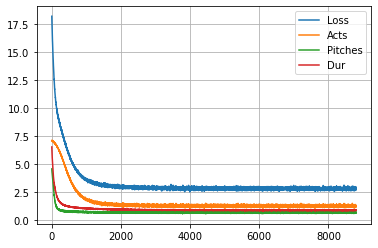

In [7]:
from matplotlib import pyplot as plt
losses = checkpoint['losses']
plt.plot(range(1, len(losses['tot'])+1), losses['tot'], label='Loss')
plt.plot(range(1, len(losses['acts'])+1), losses['acts'], label='Acts')
plt.plot(range(1, len(losses['pitches'])+1), losses['pitches'], label='Pitches')
plt.plot(range(1, len(losses['dur'])+1), losses['dur'], label='Dur')
#plt.plot(range(1, len(losses['kld'])+1), losses['kld'], label='kld')
plt.grid()
plt.legend()

Accuracy plot

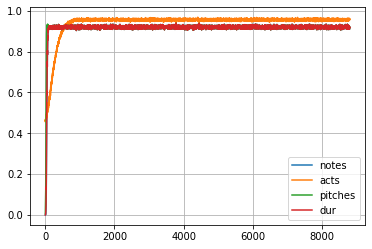

In [5]:
accs = checkpoint['accuracies']
plt.plot(range(1, len(accs['notes'])+1), accs['notes'], label='notes')
plt.plot(range(1, len(accs['acts'])+1), accs['acts'], label='acts')
plt.plot(range(1, len(accs['pitches'])+1), accs['pitches'], label='pitches')
plt.plot(range(1, len(accs['dur'])+1), accs['dur'], label='dur')
plt.grid()
plt.legend()

Learning rate plot

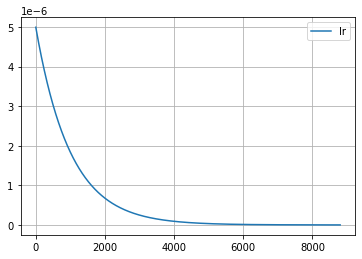

In [6]:
plt.plot(range(1, len(checkpoint['lrs'])+1), checkpoint['lrs'], label='lr')
plt.grid()
plt.legend()

# Stuff

In [ ]:
from typing import Optional, Union, Tuple
from torch_geometric.typing import OptTensor, Adj

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter
from torch_scatter import scatter
from torch_sparse import SparseTensor, matmul, masked_select_nnz
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import glorot, zeros


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (Tensor, Tensor) -> Tensor
    pass


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (SparseTensor, Tensor) -> SparseTensor
    pass


def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')


class RGCNConv(MessagePassing):
    r"""The relational graph convolutional operator from the `"Modeling
    Relational Data with Graph Convolutional Networks"
    <https://arxiv.org/abs/1703.06103>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta}_{\textrm{root}} \cdot
        \mathbf{x}_i + \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_r(i)}
        \frac{1}{|\mathcal{N}_r(i)|} \mathbf{\Theta}_r \cdot \mathbf{x}_j,

    where :math:`\mathcal{R}` denotes the set of relations, *i.e.* edge types.
    Edge type needs to be a one-dimensional :obj:`torch.long` tensor which
    stores a relation identifier
    :math:`\in \{ 0, \ldots, |\mathcal{R}| - 1\}` for each edge.

    .. note::
        This implementation is as memory-efficient as possible by iterating
        over each individual relation type.
        Therefore, it may result in low GPU utilization in case the graph has a
        large number of relations.
        As an alternative approach, :class:`FastRGCNConv` does not iterate over
        each individual type, but may consume a large amount of memory to
        compensate.
        We advise to check out both implementations to see which one fits your
        needs.

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
            In case no input features are given, this argument should
            correspond to the number of nodes in your graph.
        out_channels (int): Size of each output sample.
        num_relations (int): Number of relations.
        num_bases (int, optional): If set to not :obj:`None`, this layer will
            use the basis-decomposition regularization scheme where
            :obj:`num_bases` denotes the number of bases to use.
            (default: :obj:`None`)
        num_blocks (int, optional): If set to not :obj:`None`, this layer will
            use the block-diagonal-decomposition regularization scheme where
            :obj:`num_blocks` denotes the number of blocks to use.
            (default: :obj:`None`)
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"mean"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        num_relations: int,
        num_bases: Optional[int] = None,
        num_blocks: Optional[int] = None,
        aggr: str = 'mean',
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, node_dim=0, **kwargs)

        if num_bases is not None and num_blocks is not None:
            raise ValueError('Can not apply both basis-decomposition and '
                             'block-diagonal-decomposition at the same time.')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_relations = num_relations
        self.num_bases = num_bases
        self.num_blocks = num_blocks

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
        self.in_channels_l = in_channels[0]

        if num_bases is not None:
            self.weight = Parameter(
                torch.Tensor(num_bases, in_channels[0], out_channels))
            self.comp = Parameter(torch.Tensor(num_relations, num_bases))

        elif num_blocks is not None:
            assert (in_channels[0] % num_blocks == 0
                    and out_channels % num_blocks == 0)
            self.weight = Parameter(
                torch.Tensor(num_relations, num_blocks,
                             in_channels[0] // num_blocks,
                             out_channels // num_blocks))
            self.register_parameter('comp', None)

        else:
            self.weight = Parameter(
                torch.Tensor(num_relations, in_channels[0], out_channels))
            self.register_parameter('comp', None)

        if root_weight:
            self.root = Param(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Param(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.comp)
        glorot(self.root)
        zeros(self.bias)


    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]],
                edge_index: Adj, edge_type: OptTensor = None):
        r"""
        Args:
            x: The input node features. Can be either a :obj:`[num_nodes,
                in_channels]` node feature matrix, or an optional
                one-dimensional node index tensor (in which case input features
                are treated as trainable node embeddings).
                Furthermore, :obj:`x` can be of type :obj:`tuple` denoting
                source and destination node features.
            edge_type: The one-dimensional relation type/index for each edge in
                :obj:`edge_index`.
                Should be only :obj:`None` in case :obj:`edge_index` is of type
                :class:`torch_sparse.tensor.SparseTensor`.
                (default: :obj:`None`)
        """

        # Convert input features to a pair of node features or node indices.
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        # propagate_type: (x: Tensor)
        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)

        weight = self.weight
        if self.num_bases is not None:  # Basis-decomposition =================
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(
                self.num_relations, self.in_channels_l, self.out_channels)

        if self.num_blocks is not None:  # Block-diagonal-decomposition =====

            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported '
                                 'for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)

        else:  # No regularization/Basis-decomposition ========================
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)

                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias

        return out


    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_relations={self.num_relations})')

next edges

In [ ]:
import itertools

a = np.random.randint(2, size=(4,8))
a_t = a.transpose()
print(a_t)
inds = np.stack(np.where(a_t == 1)).transpose()
ts_acts = np.any(a_t, axis=1)
ts_inds = np.where(ts_acts)[0]

labels = np.arange(32).reshape(4, 8).transpose()
print(labels)

next_edges = []
for i in range(len(ts_inds)-1):
    ind_s = ts_inds[i]
    ind_e = ts_inds[i+1]
    s = inds[inds[:,0] == ind_s]
    e = inds[inds[:,0] == ind_e]
    e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
    edges = [(labels[tuple(e[0])],labels[tuple(e[1])], ind_e-ind_s) for e in e_inds]
    next_edges.extend(edges)

print(next_edges)
    

onset edges

In [ ]:
onset_edges = []
print(a_t)
print(labels)

for i in ts_inds:
    ts_acts_inds = list(inds[inds[:,0] == i])
    if len(ts_acts_inds) < 2:
        continue
    e_inds = list(itertools.combinations(ts_acts_inds, 2))
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], 0) for e in e_inds]
    inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
    onset_edges.extend(edges)
    onset_edges.extend(inv_edges)

print(onset_edges)


track edges

In [ ]:
print(a_t)
print(labels)
track_edges = []

for track in range(a_t.shape[1]):
    tr_inds = list(inds[inds[:,1] == track])
    e_inds = [(tr_inds[i],
               tr_inds[i+1]) for i in range(len(tr_inds)-1)]
    print(e_inds)
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], e[1][0]-e[0][0]) for e in e_inds]
    track_edges.extend(edges)

print(track_edges)

In [ ]:
track_edges = np.array(track_edges)
onset_edges = np.array(onset_edges)
np.concatenate((track_edges, onset_edges)).shape

In [ ]:
pip install pypianoroll

In [ ]:
import pypianoroll

In [ ]:
multitrack = pypianoroll.read("tests_fur-elise.mid")
print(multitrack)

In [ ]:
multitrack.tracks[0].pianoroll

In [ ]:
multitrack.plot()

In [ ]:
multitrack.trim(0, 12 * multitrack.resolution)
multitrack.binarize()

In [ ]:
multitrack.plot()

In [ ]:
multitrack.tracks[0].pianoroll.shape